<a href="https://colab.research.google.com/github/RachelRamirez/CIFAR-10/blob/main/CollectionofTests/AllRuns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Last changed 11/11 13:09
Reminder to self, please save over AllRuns.ipynb in github/rr/cifar10/collectionoftests

Description:  batches are mixing well, but horrible accuracy for certain images, maybe thats a "good" test result?  About to pass all the groups through the augmentation, maybe 1 hour * 10 groups?  

Still need to do the CSV output

### Imports

In [1]:
#@title import libraries set time
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import copy
import os
import PIL
import PIL.Image
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# import keras.utils -- dont do this!! it causes problems, 
from tensorflow.keras.utils import to_categorical  #do this instead!!
import random
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time
import pickle
from google.colab import files
import datetime # to display the current time hh:mm:ss

# Possibly Need IMGAUG to set seed in ALbumentations
# GitHub Issue: https://github.com/albumentations-team/albumentations/issues/93
import imgaug
imgaug.seed(123)


tic = time.time()  # Start the timer
initial_run = 0

AUTOTUNE = tf.data.experimental.AUTOTUNE
np.set_printoptions(precision=4)

#### Set Random Seeds

In [2]:
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed()  # https://stackoverflow.com/questions/11526975/set-random-seed-programwide-in-python
shuffle_seed = seed
## ------------------

Set Logic-Values


In [3]:
run_model = False  #When Im looking at augmentations, I don't want to keep refitting a model, I want to just get the database of images loaded

Make Image Datasets

One of my biggest learning curves was learning how to load  the dataset with tdfs.load() and then filter on images by label.  

The second biggest was using the created model to make predictions on the test set.   

Current but "skipped" problem is trying to view misclassifeid images of results.


Another area of problems is rerunning when you've already specified a batch on your dataset creates another "batch" split so it can cause problems to rerun a cell that says how to define a dataset.  Unbatch may be needed first.    

### Load Dataset

In [4]:

# A weird problem happened where it said the toronto website cant be reached, if that ever happens again make sure to go to SO for this advice https://stackoverflow.com/questions/36805640/this-error-while-downloading-datasets-valueerror-i-o-operation-on-closed-file

# How do I set IDs on: read_config.add_tfds_id = True
read_config = tfds.ReadConfig(shuffle_seed=seed) 
read_config.add_tfds_id = True  ## This didnt update ReadConfig 

dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True, read_config=read_config)
x_test =  dataset["test"]
dataset  = dataset["train"]
assert isinstance(x_test, tf.data.Dataset)
#x_test = [(example.numpy(), label.numpy()) for example, label in x_test]
# once broken into numpy arrays, my model still doesn't handle it, it seems to be expecting a tensor
# So i think i have to break it into two tensors?  test_x, test_y?
# x_test[0][0]
# x_test[0][1]
# x_test = pd.DataFrame(x_test, columns=['example', 'label'])
# x_test = tf.data.Dataset.from_generator(lambda: x_test, (tf.int64, tf.int16))
# x_list = list(x_test.as_numpy_iterator())  # Crashes Google Colab!
# print(x_list[:5])


#  I got this from stack-overflow.  Need this code to define y_test, the labels of testset

def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
        return tf.concat(labels, axis=0) # concat the list of batched labels
    return labels
y_test = get_labels_from_tfdataset(x_test)

# tfds.as_dataframe(dataset.take(5), info)  #does not display image ID :-( )

dataset_airplanes   = dataset.filter(lambda img, label: label == 0)
dataset_automobiles = dataset.filter(lambda img, label: label == 1)
dataset_birds       = dataset.filter(lambda img, label: label == 2)
dataset_cats        = dataset.filter(lambda img, label: label == 3)
dataset_deers       = dataset.filter(lambda img, label: label == 4)
dataset_dogs        = dataset.filter(lambda img, label: label == 5)
dataset_frogs       = dataset.filter(lambda img, label: label == 6)
dataset_horses      = dataset.filter(lambda img, label: label == 7)
dataset_ships       = dataset.filter(lambda img, label: label == 8)
dataset_trucks      = dataset.filter(lambda img, label: label == 9)

##  Ways to count the number of images in the sets:
print("There are ways to count and verify the number per training set which i have hidden because they are costly")
print("Entire Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset).numpy()) #   prints 50,000, correct
print("Entire Airplane Training Dataset was originally cardinality:", tf.data.experimental.cardinality(dataset_airplanes).numpy()) #   prints -2 this is a "feature" in tf when a set takes too long to count
# print(dataset_airplanes.reduce(np.int64(0), lambda x,_ : x + 1).numpy()) #prints 5000, correct

##  This is a way of asserting that all the images have the same label in a set
# for img, label in dataset_dogs:
#   assert label == 5
 

There are ways to count and verify the number per training set which i have hidden because they are costly
Entire Training Dataset was originally cardinality: 50000
Entire Airplane Training Dataset was originally cardinality: -2


## Count CIFAR 10 Functions

In [5]:
#@title 'count_cifar10_class' { form-width: "1px" }
# define a fuction to count the numbre of each class
# I'm not going to worry about it now, but if i had time to cleanup code I would 
# Try to use this type of if/zip structure  https://stackoverflow.com/questions/57784643/if-statement-and-zip



 
def count_cifar10_class(datasetpassed):
  # takes the datasetpassed and returns the number of each category as a ten-tupple
  num_airplanes, num_automobiles, num_birds, num_cats, num_deers = 0,0,0,0,0
  num_dogs, num_frogs, num_horses, num_ships, num_trucks= 0, 0, 0,0,0


  # print("Unbatched?" , check_if_unbatched(datasetpassed))
  # print("Take?", check_if_take(datasetpassed))
  # print("Unbatched or Take?", ( check_if_unbatched(datasetpassed) or  check_if_take(datasetpassed)))

  if ( check_if_unbatched(datasetpassed) or  check_if_take(datasetpassed)):
    if check_if_take(datasetpassed):
      datasetpassed = make_unbatched(datasetpassed)

    for img, label in datasetpassed:
      if label == 0:
        num_airplanes += 1

      if label == 1:
        num_automobiles += 1

      if label == 2:
        num_birds +=1

      if label == 3:
        num_cats +=1

      if label ==4: 
        num_deers += 1

      if label == 5:
        num_dogs += 1 

      if label == 6:
          num_frogs += 1

      if label == 7:
        num_horses += 1

      if label == 8:
        num_ships +=1 

      if label == 9: 
        num_trucks +=1
    
    return num_airplanes, num_automobiles, num_birds, num_cats, num_deers, num_dogs, num_frogs, num_horses, num_ships, num_trucks 
  # else if the dataset is not batched or if one batch from take is being passed, proceed to counting thing below 
  else:
    print(" ** Dataset is batched, please pass 1 batch at a time to cifar10 to see metrics ** ")



  




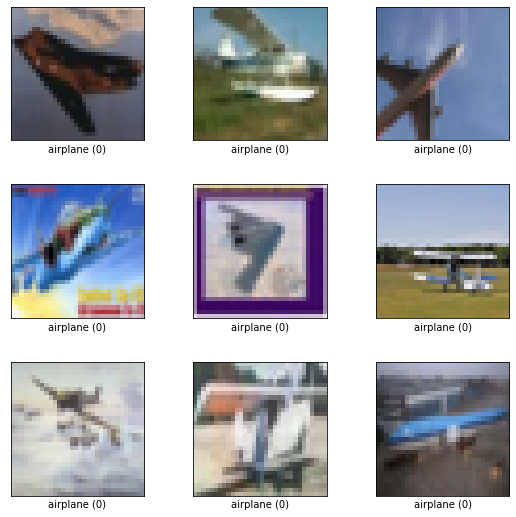

In [6]:
#@title ShowExamplesofDatasetAirplanes
## Tfds.show_examples is a matplotlib funnction that only works on image ds's, and you have to pass it the "info" for some reason
fig = tfds.show_examples(dataset_airplanes, info)

How to display one picture of a dataset using `next(iter(dataset)`

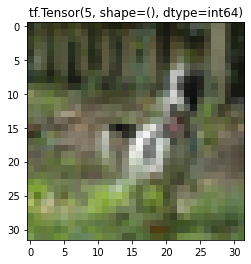

In [7]:
#@title ShowExampleofOneIterations of DatasetDogs
# I wish I could display ID!!

img, label = next(iter(dataset_dogs))
plt.title(str(label))
plt.imshow(img)

#0x7f6e309eff10?


# Create validation set of 10,000 images

In [8]:
#@title
# I want 10 un replicated samples from dataset_airplanes + dataset_automobiles... dataset_trucks.

# There are 5000 images of each Class 
# I want 10 equal sets A, B, C, D, ... J plus a validation set
# I want 10,000 total images in the validation set with 1000 of each class
# and I want 10 sets of training images  4000 total images, so 400 images in each class

N = 1000
dataset_airplanes_val   = dataset_airplanes.take(N)
dataset_automobiles_val  = dataset_automobiles.take(N)
dataset_birds_val       = dataset_birds.take(N)  
dataset_cats_val        = dataset_cats.take(N)
dataset_deers_val       = dataset_deers.take(N)
dataset_dogs_val        = dataset_dogs.take(N)
dataset_frogs_val       = dataset_frogs.take(N)
dataset_horses_val      = dataset_horses.take(N)
dataset_ships_val       = dataset_ships.take(N)
dataset_trucks_val      = dataset_trucks.take(N)


# Make sure to skip the next 1000 images in each data set before making training set
dataset_airplanes   = dataset_airplanes.skip(N)
dataset_automobiles  = dataset_automobiles.skip(N)
dataset_birds      = dataset_birds.skip(N)  
dataset_cats        = dataset_cats.skip(N)
dataset_deers       = dataset_deers.skip(N)
dataset_dogs        = dataset_dogs.skip(N)
dataset_frogs       = dataset_frogs.skip(N)
dataset_horses      = dataset_horses.skip(N)
dataset_ships       = dataset_ships.skip(N)
dataset_trucks      = dataset_trucks.skip(N)

# # Check that remaining dataset does not have validation data
# fig = tfds.show_examples(dataset_ships, info)
# fig = tfds.show_examples(dataset_ships_val, info)
# # I checked and they dont.


# NOW, How do I combine my val sets?

# Hint1 its not this... 
# val = dataset_airplanes_val + dataset_automobile_val + dataset_birds_val

# #  Hint2 its also not this implementation of zip because the info file doesn't match it
# val = tf.data.Dataset.zip((dataset_airplanes_val,
#                     dataset_automobile_val,
#                     dataset_birds_val,
#                     dataset_cats_val,
#                     dataset_deers_val,
#                     dataset_dogs_val,
#                     dataset_frogs_val,
#                     dataset_horses_val,
#                     dataset_ships_val,
#                     dataset_trucks_val ))
 
# fig = tfds.show_examples(val, info)   # Returns a warning that the info file is not compatible


# is it concatenate? YESSSSSSSSSSSSSSSSSSSSSS
val = dataset_airplanes_val.concatenate(dataset_automobiles_val)
# This is how I checked that it worked
# fig = tfds.show_examples(val.skip(999), info)    # shows 1 airplane and then 8 automobiles

val = val.concatenate(dataset_birds_val)
val = val.concatenate(dataset_cats_val)
val = val.concatenate(dataset_deers_val)
val = val.concatenate(dataset_dogs_val)
val = val.concatenate(dataset_frogs_val)
val = val.concatenate(dataset_horses_val)
val = val.concatenate(dataset_ships_val)
val = val.concatenate(dataset_trucks_val)
  
# print(val.reduce(np.int32(0), lambda x,_ : x + 1))  # this shows 10000! Thank goodness! :-)



# Create smaller groups of each CIFAR Class sets (set Shard)

After removing the 10,000 validation set from the training-data, the remaining set has 40,000 images, 4000 images of each class.  To create smaller training-datasets of similar sizes, shard the dataset into equal pieces.

For the initial days of testing I decided on **250 images** per class for my first couple runs, which equates to 16 shards (40,000/16 = 250) .  When I wanted to study what was going on more beneath the hood for my augmentations, I decided to make the training set even more tiny so I could view all the images per training set I decided to try 1 image per class so I could easily view all the images augmeted and not augmented.  This meant I needed **4000 shards!** for troubleshooting.



In [9]:
SHARDS=16

#### Airplanes (airplanes_A, ... airplanes_P)

In [10]:
#@title
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shard

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_airplanes.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
airplanes_A = dataset_airplanes.shard(num_shards=SHARDS, index = 0)
airplanes_B = dataset_airplanes.shard(num_shards=SHARDS, index = 1)
airplanes_C = dataset_airplanes.shard(num_shards=SHARDS, index = 2)
airplanes_D = dataset_airplanes.shard(num_shards=SHARDS, index = 3)
airplanes_E = dataset_airplanes.shard(num_shards=SHARDS, index = 4)
airplanes_F = dataset_airplanes.shard(num_shards=SHARDS, index = 5)
airplanes_G = dataset_airplanes.shard(num_shards=SHARDS, index = 6)
airplanes_H = dataset_airplanes.shard(num_shards=SHARDS, index = 7)
airplanes_I = dataset_airplanes.shard(num_shards=SHARDS, index = 8)
airplanes_J = dataset_airplanes.shard(num_shards=SHARDS, index = 9)
airplanes_K = dataset_airplanes.shard(num_shards=SHARDS, index = 10)
airplanes_L = dataset_airplanes.shard(num_shards=SHARDS, index = 11)
airplanes_M = dataset_airplanes.shard(num_shards=SHARDS, index = 12)
airplanes_N = dataset_airplanes.shard(num_shards=SHARDS, index = 13)
airplanes_O = dataset_airplanes.shard(num_shards=SHARDS, index = 14)
airplanes_P = dataset_airplanes.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_M.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Automobiles

In [11]:
#@title
# dataset_automobile

# Check that each of the remaining 10 datasets has only 4000 images 
# print(dataset_automobile.reduce(np.int32(0), lambda x,_ : x + 1))  # 4000 check!

# Shard each of the remaining 10 datasets into 16 smaller groups
automobiles_A = dataset_automobiles.shard(num_shards=SHARDS, index = 0)
automobiles_B = dataset_automobiles.shard(num_shards=SHARDS, index = 1)
automobiles_C = dataset_automobiles.shard(num_shards=SHARDS, index = 2)
automobiles_D = dataset_automobiles.shard(num_shards=SHARDS, index = 3)
automobiles_E = dataset_automobiles.shard(num_shards=SHARDS, index = 4)
automobiles_F = dataset_automobiles.shard(num_shards=SHARDS, index = 5)
automobiles_G = dataset_automobiles.shard(num_shards=SHARDS, index = 6)
automobiles_H = dataset_automobiles.shard(num_shards=SHARDS, index = 7)
automobiles_I = dataset_automobiles.shard(num_shards=SHARDS, index = 8)
automobiles_J = dataset_automobiles.shard(num_shards=SHARDS, index = 9)
automobiles_K = dataset_automobiles.shard(num_shards=SHARDS, index = 10)
automobiles_L = dataset_automobiles.shard(num_shards=SHARDS, index = 11)
automobiles_M = dataset_automobiles.shard(num_shards=SHARDS, index = 12)
automobiles_N = dataset_automobiles.shard(num_shards=SHARDS, index = 13)
automobiles_O = dataset_automobiles.shard(num_shards=SHARDS, index = 14)
automobiles_P = dataset_automobiles.shard(num_shards=SHARDS, index = 15)


#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Birds

In [12]:
#@title
# dataset_birds

# Shard each of the remaining 10 datasets into 16 smaller groups
birds_A = dataset_birds.shard(num_shards=SHARDS, index = 0)
birds_B = dataset_birds.shard(num_shards=SHARDS, index = 1)
birds_C = dataset_birds.shard(num_shards=SHARDS, index = 2)
birds_D = dataset_birds.shard(num_shards=SHARDS, index = 3)
birds_E = dataset_birds.shard(num_shards=SHARDS, index = 4)
birds_F = dataset_birds.shard(num_shards=SHARDS, index = 5)
birds_G = dataset_birds.shard(num_shards=SHARDS, index = 6)
birds_H = dataset_birds.shard(num_shards=SHARDS, index = 7)
birds_I = dataset_birds.shard(num_shards=SHARDS, index = 8)
birds_J = dataset_birds.shard(num_shards=SHARDS, index = 9)
birds_K = dataset_birds.shard(num_shards=SHARDS, index = 10)
birds_L = dataset_birds.shard(num_shards=SHARDS, index = 11)
birds_M = dataset_birds.shard(num_shards=SHARDS, index = 12)
birds_N = dataset_birds.shard(num_shards=SHARDS, index = 13)
birds_O = dataset_birds.shard(num_shards=SHARDS, index = 14)
birds_P = dataset_birds.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(airplanes_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Cats

In [13]:
#@title
# dataset_cats

# Shard each of the remaining 10 datasets into 16 smaller groups
cats_A = dataset_cats.shard(num_shards=SHARDS, index = 0)
cats_B = dataset_cats.shard(num_shards=SHARDS, index = 1)
cats_C = dataset_cats.shard(num_shards=SHARDS, index = 2)
cats_D = dataset_cats.shard(num_shards=SHARDS, index = 3)
cats_E = dataset_cats.shard(num_shards=SHARDS, index = 4)
cats_F = dataset_cats.shard(num_shards=SHARDS, index = 5)
cats_G = dataset_cats.shard(num_shards=SHARDS, index = 6)
cats_H = dataset_cats.shard(num_shards=SHARDS, index = 7)
cats_I = dataset_cats.shard(num_shards=SHARDS, index = 8)
cats_J = dataset_cats.shard(num_shards=SHARDS, index = 9)
cats_K = dataset_cats.shard(num_shards=SHARDS, index = 10)
cats_L = dataset_cats.shard(num_shards=SHARDS, index = 11)
cats_M = dataset_cats.shard(num_shards=SHARDS, index = 12)
cats_N = dataset_cats.shard(num_shards=SHARDS, index = 13)
cats_O = dataset_cats.shard(num_shards=SHARDS, index = 14)
cats_P = dataset_cats.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(cats_P.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Deer(s)

In [14]:
#@title
# dataset_deers
# Shard each of the remaining 10 datasets into 16 smaller groups
deers_A = dataset_deers.shard(num_shards=SHARDS, index = 0)
deers_B = dataset_deers.shard(num_shards=SHARDS, index = 1)
deers_C = dataset_deers.shard(num_shards=SHARDS, index = 2)
deers_D = dataset_deers.shard(num_shards=SHARDS, index = 3)
deers_E = dataset_deers.shard(num_shards=SHARDS, index = 4)
deers_F = dataset_deers.shard(num_shards=SHARDS, index = 5)
deers_G = dataset_deers.shard(num_shards=SHARDS, index = 6)
deers_H = dataset_deers.shard(num_shards=SHARDS, index = 7)
deers_I = dataset_deers.shard(num_shards=SHARDS, index = 8)
deers_J = dataset_deers.shard(num_shards=SHARDS, index = 9)
deers_K = dataset_deers.shard(num_shards=SHARDS, index = 10)
deers_L = dataset_deers.shard(num_shards=SHARDS, index = 11)
deers_M = dataset_deers.shard(num_shards=SHARDS, index = 12)
deers_N = dataset_deers.shard(num_shards=SHARDS, index = 13)
deers_O = dataset_deers.shard(num_shards=SHARDS, index = 14)
deers_P = dataset_deers.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(deers_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

In [15]:
#@title


In [16]:
#@title


#### Dogs

In [17]:
#@title
# dataset_dogs
# Shard each of the remaining 10 datasets into 16 smaller groups
dogs_A = dataset_dogs.shard(num_shards=SHARDS, index = 0)
dogs_B = dataset_dogs.shard(num_shards=SHARDS, index = 1)
dogs_C = dataset_dogs.shard(num_shards=SHARDS, index = 2)
dogs_D = dataset_dogs.shard(num_shards=SHARDS, index = 3)
dogs_E = dataset_dogs.shard(num_shards=SHARDS, index = 4)
dogs_F = dataset_dogs.shard(num_shards=SHARDS, index = 5)
dogs_G = dataset_dogs.shard(num_shards=SHARDS, index = 6)
dogs_H = dataset_dogs.shard(num_shards=SHARDS, index = 7)
dogs_I = dataset_dogs.shard(num_shards=SHARDS, index = 8)
dogs_J = dataset_dogs.shard(num_shards=SHARDS, index = 9)
dogs_K = dataset_dogs.shard(num_shards=SHARDS, index = 10)
dogs_L = dataset_dogs.shard(num_shards=SHARDS, index = 11)
dogs_M = dataset_dogs.shard(num_shards=SHARDS, index = 12)
dogs_N = dataset_dogs.shard(num_shards=SHARDS, index = 13)
dogs_O = dataset_dogs.shard(num_shards=SHARDS, index = 14)
dogs_P = dataset_dogs.shard(num_shards=SHARDS, index = 15)

#check that a random airplane dataset only has 250 images
# print(dogs_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


#### Frogs

In [18]:
#@title
# dataset_frogs
# Shard each of the remaining 10 datasets into 16 smaller groups
frogs_A = dataset_frogs.shard(num_shards=SHARDS, index = 0)
frogs_B = dataset_frogs.shard(num_shards=SHARDS, index = 1)
frogs_C = dataset_frogs.shard(num_shards=SHARDS, index = 2)
frogs_D = dataset_frogs.shard(num_shards=SHARDS, index = 3)
frogs_E = dataset_frogs.shard(num_shards=SHARDS, index = 4)
frogs_F = dataset_frogs.shard(num_shards=SHARDS, index = 5)
frogs_G = dataset_frogs.shard(num_shards=SHARDS, index = 6)
frogs_H = dataset_frogs.shard(num_shards=SHARDS, index = 7)
frogs_I = dataset_frogs.shard(num_shards=SHARDS, index = 8)
frogs_J = dataset_frogs.shard(num_shards=SHARDS, index = 9)
frogs_K = dataset_frogs.shard(num_shards=SHARDS, index = 10)
frogs_L = dataset_frogs.shard(num_shards=SHARDS, index = 11)
frogs_M = dataset_frogs.shard(num_shards=SHARDS, index = 12)
frogs_N = dataset_frogs.shard(num_shards=SHARDS, index = 13)
frogs_O = dataset_frogs.shard(num_shards=SHARDS, index = 14)
frogs_P = dataset_frogs.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(frogs_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Horses

In [19]:
#@title
# dataset_horses
# Shard each of the remaining 10 datasets into 16 smaller groups
horses_A = dataset_horses.shard(num_shards=SHARDS, index = 0)
horses_B = dataset_horses.shard(num_shards=SHARDS, index = 1)
horses_C = dataset_horses.shard(num_shards=SHARDS, index = 2)
horses_D = dataset_horses.shard(num_shards=SHARDS, index = 3)
horses_E = dataset_horses.shard(num_shards=SHARDS, index = 4)
horses_F = dataset_horses.shard(num_shards=SHARDS, index = 5)
horses_G = dataset_horses.shard(num_shards=SHARDS, index = 6)
horses_H = dataset_horses.shard(num_shards=SHARDS, index = 7)
horses_I = dataset_horses.shard(num_shards=SHARDS, index = 8)
horses_J = dataset_horses.shard(num_shards=SHARDS, index = 9)
horses_K = dataset_horses.shard(num_shards=SHARDS, index = 10)
horses_L = dataset_horses.shard(num_shards=SHARDS, index = 11)
horses_M = dataset_horses.shard(num_shards=SHARDS, index = 12)
horses_N = dataset_horses.shard(num_shards=SHARDS, index = 13)
horses_O = dataset_horses.shard(num_shards=SHARDS, index = 14)
horses_P = dataset_horses.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(horses_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Ships

In [20]:
#@title
# dataset_ships
# Shard each of the remaining 10 datasets into 16 smaller groups
ships_A = dataset_ships.shard(num_shards=SHARDS, index = 0)
ships_B = dataset_ships.shard(num_shards=SHARDS, index = 1)
ships_C = dataset_ships.shard(num_shards=SHARDS, index = 2)
ships_D = dataset_ships.shard(num_shards=SHARDS, index = 3)
ships_E = dataset_ships.shard(num_shards=SHARDS, index = 4)
ships_F = dataset_ships.shard(num_shards=SHARDS, index = 5)
ships_G = dataset_ships.shard(num_shards=SHARDS, index = 6)
ships_H = dataset_ships.shard(num_shards=SHARDS, index = 7)
ships_I = dataset_ships.shard(num_shards=SHARDS, index = 8)
ships_J = dataset_ships.shard(num_shards=SHARDS, index = 9)
ships_K = dataset_ships.shard(num_shards=SHARDS, index = 10)
ships_L = dataset_ships.shard(num_shards=SHARDS, index = 11)
ships_M = dataset_ships.shard(num_shards=SHARDS, index = 12)
ships_N = dataset_ships.shard(num_shards=SHARDS, index = 13)
ships_O = dataset_ships.shard(num_shards=SHARDS, index = 14)
ships_P = dataset_ships.shard(num_shards=SHARDS, index = 15)
#check that a random airplane dataset only has 250 images
# print(ships_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!

#### Trucks


In [21]:
#@title
# dataset_trucks
# Shard each of the remaining 10 datasets into 16 smaller groups
trucks_A = dataset_trucks.shard(num_shards=SHARDS, index = 0)
trucks_B = dataset_trucks.shard(num_shards=SHARDS, index = 1)
trucks_C = dataset_trucks.shard(num_shards=SHARDS, index = 2)
trucks_D = dataset_trucks.shard(num_shards=SHARDS, index = 3)
trucks_E = dataset_trucks.shard(num_shards=SHARDS, index = 4)
trucks_F = dataset_trucks.shard(num_shards=SHARDS, index = 5)
trucks_G = dataset_trucks.shard(num_shards=SHARDS, index = 6)
trucks_H = dataset_trucks.shard(num_shards=SHARDS, index = 7)
trucks_I = dataset_trucks.shard(num_shards=SHARDS, index = 8)
trucks_J = dataset_trucks.shard(num_shards=SHARDS, index = 9)
trucks_K = dataset_trucks.shard(num_shards=SHARDS, index = 10)
trucks_L = dataset_trucks.shard(num_shards=SHARDS, index = 11)
trucks_M = dataset_trucks.shard(num_shards=SHARDS, index = 12)
trucks_N = dataset_trucks.shard(num_shards=SHARDS, index = 13)
trucks_O = dataset_trucks.shard(num_shards=SHARDS, index = 14)
trucks_P = dataset_trucks.shard(num_shards=SHARDS, index = 15)


#check that a random airplane dataset only has 250 images
# print(trucks_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250 check!


# Concatenate the smaller CIFAR classes sets into 10 independent small  training Groups: 

This is the `train_A`, `train_B`, `train_C`... `train_J`  datasets of 1 image each class, 10 images total, currently ao 11/10/21. and will be updated to  whatever the current SHARD is later

#### Group A  (train_A)

In [22]:
#@title
# {A}
X = birds_A, cats_A, deers_A, dogs_A, frogs_A, horses_A, ships_A, trucks_A
train_A = airplanes_A.concatenate(automobiles_A)

for i in list(X):
  train_A = train_A.concatenate(i) 

print(train_A.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

tf.Tensor(2500, shape=(), dtype=int32)


#### Group B

In [23]:
#@title
# {B}
X = birds_B, cats_B, deers_B, dogs_B, frogs_B, horses_B, ships_B, trucks_B
train_B = airplanes_B.concatenate(automobiles_B)

for i in list(X):
  train_B = train_B.concatenate(i)

# print(train_B.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group C

In [24]:
#@title
# {C}
X = birds_C, cats_C, deers_C, dogs_C, frogs_C, horses_C, ships_C, trucks_C
train_C = airplanes_C.concatenate(automobiles_C)

for i in list(X):
  train_C = train_C.concatenate(i)

# print(train_C.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group D

In [25]:
#@title
# {D}
X = birds_D, cats_D, deers_D, dogs_D, frogs_D, horses_D, ships_D, trucks_D
train_D = airplanes_D.concatenate(automobiles_D)

for i in list(X):
  train_D = train_D.concatenate(i)

# print(train_D.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group E

In [26]:
#@title
# {E}
X = birds_E, cats_E, deers_E, dogs_E, frogs_E, horses_E, ships_E, trucks_E
train_E = airplanes_E.concatenate(automobiles_E)

for i in list(X):
  train_E = train_E.concatenate(i)

# print(train_E.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group F

In [27]:
#@title
# {F}
X = birds_F, cats_F, deers_F, dogs_F, frogs_F, horses_F, ships_F, trucks_F
train_F = airplanes_F.concatenate(automobiles_F)

for i in list(X):
  train_F = train_F.concatenate(i)

# print(train_F.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group G

In [28]:
#@title
# {G}
X = birds_G, cats_G, deers_G, dogs_G, frogs_G, horses_G, ships_G, trucks_G
train_G = airplanes_G.concatenate(automobiles_G)

for i in list(X):
  train_G = train_G.concatenate(i)

# print(train_G.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group H

In [29]:
#@title
# {H}
X = birds_H, cats_H, deers_H, dogs_H, frogs_H, horses_H, ships_H, trucks_H
train_H = airplanes_H.concatenate(automobiles_H)

for i in list(X):
  train_H = train_H.concatenate(i)

# print(train_H.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group I

In [30]:
#@title
# {I}
X = birds_I, cats_I, deers_I, dogs_I, frogs_I, horses_I, ships_I, trucks_I
train_I = airplanes_I.concatenate(automobiles_I)

for i in list(X):
  train_I = train_I.concatenate(i)

# print(train_I.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

#### Group J

In [31]:
#@title
# {J}
X = birds_J, cats_J, deers_J, dogs_J, frogs_J, horses_J, ships_J, trucks_J
train_J = airplanes_J.concatenate(automobiles_J)

for i in list(X):
  train_J = train_J.concatenate(i)

# print(train_J.reduce(np.int32(0), lambda x,_ : x + 1))  # 250*10 = 2500? 

Testing out whether I can see IDs again...

I added some code before the lines to load dataset, they are as follows#
from https://www.tensorflow.org/datasets/api_docs/python/tfds/load#args
and https://www.tensorflow.org/datasets/determinism



> read_config code added


```
read_config = tfds.ReadConfig(shuffle_seed=seed) 
read_config.add_tfds_id = True
dataset, info = tfds.load('cifar10', as_supervised=True, with_info=True, read_config=read_config)
```


I want to make sure the rest of my scripts run fine before any more tinkering!

In [32]:
# # I believe I need to define the shuffle number for the Train_A set by using the total number of images in it, not just an arbitrarily large number?
# # count = count_images(train_A)
# # unbatch_train_A = (tf.data.Dataset.unbatch(train_A))
# # count = count_images(unbatch_train_A)

# #this changes everytime i run it

# # for id, img, label in unbatch_train_A:
# #   print(label)  # this appears to be the labels of the image in unbatchtrain_A (7, 6, 4, 2, 1, 3, 9, 5, 8, 0)
# #   #print(img)  # these are each of the images 32*32*3
# #   print(id)
 
# tfds.as_dataframe(dataset.take(5), info)  #it doesn't look like IDS is being returned in info

# print(info)


### Adding Batches, Buffers, Shuffles and Caches to Val, Test, and Train_A

The following is necessary to run the datasets through the CNN models  Do not run the following more than once because it'll try to make an additional "batch" dimension in your datasets

The result of running `print(info)`:

> CIFAR10 Info
```
tfds.core.DatasetInfo(    
    name='cifar10',
    version=3.0.2,    
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',   
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',   
    features=FeaturesDict({   
        'id': Text(shape=(), dtype=tf.string),   
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),   
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),   
    }),   
    total_num_examples=60000,   
    splits={   
        'test': 10000,   
        'train': 50000,   
    },   
    supervised_keys=('image', 'label'),   
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,   
        author = {Alex Krizhevsky},   
        title = {Learning multiple layers of features from tiny images},   
        institution = {},  
        year = {2009}   
    }""",   
    redistribution_info=,   
)
```
 




In [33]:
#@title

train_A_shuffle_num = 2500
tran_A_batch_num    = 100

if initial_run == 0: 
    
  # AUTOTUNE = tf.data.AUTOTUNE # results in -1 which i think is code for the whole database
  train_A = train_A.cache().prefetch(buffer_size=AUTOTUNE)
  train_A = train_A.shuffle(train_A_shuffle_num, reshuffle_each_iteration=False)  #, seed=seed)
  train_A = train_A.batch(tran_A_batch_num)  

  val = val.cache().prefetch(buffer_size=AUTOTUNE)
  val = val.batch(100)

  x_test = x_test.cache().prefetch(AUTOTUNE)
  x_test = x_test.batch(500)

else:
  pass

initial_run = initial_run+1

#### Time required to create datasets:  

In [34]:

toc = time.time()  
print(f"Made datasets in {toc - tic:0.4f} seconds")
!mkdir -p saved_model


Made datasets in 23.6159 seconds


Get min-max values of dataset to see whata the range is

In [35]:

def get_min_max(tfdata, text):
  print(str(text), "is ", tfdata)
  image, _ = next(iter(tfdata))
  print("test")
  print(np.min(image[0]), np.max(image[0]), "\n")


# I've decided to hide the following code, which was merely to let me see what the range of the pixel values were, and it was usually around 2-253 or so
# get_min_max(train_A, "train_A")
# get_min_max(x_test, "x_test")
# get_min_max(val, "val")



# Build CNN 

## Train the model function :


In [36]:
#@title Make a Vanilla CNN Function { form-width: "20px" }
# Make a Vanilla CNN
# One thing I'd like to add is residual connections, as Cholet mentions that is a standard practice in computer vision


def makemodel(DROPOUT):  #returns model
  num_classes = 10
  input_shape = (32, 32, 3)

  # For Reference these are the defaults
  # kernel_initializer="glorot_uniform",
  # bias_initializer="zeros",
  # padding="valid",  #valid = no padding
  # kernel_regularizer=None,
  # bias_regularizer=None,
  # activity_regularizer=None,

  initializer = tf.keras.initializers.HeUniform(seed)  #this alows the model to start from the same weights each time

  model = tf.keras.Sequential(
  [
      #keras.Input(),
      tf.keras.Input(shape=input_shape),

      layers.experimental.preprocessing.Rescaling(1./255),
      #data_augmentation,   
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer1"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool1"),
      layers.BatchNormalization(name="BN1"),
   
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer2"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool2"),
      layers.BatchNormalization(name="BN2"),
   
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu", kernel_initializer=initializer, name="ConvLayer3"),
      layers.MaxPooling2D(pool_size=(2, 2), name="MaxPool3"),
      layers.BatchNormalization(name="BN3"),
   
      layers.Flatten(),
      layers.Dropout(DROPOUT),
      layers.Dense(512, activation="relu", kernel_initializer=initializer),
      layers.Dropout(DROPOUT),
      layers.Dense(num_classes, activation="softmax")

  ])


  model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])  #changed, added to val_accuracy
  
  print(" ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ ")
  print("Dropout:  ", DROPOUT)
  model.save_weights('saved_model/blank_model')  # Enables a fresh-restart between runs
  model.load_weights('saved_model/blank_model')

  return model

# -----------------------------------------

# I need to understand tf.function better 
# @tf.function

def trainmodel(MODEL, TRAININGDATA):   # returns TRAINEDMODEL

  history = MODEL.fit(
    TRAININGDATA,
    validation_data=(val),
    epochs=100,
    callbacks = keras.callbacks.EarlyStopping(monitor= 'val_loss', patience=15, restore_best_weights=True), 
    verbose=0 # 
  )

  #I've entered show plot-loss twice to force another plot to move down the screen
  #this code would be improved if i could simply make this appear under /
  # the view_images command that displays 10 to 20 images


  # # summarize history for loss
  # x = 0
  # y = 0
  # plt.plot(x)
  # plt.plot(y)
  # plt.show()
 

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  val_acc_array = history.history['val_accuracy']
  val_loss_array = history.history['val_loss']

  n_epochs_best = np.argmax(val_acc_array)
  n_epochs_bestloss = np.argmin(val_loss_array)
  print("Early-Stop is on Val-Loss with patience = 15")

  
  
  print("Early Stop Epoch was: ", n_epochs_bestloss, "when  Val Loss was: ", np.min(val_loss_array), ", and Val Acc happened to be", val_acc_array[n_epochs_bestloss])
  print("Additionally, the best val acc epoch happened to be ", n_epochs_best, "when val acc was: ",  val_acc_array[n_epochs_best], "and Val Loss happened to be ",  val_loss_array[n_epochs_best] )
  if (n_epochs_bestloss > 90) or (n_epochs_best >90 ) :
    print("This is a pretty high epoch number! ********************************")

  # model.save('saved_model/my_model')




  return MODEL



# Transition to Augmentations


In [37]:
#@title Augmentations Timer

start_augmentations = time.time()

## Prepare the Google Colab environment for Albumentations



#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [38]:
#@title  instal augmentations
# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) is successfully installed"

!pip install -U git+https://github.com/albumentations-team/albumentations -q
# necessary imports
from functools import partial
import albumentations as A
import cv2 as cv2

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE


## Define Augmentation Factors' Order and Levels

The following are 21 factors: 20 data-augmentation techniques and one regularization factor "*Dropout*" Percent Level, to compare with.  The order is what seemed to give each factor the most opportunity to add to the image, and more "destructive" factors were ordered later, like "ToGray" and Crop or ZoomIn since they take away image data permanently.  Zoom Out was order 11 because I wanted to make sure noise, blur, zoom, sharpen, contrast, did not have a over-magnified effect if after ZoomOut.  FlipHorizontal and FlipVertical are at the bottom not because they are destructive, but because I wanted to keep the categorical variables grouped as much as possible for consistent coding practices.

|Order | Factors | Role | Low | High |
| -: | :- | :-: | :-: | :-: |
1|*dropout*|Continuous|0.4  |0.6
2|shiftX|Continuous|0 | 0.1
3|shiftY|Continuous|0|  0.1
4|noise|Continuous|0  |24
5|blur|Continuous|0 | 7**
6|sharpen|Continuous|0 | 0.1
7|contrast|Continuous|0 | 0.2
8|brighten|Continuous|0|  0.2
9|darken (negative brightness)|Continuous|0 | -0.2 *
10|gamma|Continuous|100|  120
11|zoomOut (negative zoomin) |Continuous| 0 | -0.16*
12|rotate|Continuous|0|  14
13|crop|Continuous|32* | 24*
14|zoomin|Continuous|0  |0.16
15|flipH|Categorical|0 | 1
16|flipV|Categorical|0 | 1
17|fancyPCA|Categorical|0 | 1
18|equalize|Categorical|0 | 1
19|channelShuffle|Categorical|0 | 1
20|elasticTransform|Categorical|0 | 1
21|togray|Categorical|0 | 1

* Values with asterisks are for emphasis since they seem counterintuitive

** Blur values can only be odd so a center point will be rounded down from 3.5 to 3 - four center points were changed

A 50-run definitive screening design with 2 blocks is used to see which main effects are most important.  The JMP Metrics for this design are below:

 | Definitive Screening Design Diagnostics  | | 
| --- | --- | 
 | D Efficiency| 92.46019| 
| G Efficiency | 81.68744 | 
| A Efficiency | 91.32396 | 
| Average Variance of Prediction	 | 0.298038 |


## Define Randomized Definitive Screening Design 

**Block 1**
 
 xRun|Block|dropout|shiftX|shiftY|noise|blur|sharpen|contrast|brighten|darken|gamma|zoomOut|rotate|crop|zoomin|flipH|flipV|fancyPCA|equalize|channelShuffle|elasticTransform|togray
:-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-
1|1|0.4|0.1|0|24|7|0.1|0.2|0.2|-0.2|100|-0.08|14|24|0.16|1|1|0|1|0|1|0
2|1|0.4|0.1|0|24|7|0|0|0|0|100|-0.16|0|32|0|1|1|1|1|1|1|0
3|1|0.5|0|0|24|7|0.1|0|0.2|-0.2|100|-0.16|14|32|0.16|0|0|0|0|1|0|1
4|1|0.4|0|0.1|24|3|0.1|0|0|-0.2|100|0|0|32|0|1|1|0|0|0|1|1
5|1|0.6|0|0|0|0|0|0.2|0.2|-0.2|100|0|0|32|0.16|1|1|1|0|1|0|0
6|1|0.6|0.1|0|24|0|0.1|0.2|0|-0.2|120|-0.16|0|24|0.08|1|0|1|0|0|1|1
7|1|0.4|0|0|0|7|0|0.2|0.2|0|120|0|7|24|0|0|1|0|0|0|1|1
8|1|0.4|0.1|0.1|0|0|0.1|0.2|0.2|-0.2|100|0|0|32|0|0|0|1|1|1|1|1
9|1|0.6|0|0|24|7|0|0|0|0|120|-0.16|14|24|0.16|1|1|0|0|0|0|0
10|1|0.5|0.05|0.05|12|3|0.05|0.1|0.1|-0.1|110|-0.08|7|28|0.08|0|0|0|0|0|0|0
11|1|0.4|0|0|24|7|0.1|0.2|0.1|-0.2|120|0|0|24|0|0|0|1|1|1|0|0
12|1|0.4|0.1|0.1|24|0|0|0.2|0.2|-0.2|120|-0.16|0|32|0.16|0|1|0|1|0|0|0
13|1|0.6|0|0|0|7|0.1|0|0|0|100|0|14|24|0|1|0|1|0|1|1|1
14|1|0.6|0.05|0.1|24|7|0.1|0.2|0.2|0|120|0|14|32|0.16|1|1|1|1|1|1|1
15|1|0.4|0|0|0|7|0|0|0.2|-0.2|120|-0.16|0|32|0.16|1|0|1|1|0|1|1
16|1|0.4|0.05|0|0|0|0|0|0|-0.2|100|-0.16|0|24|0|0|0|0|0|0|0|0
17|1|0.4|0.1|0.1|24|7|0.1|0|0|0|120|-0.16|14|24|0|0|0|0|1|0|1|1
18|1|0.6|0.1|0.1|24|0|0.1|0|0|-0.2|100|-0.16|7|32|0.16|1|0|1|1|1|0|0
19|1|0.6|0|0.1|0|0|0|0|0|0|120|-0.08|0|32|0|0|0|1|0|1|0|1
20|1|0.6|0|0.1|0|0|0.1|0.2|0.2|-0.2|120|0|14|24|0.16|0|0|0|0|0|0|1
21|1|0.6|0.1|0.1|0|0|0|0|0.1|0|100|-0.16|14|32|0.16|1|1|0|0|0|1|1
22|1|0.5|0.05|0.05|12|3|0.05|0.1|0.1|-0.1|110|-0.08|7|28|0.08|1|1|1|1|1|1|1
23|1|0.6|0.1|0.1|24|0|0.1|0.2|0|0|100|0|14|24|0|0|1|0|0|1|0|0
24|1|0.6|0.1|0|0|3|0|0.2|0.2|0|120|-0.16|14|24|0.16|0|0|1|1|1|0|0
25|1|0.5|0.1|0.1|0|0|0|0.2|0|0|120|0|0|24|0|1|1|1|1|0|1|0
26|1|0.4|0|0.1|0|7|0|0|0.2|0|100|0|14|32|0.08|0|1|0|1|1|0|0


**Block 2**

xRun|Block|dropout|shiftX|shiftY|noise|blur|sharpen|contrast|brighten|darken|gamma|zoomOut|rotate|crop|zoomin|flipH|flipV|fancyPCA|equalize|channelShuffle|elasticTransform|togray
:-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-| :-
27|2|0.6|0.1|0|12|6|0.1|0.2|0.2|0|100|-0.16|0|32|0|0|1|1|0|0|0|1
28|2|0.6|0.1|0|0|6|0|0.2|0|-0.2|100|0|14|32|0|1|0|0|1|0|0|1
29|2|0.4|0|0|24|0|0.05|0.2|0|0|100|0|14|32|0.16|0|0|1|0|0|1|0
30|2|0.6|0.1|0|24|0|0|0|0.2|0|100|0|0|24|0.16|0|0|0|1|1|1|1
31|2|0.6|0|0.1|24|6|0|0.2|0.2|-0.1|100|-0.16|0|24|0|1|0|0|0|1|1|0
32|2|0.6|0|0.1|24|6|0|0.1|0|-0.2|100|0|0|24|0.16|0|1|1|1|0|0|1
33|2|0.4|0.1|0.1|0|6|0|0.2|0|-0.2|100|-0.16|14|24|0.16|0|1|1|0|1|1|1
34|2|0.4|0|0.1|0|6|0.1|0.2|0|-0.2|120|-0.16|14|32|0|1|1|1|0|0|0|0
35|2|0.4|0.1|0.05|24|6|0|0.2|0|0|120|0|0|32|0.16|1|0|0|0|1|0|1
36|2|0.6|0|0|24|0|0.1|0|0.2|0|120|0|0|32|0|1|0|0|1|0|0|0
37|2|0.6|0.1|0.1|24|6|0|0|0.2|-0.2|120|0|14|32|0|0|0|1|0|0|1|0
38|2|0.6|0|0.1|0|6|0.1|0.2|0|0|110|-0.16|0|32|0.16|0|0|0|1|0|1|0
39|2|0.6|0|0.05|0|0|0.1|0|0.2|-0.2|100|-0.16|14|24|0|0|1|1|1|0|1|0
40|2|0.4|0|0.1|12|0|0|0|0|-0.2|120|0|14|24|0.16|1|0|0|1|1|1|0
41|2|0.6|0.1|0.1|0|6|0.05|0|0.2|-0.2|120|-0.16|0|24|0|1|1|0|1|1|0|1
42|2|0.4|0|0.1|24|0|0.1|0|0.2|0|120|-0.16|0|24|0.16|0|1|1|0|1|1|0
43|2|0.4|0.1|0|0|0|0.1|0.1|0.2|0|120|-0.16|14|32|0|1|0|0|0|1|1|0
44|2|0.4|0|0|0|0|0.1|0.2|0|0|100|-0.16|0|24|0.16|1|1|0|1|1|0|1
45|2|0.4|0.1|0|0|0|0.1|0|0|-0.1|120|0|14|32|0.16|0|1|1|1|0|0|1
46|2|0.4|0.1|0.1|0|6|0.1|0|0.2|0|100|0|0|24|0.16|1|0|1|0|0|0|0
47|2|0.4|0|0.1|24|0|0|0.2|0.2|0|100|-0.16|14|28|0|1|0|1|1|0|0|1
48|2|0.4|0.1|0|24|0|0|0|0.2|-0.2|110|0|14|24|0|1|1|1|0|1|0|1
49|2|0.6|0.1|0|0|6|0.1|0|0|-0.2|120|0|0|28|0.16|0|1|0|0|1|1|0
50|2|0.6|0|0|24|0|0|0.2|0|-0.2|120|-0.16|14|32|0|0|1|0|1|1|1|1

## Create Experimental Run Order DataFrame

In [39]:
#@title create run dataframe 
ls_all_factors = ['xRun', 'Block', 'dropout', 'shiftX', 'shiftY', 'noise', 'blur', 'sharpen', 'contrast', 'brighten', 'darken', 'gamma', 'zoomOut', 'rotate', 'crop', 'zoomin', 'flipH', 'flipV', 'fancyPCA', 'equalize', 'channelShuffle', 'elasticTransform', 'togray']

#because i added a do-nothing run, the runs really do start at index zero now, so i have delete some lines in  my for loops about run=run+1


df_experimentalruns = pd.DataFrame(	[
[0, 1, 0.5, 0, 0, 0, 0, 0, 0, 0, 0.0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # do nothing run, watch out for mild Gamma effect
[1, 1, 0.6, 0, 0, 24, 7, 0, 0, 0, 0.2, 120, 0, 14, 0, 0.16, 1, 1, 0, 0, 0, 0, 0],
[2, 1, 0.6, 0.1, 0, 0, 3, 0, 0.2, 0.2, 0.2, 120, 0, 14, 0, 0.16, 0, 0, 1, 1, 1, 0, 0],
[3, 1, 0.4, 0.1, 0.1, 0, 0, 0.1, 0.2, 0.2, 0, 100, 0.16, 0, 8, 0, 0, 0, 1, 1, 1, 1, 1],
[4, 1, 0.5, 0.05, 0.05, 12, 3, 0.05, 0.1, 0.1, 0.1, 110, 0.08, 7, 4, 0.08, 1, 1, 1, 1, 1, 1, 1],
[5, 1, 0.4, 0, 0.1, 0, 7, 0, 0, 0.2, 0.2, 100, 0.16, 14, 8, 0.08, 0, 1, 0, 1, 1, 0, 0],
[6, 1, 0.4, 0.1, 0.1, 24, 7, 0.1, 0, 0, 0.2, 120, 0, 14, 0, 0, 0, 0, 0, 1, 0, 1, 1],
[7, 1, 0.6, 0.1, 0.1, 24, 0, 0.1, 0, 0, 0, 100, 0, 7, 8, 0.16, 1, 0, 1, 1, 1, 0, 0],
[8, 1, 0.4, 0.1, 0, 24, 7, 0, 0, 0, 0.2, 100, 0, 0, 8, 0, 1, 1, 1, 1, 1, 1, 0],
[9, 1, 0.5, 0.05, 0.05, 12, 3, 0.05, 0.1, 0.1, 0.1, 110, 0.08, 7, 4, 0.08, 0, 0, 0, 0, 0, 0, 0],
[10, 1, 0.5, 0, 0, 24, 7, 0.1, 0, 0.2, 0, 100, 0, 14, 8, 0.16, 0, 0, 0, 0, 1, 0, 1],
[11, 1, 0.6, 0, 0, 0, 7, 0.1, 0, 0, 0.2, 100, 0.16, 14, 0, 0, 1, 0, 1, 0, 1, 1, 1],
[12, 1, 0.4, 0.1, 0, 24, 7, 0.1, 0.2, 0.2, 0, 100, 0.08, 14, 0, 0.16, 1, 1, 0, 1, 0, 1, 0],
[13, 1, 0.6, 0, 0.1, 0, 0, 0, 0, 0, 0.2, 120, 0.08, 0, 8, 0, 0, 0, 1, 0, 1, 0, 1],
[14, 1, 0.4, 0.05, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[15, 1, 0.6, 0.05, 0.1, 24, 7, 0.1, 0.2, 0.2, 0.2, 120, 0.16, 14, 8, 0.16, 1, 1, 1, 1, 1, 1, 1],
[16, 1, 0.4, 0, 0.1, 24, 3, 0.1, 0, 0, 0, 100, 0.16, 0, 8, 0, 1, 1, 0, 0, 0, 1, 1],
[17, 1, 0.6, 0.1, 0.1, 24, 0, 0.1, 0.2, 0, 0.2, 100, 0.16, 14, 0, 0, 0, 1, 0, 0, 1, 0, 0],
[18, 1, 0.4, 0, 0, 24, 7, 0.1, 0.2, 0.1, 0, 120, 0.16, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
[19, 1, 0.6, 0, 0.1, 0, 0, 0.1, 0.2, 0.2, 0, 120, 0.16, 14, 0, 0.16, 0, 0, 0, 0, 0, 0, 1],
[20, 1, 0.6, 0, 0, 0, 0, 0, 0.2, 0.2, 0, 100, 0.16, 0, 8, 0.16, 1, 1, 1, 0, 1, 0, 0],
[21, 1, 0.6, 0.1, 0.1, 0, 0, 0, 0, 0.1, 0.2, 100, 0, 14, 8, 0.16, 1, 1, 0, 0, 0, 1, 1],
[22, 1, 0.4, 0, 0, 0, 7, 0, 0, 0.2, 0, 120, 0, 0, 8, 0.16, 1, 0, 1, 1, 0, 1, 1],
[23, 1, 0.6, 0.1, 0, 24, 0, 0.1, 0.2, 0, 0, 120, 0, 0, 0, 0.08, 1, 0, 1, 0, 0, 1, 1],
[24, 1, 0.4, 0, 0, 0, 7, 0, 0.2, 0.2, 0.2, 120, 0.16, 7, 0, 0, 0, 1, 0, 0, 0, 1, 1],
[25, 1, 0.5, 0.1, 0.1, 0, 0, 0, 0.2, 0, 0.2, 120, 0.16, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0],
[26, 1, 0.4, 0.1, 0.1, 24, 0, 0, 0.2, 0.2, 0, 120, 0, 0, 8, 0.16, 0, 1, 0, 1, 0, 0, 0],
[27, 2, 0.6, 0, 0.1, 24, 7, 0, 0.1, 0, 0, 100, 0.16, 0, 0, 0.16, 0, 1, 1, 1, 0, 0, 1],
[28, 2, 0.6, 0.1, 0, 0, 7, 0.1, 0, 0, 0, 120, 0.16, 0, 4, 0.16, 0, 1, 0, 0, 1, 1, 0],
[29, 2, 0.4, 0, 0.1, 24, 0, 0.1, 0, 0.2, 0.2, 120, 0, 0, 0, 0.16, 0, 1, 1, 0, 1, 1, 0],
[30, 2, 0.4, 0, 0, 24, 0, 0.05, 0.2, 0, 0.2, 100, 0.16, 14, 8, 0.16, 0, 0, 1, 0, 0, 1, 0],
[31, 2, 0.6, 0.1, 0.1, 24, 7, 0, 0, 0.2, 0, 120, 0.16, 14, 8, 0, 0, 0, 1, 0, 0, 1, 0],
[32, 2, 0.4, 0.1, 0, 0, 0, 0.1, 0, 0, 0.1, 120, 0.16, 14, 8, 0.16, 0, 1, 1, 1, 0, 0, 1],
[33, 2, 0.6, 0, 0, 24, 0, 0, 0.2, 0, 0, 120, 0, 14, 8, 0, 0, 1, 0, 1, 1, 1, 1],
[34, 2, 0.6, 0, 0, 24, 0, 0.1, 0, 0.2, 0.2, 120, 0.16, 0, 8, 0, 1, 0, 0, 1, 0, 0, 0],
[35, 2, 0.4, 0, 0.1, 12, 0, 0, 0, 0, 0, 120, 0.16, 14, 0, 0.16, 1, 0, 0, 1, 1, 1, 0],
[36, 2, 0.4, 0.1, 0, 0, 0, 0.1, 0.1, 0.2, 0.2, 120, 0, 14, 8, 0, 1, 0, 0, 0, 1, 1, 0],
[37, 2, 0.6, 0.1, 0.1, 0, 7, 0.05, 0, 0.2, 0, 120, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1],
[38, 2, 0.6, 0, 0.1, 24, 7, 0, 0.2, 0.2, 0.1, 100, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
[39, 2, 0.4, 0, 0.1, 0, 7, 0.1, 0.2, 0, 0, 120, 0, 14, 8, 0, 1, 1, 1, 0, 0, 0, 0],
[40, 2, 0.4, 0, 0.1, 24, 0, 0, 0.2, 0.2, 0.2, 100, 0, 14, 4, 0, 1, 0, 1, 1, 0, 0, 1],
[41, 2, 0.6, 0.1, 0, 0, 7, 0, 0.2, 0, 0, 100, 0.16, 14, 8, 0, 1, 0, 0, 1, 0, 0, 1],
[42, 2, 0.4, 0.1, 0.1, 0, 7, 0.1, 0, 0.2, 0.2, 100, 0.16, 0, 0, 0.16, 1, 0, 1, 0, 0, 0, 0],
[43, 2, 0.4, 0.1, 0.1, 0, 7, 0, 0.2, 0, 0, 100, 0, 14, 0, 0.16, 0, 1, 1, 0, 1, 1, 1],
[44, 2, 0.4, 0.1, 0, 24, 0, 0, 0, 0.2, 0, 110, 0.16, 14, 0, 0, 1, 1, 1, 0, 1, 0, 1],
[45, 2, 0.4, 0, 0, 0, 0, 0.1, 0.2, 0, 0.2, 100, 0, 0, 0, 0.16, 1, 1, 0, 1, 1, 0, 1],
[46, 2, 0.6, 0.1, 0, 24, 0, 0, 0, 0.2, 0.2, 100, 0.16, 0, 0, 0.16, 0, 0, 0, 1, 1, 1, 1],
[47, 2, 0.4, 0.1, 0.05, 24, 7, 0, 0.2, 0, 0.2, 120, 0.16, 0, 8, 0.16, 1, 0, 0, 0, 1, 0, 1],
[48, 2, 0.6, 0, 0.1, 0, 7, 0.1, 0.2, 0, 0.2, 110, 0, 0, 8, 0.16, 0, 0, 0, 1, 0, 1, 0],
[49, 2, 0.6, 0.1, 0, 12, 7, 0.1, 0.2, 0.2, 0.2, 100, 0, 0, 8, 0, 0, 1, 1, 0, 0, 0, 1],
[50, 2, 0.6, 0, 0.05, 0, 0, 0.1, 0, 0.2, 0, 100, 0, 14, 0, 0, 0, 1, 1, 1, 0, 1, 0]
],

index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 
columns = ls_all_factors)
	
# I had to make some changes to shift x and y values

df_experimentalruns.loc[df_experimentalruns["shiftX"]==0.1,"shiftX"] = 0.125  #this is 4/32
df_experimentalruns.loc[df_experimentalruns["shiftX"]==0.05,"shiftX"] = 0.0625  #this is 2/32
df_experimentalruns["shiftX"]

df_experimentalruns.loc[df_experimentalruns["shiftY"]==0.1,"shiftY"] = 0.125  #this is 4/32
df_experimentalruns.loc[df_experimentalruns["shiftY"]==0.05,"shiftY"] = 0.0625  #this is 2/32  

#  Sigh of RELIEF.  Changing the percentage to "divisible" values of 32 made it so that theres no blur happening in the pictures, yay! 

## View images from the dataset function (view_image(ds))

In [40]:
#@title Check_If_Batched function { form-width: "20px" }
def check_if_unbatched(ds):
  if (ds.__class__.__name__ !='BatchDataset') and (ds._input_dataset.__class__.__name__ != 'BatchDataset') and (ds._input_dataset._input_dataset.__class__.__name__ !='BatchDataset'):
     return True
  else:
    return False

def check_if_batched(ds):
  if (ds.__class__.__name__ =='BatchDataset') or (ds._input_dataset.__class__.__name__ == 'BatchDataset') or (ds._input_dataset._input_dataset.__class__.__name__ =='BatchDataset') :
     # the above statement will evaluate to True if three subsets of the original ds are not batched
      return True
  else:
    return False

def check_if_take(ds):
  if  (ds.__class__.__name__ =='TakeDataset'):
    return True
  else:
    return False



def make_batched(ds, batchnum):
  if (ds.__class__.__name__ !='BatchDataset') and (ds._input_dataset.__class__.__name__ != 'BatchDataset') and (ds._input_dataset._input_dataset.__class__.__name__ !='BatchDataset'):
    # the above statement will evaluate to True if three subsets of the original ds are not batched
      return ds.batch(batchnum)
  else:
    return ds

def make_unbatched(ds):
  if (ds.__class__.__name__ =='BatchDataset') or (ds._input_dataset.__class__.__name__ == 'BatchDataset') or (ds._input_dataset._input_dataset.__class__.__name__ =='BatchDataset'):
        # the above statement will evaluate to True if any of the three subsets are batched
      return unbatch_ds(ds)
  else:
    return ds



********************            10 Training Images from Group A            ********************


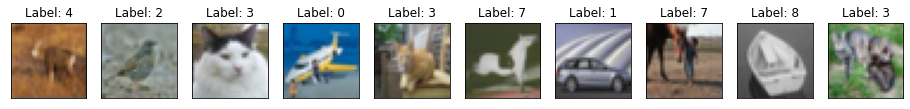

********************            10 Validation Images            ********************


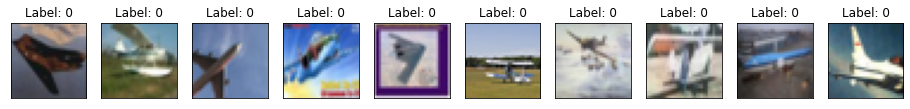

********************            10 Test Images            ********************


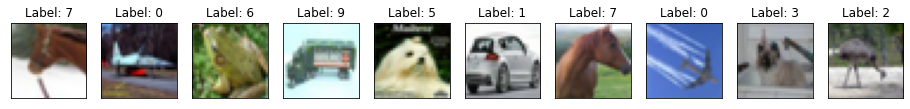

In [41]:
#@view_image(ds)
def view_image(ds, opttext = "", batch = 10):
# this function takes the dataset and automatically displays 10 figures
# the dataset has to be batches to see the images
  ds  = make_batched(ds, batch)

  image, label = next(iter(ds)) # extract 1 batch from the dataset
  image = image.numpy().astype("uint8")  #??  #if theres a better way to do this I'm all ears because it's costly
  label = label.numpy()   
  

  fig = plt.figure(figsize=(16, 16))
  for i in range(10):
    if i == 1:
        print("*"*20, " "*10, opttext, " "*10,  "*"*20)
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(image[i])
    ax.set_title(f"Label: {label[i]}")
    if i == 9:
      plt.pause(0.05)  # heck yea
      


view_image(train_A, opttext = "10 Training Images from Group A")
view_image(val, opttext = "10 Validation Images")
view_image(x_test, opttext = "10 Test Images")


To integrate `albumentations` into our tensorflow pipeline we can create two functions :  
- Pipeline to apply `augmentation`.
- a function that calls the above function and pass in our data through the pipeline.
We can then wrap our 2nd Function under `tf.numpy_function` .

### Define Albumentations "Transform" Augmentation Functions (transforms = Compose([ ... ])   ) 

In [42]:
#@title def augmentfunction(df_experimentalruns, run): { form-width: "20px" }
IMG_SIZE = 32

def augmentfunction(df_experimentalruns, run):
    
  # Instantiate augments

  cat_probability = 1
  cont_probability = 1
  random.seed(42)

  # Assign Continuous Factors Levels by Run -------------------------

  shift_limit_x_left =  df_experimentalruns.loc[run,"shiftX"]
  shift_limit_x_right = df_experimentalruns.loc[run,"shiftX"]  
  assert shift_limit_x_right >= shift_limit_x_left
  assert shift_limit_x_right <= 1  #more than one is damaging
  print("Shift X:  (", shift_limit_x_left, ",", shift_limit_x_right, ") or (",-shift_limit_x_right, ",", -shift_limit_x_left, ")" )

  shift_limit_y_left = df_experimentalruns.loc[run,"shiftY"]
  shift_limit_y_right = df_experimentalruns.loc[run,"shiftY"]  
  assert shift_limit_y_right >= shift_limit_y_left
  assert shift_limit_y_right < 1  #more than one is damaging
  print("Shift Y:  (", shift_limit_y_left, ",", shift_limit_y_right, ")or (", -shift_limit_y_right, ",", -shift_limit_y_left, ")")


  gamma_left =  df_experimentalruns.loc[run,"gamma"]     
  gamma_right = df_experimentalruns.loc[run,"gamma"]  
  assert gamma_right >= gamma_left
  print("Gamma:    (", gamma_left, ",", gamma_right, ")")

  zoom_out_left = -df_experimentalruns.loc[run,"zoomOut"]  
  zoom_out_right = -df_experimentalruns.loc[run,"zoomOut"] 
  assert zoom_out_right >= zoom_out_left
  print("ZoomOut:  (", zoom_out_left, ",", zoom_out_right, ")")


  zoom_in_left = df_experimentalruns.loc[run,"zoomin"]
  zoom_in_right = df_experimentalruns.loc[run,"zoomin"]
  assert zoom_in_right >= zoom_in_left
  assert zoom_in_right < 1.0
  print("ZoomIn:   (", zoom_in_left, ",", zoom_in_right, ")")



  noise_left = df_experimentalruns.loc[run,"noise"]             # df_factors["Noise"][df_experimentalruns.loc[run,"Noise"]])
  noise_right = df_experimentalruns.loc[run,"noise"]         #  need to change noise to larger number
  assert noise_right >= noise_left
  print("Noise:    (", noise_left, ",", noise_right, ")")


  ## Is blur of 7 too high? :-\ 
  if df_experimentalruns.loc[run,"blur"] == 0:
    blur_probability = 0
    # print("blur is 0")
    blur_left = 0
    blur_right = 0+1
  else:
    # print("blur is not 0")
    blur_probability = 1
    blur_left = df_experimentalruns.loc[run,"blur"]
    blur_right = df_experimentalruns.loc[run,"blur"]
  assert blur_right >= blur_left
  assert blur_right > 0  # must be an integer  #I can't see a dfference using 7 and 9!
  print("blur:     (", blur_left, ",", blur_right, ")")


  # Need to add Sharp to the menu of options
  sharp_left = df_experimentalruns.loc[run,"sharpen"]
  sharp_right = df_experimentalruns.loc[run,"sharpen"]
  assert sharp_right >= sharp_left
  print("sharp:    (", sharp_left, ",", sharp_right, ")")


  contrast_limit_left = df_experimentalruns.loc[run,"contrast"]
  contrast_limit_right = df_experimentalruns.loc[run,"contrast"]
  assert contrast_limit_right >= contrast_limit_left
  print("Contrast: (", contrast_limit_left, ",", contrast_limit_right, ")")


  brightness_limit_left = df_experimentalruns.loc[run,"brighten"]
  brightness_limit_right = df_experimentalruns.loc[run,"brighten"] 
  assert brightness_limit_right >= brightness_limit_left
  print("Bright:   (", brightness_limit_left, ",", brightness_limit_right, ")")

  darkness_limit_left = -df_experimentalruns.loc[run,"darken"] 
  darkness_limit_right = -df_experimentalruns.loc[run,"darken"]
  assert darkness_limit_right >= darkness_limit_left
  print("Darken:   (", darkness_limit_left, ",", darkness_limit_right, ")")


  rotate_left  = df_experimentalruns.loc[run,"rotate"]
  rotate_right = df_experimentalruns.loc[run,"rotate"]
  assert rotate_right >= rotate_left
  print("Rotate:   (", rotate_left, ",", rotate_right, ") or (",-rotate_right, ",", -rotate_left, ")" )


  crop_value = 32-df_experimentalruns.loc[run,"crop"]


  # Assign Categorical Factors Probabilities to make "on" or "off" -------------------------
  pHorizontalFlip =   df_experimentalruns.loc[run,"flipH"]
  print("pHorizontalFlip:   ", pHorizontalFlip)

  pVerticalFlip =     df_experimentalruns.loc[run,"flipV"]
  print("pVerticalFlip:     ", pVerticalFlip)

  pEqualize =          df_experimentalruns.loc[run,"equalize"]
  print("pEqualize:         ", pEqualize)

  pFancyPCA =          df_experimentalruns.loc[run,"fancyPCA"]
  print("pFancyPCA:         ", pFancyPCA)

  pChannelShuffle =   df_experimentalruns.loc[run,"channelShuffle"]
  print("pChannelShuffle:   ", pChannelShuffle)

  pElasticTransform =  df_experimentalruns.loc[run,"elasticTransform"]
  print("pElasticTransform: ", pElasticTransform)

  pToGray =            df_experimentalruns.loc[run,"togray"]
  print("pToGray:           ", pToGray)

  background_value = 0


  print(" ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \n\n")


  #transforms = A.Compose([
  list_of_transforms = [


      #1. Shift Horizontally Right or Shift Horizontally Left
      A.OneOf([
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, 
                                                  shift_limit_x=(shift_limit_x_left,shift_limit_x_right), 
                                                  scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value),    
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, 
                                                  shift_limit_x=(-shift_limit_x_right,-shift_limit_x_left), 
                                                  scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value)], 
              p=cont_probability),
      
      
      # 2 Shift VERTICALLY  up or down 
      A.OneOf([
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=(shift_limit_y_left,shift_limit_y_right), shift_limit_x=0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value),   
                A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=(-shift_limit_y_right, -shift_limit_y_left), shift_limit_x=0, scale_limit=0, border_mode=cv2.BORDER_CONSTANT, value=background_value)], 
              p =cont_probability),
      
      #3 NOISE ---------------------------------
      A.transforms.GaussNoise(var_limit=(noise_left,noise_right), p=cont_probability),  

      #4 BLUR
      A.transforms.GaussianBlur(blur_limit=(blur_left,blur_right), sigma_limit=(0.5,0.05), p=blur_probability),  #Blur
      
      #5 Sharpen 
      A.transforms.Sharpen(alpha=(sharp_left,sharp_right), lightness=(0.0, 0.0), p=cont_probability),  #AntiBlur keep lightness constant at 0?
        
      #6 Contrast
      A.transforms.RandomBrightnessContrast(brightness_limit=(0,0), contrast_limit=(contrast_limit_left,contrast_limit_right), p=cont_probability),       

      #7 Brightness
      A.transforms.RandomBrightnessContrast(brightness_limit=(brightness_limit_left,brightness_limit_right), contrast_limit=(0,0), p=cont_probability),      
      
      #8 Darkness
      A.transforms.RandomBrightnessContrast(brightness_limit=(darkness_limit_left,darkness_limit_right), contrast_limit=(0,0), p=cont_probability),  #darkness

      #9 GAMMA
      # A.transforms.RandomGamma(gamma_limit=(gamma_left,gamma_right), p=cont_probability),  
      

      #10 Zoom Out
      A.geometric.ShiftScaleRotate(rotate_limit=0,  shift_limit_y=0, shift_limit_x=0, scale_limit=(zoom_out_left,zoom_out_right), border_mode=cv2.BORDER_CONSTANT, value=background_value, p=cont_probability),    #Zoom Out safe: scale_limit=(-0.15,-0.1)

      #11  Rotate CW or CCW
      A.OneOf([
                    A.geometric.SafeRotate(limit=(rotate_left,rotate_right), border_mode=cv2.BORDER_CONSTANT, value=background_value),
                    A.geometric.SafeRotate(limit=(-rotate_right,-rotate_left), border_mode=cv2.BORDER_CONSTANT, value=background_value)], p=1),
      
      #12  Crop then Pad
      A.crops.transforms.CenterCrop(height=crop_value, width=crop_value,  p=cont_probability),       # Crop 24,24 is the extreme
      A.transforms.PadIfNeeded(min_height=32, min_width=32,  border_mode=cv2.BORDER_CONSTANT, value=background_value, p=1),

      # 13 ZoomIn
      A.geometric.ShiftScaleRotate(rotate_limit=0, shift_limit_y=0, shift_limit_x=0,
                                    scale_limit=(zoom_in_left,zoom_in_right), border_mode=cv2.BORDER_CONSTANT, value=background_value, p=cont_probability),  

      # 14 FlipH
      A.HorizontalFlip(p=pHorizontalFlip),
      
      # 15 FlipVert
      A.VerticalFlip(p=pVerticalFlip),
      
      #16 FANCY PCA
      A.transforms.FancyPCA(alpha=0.1, p=pFancyPCA),                    # FancyPCA Amount to perturn eigenvalues not Categorical
      
      #17 Elastic Transform
      A.geometric.ElasticTransform(alpha=0.1, sigma=0.001, alpha_affine=0.001, 
                                    same_dxdy=True, border_mode=cv2.BORDER_CONSTANT, 
                                    value=background_value, p=pElasticTransform),    #Seems more like a blur than a transform?
      
      # #Resize to 32x32 for crop
      # A.geometric.Resize(height=32, width=32, p=1),

      #18 Histogram Equalizer
      A.transforms.Equalize(p=pEqualize),  

      #19 CHANNELSHUFFLE
      A.transforms.ChannelShuffle(p=pChannelShuffle),  #this is prob going to ruin accuracy


      #20 Turn Everything Gray
      A.transforms.ToGray(p=pToGray)

    ] 
    
  return list_of_transforms

global no_transforms 

no_transforms = A.Compose([
         A.transforms.NoOp()
])

### Define another function "Augment_Function" to push images throguh list of "Transforms" to create augmented images

In [43]:
#@title aug_fn

#this function is being referenced a lot

def aug_fn(image, img_size ):
    data = {"image":image}
    
    aug_data = transforms(**data)
    
    aug_img = aug_data["image"]
    # aug_img = tf.cast(aug_img/255.0, tf.float32)
    # aug_img = tf.cast(aug_img/1.0, tf.float32)    #attempt
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    # aug_img = tf.cast(aug_img*255.0, tf.float32)

    return aug_img

def no_aug_fn(image, img_size):
    data = {"image":image}

    aug_data = no_transforms(**data)

    aug_img = aug_data["image"]
    # aug_img = tf.cast(img/255.0, tf.float32)  
    # aug_img = tf.cast(img/1.0, tf.float32)      #new attempt
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    # aug_img = tf.cast(aug_img*255.0, tf.float32)
    return aug_img

#### Define Process_Data function to returns augmented image andlabel

In [44]:
#@title process_data { form-width: "20px" }
def process_data(image, label, img_size,):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)  # was tf.float32
    return aug_img, label


def no_process_data(image, label, img_size,):
    no_aug_img = tf.numpy_function(func=no_aug_fn, inp=[image, img_size], Tout=tf.float32)   # was tf.float32
    return no_aug_img, label
    

#### Restoring dataset shapes. 
The datasets loses its shape after applying a tf.numpy_function, so this is necessary for the sequential model and when inheriting from the model class.

In [45]:
#@title set_shapes
def set_shapes(img, label, img_shape=(IMG_SIZE,IMG_SIZE,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

`Note`: 
Some `API's` of `tensorflow.keras.Model` might not work, if you dont map the dataset with the set_shapes function.

## Create New Training Group Data by Merging Un-Augmented with Augmented Data


In [46]:
#@ 

def unbatch_ds(batchedDataset):
  unbatch_ds = (tf.data.Dataset.unbatch(batchedDataset))
  return unbatch_ds


# unbatch_train_A = make_unbatched(train_A)

#as of 11/11/21 a 0521 added transforms to try to make my run_through_runs 
#   function pass the transforms to the augment functions

def augment_data(dataset, process, dataset_text=""):
  dataset_new = dataset.map(partial(process, img_size=IMG_SIZE,))
  dataset_new = dataset_new.map(set_shapes)
  # dataset_new = dataset_new.batch(batchsize)
  # get_min_max(dataset,      text= dataset_text)
  # get_min_max(dataset_new,  text=str("New" + dataset_text))
  return dataset_new



In [47]:
#@title
# #@title View No Augmentation Dataset { form-width: "20%" }
# train_A_noalb = augment_data(dataset = unbatch_train_A, 
#                              process= no_process_data,
#                             #  batchsize=100,
#                              dataset_text = "train_A_noalb")

# #@title View No Augmentation Dataset { form-width: "20%" }
# train_B_noalb = augment_data(dataset = make_unbatched(train_B), 
#                              process= no_process_data,
#                             #  batchsize=100,
#                              dataset_text = "train_A_noalb")
# pretty_display_of_dataset(train_B_noalb)


In [48]:
#@title PrettyViewofData Function { form-width: "30px" }
def pretty_display_of_dataset(ds, dstitle = "Dataset title", opttext = ""):
  view_image(ds, dstitle)  #defaults to batch size 10 
  num = ds.reduce(np.int64(0), lambda x,_ : x + 1).numpy()  # returns 25, but 25*100batches = 2500
  
  if check_if_batched(ds):
    print("Total: ", num, " batches in this dataset: \n\n\n", opttext )

    if num > 5:
      num = 5
      print("Showing first 10 images of the first five batches")
    
    batch1 = ds.take(1)
    
    view_image(batch1, str("Batch1 of "+dstitle)) 
    print("Batch ",1, "Class Count:", count_cifar10_class(batch1), "\n")  

    for i in range(2,num+1):      
      batch2 = ds.skip(i-1).take(1)
     
      name_of_batch = str("Batch" + str(i)+" of "+ dstitle)
      view_image(batch2, name_of_batch )   
      print("Batch ", i, "Class Count:", count_cifar10_class(batch2), "\n")
      # do I need to clear out batch2 here?

  else:
    print("Total: ", num, " images in this dataset", opttext )
    print("Total Class Count:", count_cifar10_class(ds), "\n")

  
  print("**********************************************************************************************")

# pretty_display_of_dataset(train_A, "Train_A")  



#### View_Num_Images Function, default num = 20

In [49]:
#@title
def view_num_images(ds, num = 20):

  ds = make_batched(ds, batchnum = num)

  image, label = next(iter(ds)) # extract 1 batch from the dataset
  image = image.numpy().astype("uint8")  #??  #if theres a better way to do this I'm all ears because it's costly
  label = label.numpy()   
  
  fig = plt.figure(figsize=(10, 10))

  for i in range(num):
      ax = fig.add_subplot(1, num, i+1, xticks=[], yticks=[])
      ax.imshow(image[i])
      ax.set_title(f"Lbl: {label[i]}")
      

In [50]:
#@title show_confusion_matrix_wo_diagonal { form-width: "2px" }
def show_confusion_matrix_wo_diagonal(test_labels, predictions, CLASSES, run=999):
    """Compute confusion matrix without diagonal."""
    confusion = sklearn.metrics.confusion_matrix(test_labels, predictions,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    confusion_matrix_wo_diagonal= np.array(confusion)-np.identity(confusion.shape[0])*np.diag(confusion)

    axis_labels = CLASSES

    ax = sns.heatmap(
        confusion_matrix_wo_diagonal, xticklabels=axis_labels, yticklabels=axis_labels, 
        cmap='Blues', annot=True, square=True, fmt='.0f', cbar = False)

    plt.title(str("Confusion Matrix without Diagonal of Run " + str(run)))
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    print("Summing down the rows, for Predictions of each Class that were wrong: ", confusion_matrix_wo_diagonal.sum(axis=0))

    # for i in range(10):
    print("For example, the model predicted a  label 4 (deer) on a true  ", np.argmax(confusion_matrix_wo_diagonal[:,4])," a total of ", max(confusion_matrix_wo_diagonal[:,4]), "times")

    print("Summing across the columns, for total number of that True Class misidentified: ", confusion_matrix_wo_diagonal.sum(axis=1))
    
    print("For example, the model misclassified true 4's (deer) as label  ", np.argmax(confusion_matrix_wo_diagonal[4,:]), CLASSES[np.argmax(confusion_matrix_wo_diagonal[4,:])], " a total of ", max(confusion_matrix_wo_diagonal[4,:]), "times")





In [51]:
#@title
# The augmented data returns floats between 0 and 1
# The unaugmented data is integers uint8 between 0 and 255 
CLASSES = info.features['label'].names

# This may help me one day with trying to get into the ID of each batch/mislabelled image
# info.features['id']


In [52]:
#@title cache_prefetch_group(train_tf, shuffle=5000, batch =0, SEED = 42) { form-width: "4px" }

def cache_prefetch_group(train_tf, SHUFFLE=5000, batch = 0, SEED = 42):
    # I choose to shuffle the entire deck, which probably adds time, but I want to ensure mixed unaugmented and augmented
    train_tf = train_tf.shuffle(SHUFFLE, reshuffle_each_iteration=False)  # I took out seed=seed to get variety with each reshuffle
    # as of 11/10/21 9 pm I changed reshuffle_each_iteration to False, because I think that will ensure I get at least all of the dataset images in a batch
    # as of 11/11/21 4 Am I changed reshuffle_each_iteration back to True, because train_B imagesdidnt look sufficiently shuffled in a batch

    train_tf = train_tf.cache().prefetch(buffer_size=AUTOTUNE)
    if batch != 0:
      train_tf = train_tf.batch(batch)  # ??moved Batch to inside ModelTraining loop to prevent Double-Batching-Weirdness
    return train_tf 


#### Make Sortedd Test Accuracy Dictionary  Functions

In [53]:
#@title make_accuracy_dictionary(cm_norm)
# define function to print out all the labels amd accuracies on the diagonal of the confusion matrix
def make_accuracy_dictionary(cm_norm):
  dictionary = {}
  for i in range(10):
    dictionary[CLASSES[i]] = cm_norm[i,i]
    
  # sort the values - ty SO https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value/613218#613218
  for w in sorted(dictionary, key=dictionary.get, reverse=True):
    print(w, dictionary[w])
  return dictionary 


# define function to print out all the labels amd accuracies on the off diagonal of the confusion matrix
# to indicate the most common mistakes:

# def make_misclassification_dictionary(cm):
#   dictionary = {}

#   for i in range(10):
#     dictionary_cm_diagonal_labels[CLASSES[i]] = cm_norm[i,i]
    
#   # sort the values - ty SO https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value/613218#613218
#   for w in sorted(dictionary_cm_diagonal_labels, key=dictionary_cm_diagonal_labels.get, reverse=True):
#     print(w, dictionary_cm_diagonal_labels[w])
#   return dictionary_cm_diagonal_labels 

# Run, Model, Test, Capture all 50 Designed Runs

In [54]:
#@title
## This is code found on SO to see whether the dataset is batched or not
#  
# train_A_alb.batch(num_alb).__class__.__name__

# new_train_A = new_train_A.batch(10)

# new_train_A._input_dataset.__class__.__name__

# new_train_A = (tf.data.Dataset.unbatch(new_train_A))

In [55]:
def count_images(ds, opttext = ""):
  # The number of images present in the new train_A_alb set is equal to the original set
  num_images = ds.reduce(np.int64(0), lambda x,_ : x + 1).numpy()  # returns 10 bc no batches
  print(" There are ** ", num_images, "** total images in " ,  opttext)
  return num_images

Original Working Code for Train_A before it became a function:

In [56]:
#@title
 
# # ---------------------------------------------------------------------------
# # Create Training-Group-Specific Dictionary to collect important metrics at the end of all runs 
# # ----------------------------------------------------------------------------
# Group_A_Runs = {}   #dictionary

# # Group_A_Runs[run] = {'TestAccuracy': 0}


# # ---------------------------------------------------------------------------
# # When in troubleshooting or refining/code mode, I only run 5 experimental runs but
# # when running the full design matrix, ensure ENDRUNS = 51  (50 + baseline run)
# # the for loop will go through each run like this: df_experimentalruns.loc[run, "WhateverFactors"]:
# # ----------------------------------------------------------------------------

# ENDRUNS = 51
# # assert ENDRUNS == 50

# for run in range(0,ENDRUNS): 

#   # run = run + 1  # commented out after I added a Do-Nothing Run, I now have a real index 0 in the test-run-matrix  
#   print("\n", (str(run) + " ")*50)
#   print("\n   Begin Run: ", run)
#   print("\n", (str(run) + " ")*50)
  

#   #Use my vanilla CNN model function to build a  model with a certain dropout level
#   model = makemodel(DROPOUT=df_experimentalruns.loc[run,'dropout'])

# # ------------------------------------
# # Create Run-Specific Transformations 
# # ------------------------------------

#   # build  Albumentations list of transformations by passing each run's required parameters 
#   list_of_transforms = augmentfunction( df_experimentalruns, run )

#   # pass the list of transforms to Albumentations Compose function
#   transforms = A.Compose(transforms = list_of_transforms)
  
# # ------------------------------------
# # Create Augmented Dataset train_A_alb 
# # ------------------------------------
  
#   # Augment the unbatched Training_Group_A through the Process_Data Function to create train_A_alb (albu = albumentations/augmentations)
#   train_A_alb = augment_data(dataset = unbatch_train_A, process= process_data, dataset_text = "Augmented Dataset")
  
# # ------------------------------------
# # Print the number of total images in each unbatched dataset train_A_alb, and train_A_noalb 
# # -----------------------------------

#   # The number of images present in the new train_A_alb set is equal to the original set
#   # num_alb = count_images(train_A_alb, opttext="Augmented-train-a, before batching")
#   # print("Train_A_Alb has class count:", count_cifar10_class(train_A_alb))
#   # pretty_display_of_dataset(train_A_noalb, "Train Set A - NO Augmentations", opttext = "before batching")


#   # The number of images present in the new train_A_alb set is equal to the original set
#   # count_images(train_A_noalb, "Not-Augmented Train_A, before batching")
#   # print("Train_A_No_Augmentations has class count:", count_cifar10_class(train_A_noalb))
#   # pretty_display_of_dataset(train_A_alb, "Train Set A - Augmentations", opttext = "before batching")


#   # ------------------------------------
#   # Merge/Concatenate Augmented and Non-Augmented into dataset: NEW_TRAIN_A,  then return the total count of images 
#   # ------------------------------------
#   new_train_A = train_A_noalb.concatenate(train_A_alb)
#   # at 9pm I switched the order of these because I think I'm not seeing no_aug until the very last batches? I need to shuffle the batches....
#   #pretty_display_of_dataset(new_train_A, "New Training Set A - Merged with the Augmented, and Non-Augmented", opttext = "before batching")

# # ------------------------------------
# # Batch Consolidated Dataset  
# # ------------------------------------
#   new_train_A_batch = 250 
#   tot_new_train_A = 5000 # should be 250*10*2 = 5000

#   new_train_A = cache_prefetch_group(new_train_A,  SHUFFLE=tot_new_train_A, batch=new_train_A_batch, SEED = seed)

# # ------------------------------------
# # Send Consolidated Dataset through Model & View Model Training Statistics Output 
# # ------------------------------------
#   # take the created model from passing dropout, and pass the training data through it
#   modeltrained = trainmodel(MODEL = model, TRAININGDATA= new_train_A)

# # ------------------------------------
# # See pictures that were sent through model, up to five batches
# # ------------------------------------
#   pretty_display_of_dataset(ds= new_train_A, dstitle="New Training Set A", opttext= "after Shuffling and Batching") 


# # ------------------------------------
# # Test Statistics for Model 
# # ------------------------------------
#   # Retrieve the TEst Loss and Accuracy after training is complete
#   loss, acc = modeltrained.evaluate(x_test, verbose=0) 
#   print("TestLoss: ", loss, " TestAcc:", acc)



# # ------------------------------------
# # Get Predictions from Test Set to use in Confusion Matrix
# # ------------------------------------

#   #Get the predictions of Y_hat from passing X_Test into the model
#   y_pred = modeltrained.predict(x_test)

#   # The Y_Hats are y_pred of continuous probabilities into a 1-coded label vectors
#   y_pred_1hot = np.argmax(y_pred, axis=1)
#   cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ) 
#   cm_norm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize ='true' ) 
#   # disp = ConfusionMatrixDisplay(cm, display_labels=['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']).plot()
#   make_accuracy_dictionary(cm_norm)

#   # confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
#   # show_confusion_matrix(y_test, y_pred_1hot, CLASSES = CLASSES)

# # ------------------------------------
# # Save every 10 runs and final file
# # ------------------------------------
#   Group_A_Runs[run] = {'TestAccuracy': acc, 'TestLoss': loss, 'CM': cm, 'CM_norm': cm_norm}
  
#   if run != 0:
#     if run == 50:      
# # ------------------------------------
# # Save  final file
# # ------------------------------------  
#       with open('runs_groupA_final.pkl', 'wb') as fid:
#           pickle.dump(Group_A_Runs, fid)
#           files.download('runs_groupA_final.pkl')
          
#           timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
#           print("Final Download attempted : ", timetoprint, " (subtract 3-hours from Hour), and file is called runs_groupA_final.pkl ")
# # ------------------------------------
# # Save  intermittent files
# # ------------------------------------  

#     if run%12 == 0:  #When i =12,24,36, save/download file
#       with open('runs_groupA.pkl', 'wb') as fid:
#           pickle.dump(Group_A_Runs, fid)
#           files.download('runs_groupA.pkl')
          
#           timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
#           print("Download attempted : ", timetoprint, " (subtract 3-hours from Hour), and file is called runs_groupA.pkl ")

 

### Defining all the no_augmentation groups before model-building-and-testing

In [57]:

# I am having trouble defining no_augmentation datasets inside the for-loop so i decided to define them outside the for-loop
# ------------------------------------
# Create Non-Augmented Dataset train_A_noalb 
# ------------------------------------
# until i figure out a better way , this is my way of ensuring that the unaugmented dataset is compatible datatype with that augmented one
def make_noalb(ds, dstitle):
  train_X_noalb = augment_data(dataset = make_unbatched(ds), process= no_process_data, dataset_text = str("TrainingGroup" + dstitle+ "NotAugmented"),)
  return train_X_noalb

# train_B_noalb = augment_data(dataset = make_unbatched(train_B), process= no_process_data, dataset_text = "Train_BNotAugmented",  passtransforms=no_transforms)
# print("train_B_noalb created")
# pretty_display_of_dataset(train_B_noalb, "noAugmentations") 



train_A_noalb = make_noalb(train_A, "A")
train_B_noalb = make_noalb(train_B, "B")

train_C_noalb = make_noalb(train_C, "C")
train_D_noalb = make_noalb(train_D, "D")

train_E_noalb = make_noalb(train_E, "E")
train_F_noalb = make_noalb(train_F, "F")

train_G_noalb = make_noalb(train_G, "G")
train_H_noalb = make_noalb(train_H, "H")

train_I_noalb = make_noalb(train_I, "I")
train_J_noalb = make_noalb(train_J, "J")

In [58]:
def run_through_runs(ds, ds_noalb, dstitle = "X", showpictures=True):
  filename = "runs_Group" + dstitle
  print("filename will be: ", filename, ".pkl")
  originalfilename = filename
  # ---------------------------------------------------------------------------
  # Create Training-Group-Specific Dictionary to collect important metrics at the end of all runs 
  # ----------------------------------------------------------------------------
  Group_X_Runs = {}   #dictionary
  # Group_X_Runs[run] = {'TestAccuracy': 0}


  # ---------------------------------------------------------------------------
  # For Loop of Runs
  # when running the full design matrix, ensure ENDRUNS = 51  (50 + baseline run)
  # the for loop will go through each run like this: df_experimentalruns.loc[run, "WhateverFactors"]:
  # ----------------------------------------------------------------------------

  ENDRUNS = 51
  # assert ENDRUNS == 51

  for run in range(0,51): 
    filename = originalfilename  #reset so you dont get Downloading "runs_GroupA.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl.pkl"


    # run = run + 1  # commented out after I added a Do-Nothing Run, I now have a real index 0 in the test-run-matrix  
    print("\n", (str(run) + " ")*50)
    print("\n   Begin Run: ", run)
    print("\n", (str(run) + " ")*50, "\n")
    

    #Use my vanilla CNN model function to build a  model with a certain dropout level
    model = makemodel(DROPOUT=df_experimentalruns.loc[run,'dropout'])

    # ------------------------------------
    # Create Run-Specific Transformations 
    # ------------------------------------

    # build  Albumentations list of transformations by passing each run's required parameters 
    list_of_transforms = augmentfunction( df_experimentalruns, run )

    # pass the list of transforms to Albumentations Compose function
    global transforms 
    transforms = A.Compose(list_of_transforms)

    
    # ------------------------------------
    # Create Augmented Dataset train_A_alb 
    # ------------------------------------
    
    # Augment the unbatched Training_Group_A through the Process_Data Function to create train_A_alb (albu = albumentations/augmentations)
    train_X_alb = augment_data(dataset = ds, process= process_data, dataset_text = "Augmented Dataset", )
    # print("train_X_alb created")
    # pretty_display_of_dataset(train_X_alb, "Augmentations")

    # # ------------------------------------
    # # Create Non-Augmented Dataset train_A_noalb 
    # # ------------------------------------
    # # until i figure out a better way , this is my way of ensuring that the unaugmented dataset is compatible datatype with that augmented one

    # train_X_noalb = augment_data(dataset = ds, 
    #                          process= no_process_data,
    #                         #  batchsize=100,
    #                          dataset_text = str(dstitle+"NotAugmented"), passtransforms=no_transforms)
    # print("train_X_noalb created")
    # pretty_display_of_dataset(train_X_noalb, "noAugmentations") 


    # ------------------------------------
    # Print the number of total images in each unbatched dataset train_A_alb, and train_A_noalb 
    # -----------------------------------
    # removed because counting the items in a dataset is insanely time-expensive, unfortunately



    # ------------------------------------
    # Merge/Concatenate Augmented and Non-Augmented into dataset: NEW_TRAIN_A,  then return the total count of images 
    # ------------------------------------

    new_train_X = ds_noalb.concatenate(train_X_alb)
    # print("new_train_X created")
    # print(new_train_X)
    # pretty_display_of_dataset(new_train_X, "newTrainX") 

    # at 9pm I switched the order of these because I think I'm not seeing no_aug until the very last batches? I need to shuffle the batches....
    #pretty_display_of_dataset(new_train_A, "New Training Set A - Merged with the Augmented, and Non-Augmented", opttext = "before batching")

    # ------------------------------------
    # Batch Consolidated Dataset  
    # ------------------------------------
    new_train_X_batch = 250 
    tot_new_train_X = 5000 # should be 250*10*2 = 5000

    new_train_X= cache_prefetch_group(new_train_X,  SHUFFLE=tot_new_train_X, batch=new_train_X_batch, SEED = seed)
    # print("new_train_X batched")
    # ------------------------------------
    # Send Consolidated Dataset through Model & View Model Training Statistics Output 
    # ------------------------------------
    # take the created model from passing dropout, and pass the training data through it
    print("Training Model... ")
    modeltrained = trainmodel(MODEL = model, TRAININGDATA= new_train_X)

    # ------------------------------------
    # See pictures that were sent through model, up to five batches
    # ------------------------------------
    if showpictures == True:
      pretty_display_of_dataset(new_train_X, dstitle, ) 


    # ------------------------------------
    # Test Statistics for Model 
    # ------------------------------------
    # Retrieve the TEst Loss and Accuracy after training is complete
    loss, acc = modeltrained.evaluate(x_test, verbose=0) 
    print("TestLoss: ", loss, " TestAcc:", acc)



    # ------------------------------------
    # Get Predictions from Test Set to use in Confusion Matrix
    # ------------------------------------

    #Get the predictions of Y_hat from passing X_Test into the model
    y_pred = modeltrained.predict(x_test)

    # The Y_Hats are y_pred of continuous probabilities into a 1-coded label vectors
    y_pred_1hot = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ) 
    cm_norm = confusion_matrix(y_true = y_test, y_pred = y_pred_1hot,  labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize ='true' ) 
    # disp = ConfusionMatrixDisplay(cm, display_labels=['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']).plot()
    make_accuracy_dictionary(cm_norm)

    # confusion_matrix(y_true = y_test, y_pred = y_pred_1hot )
    #def show_confusion_matrix_wo_diagonal(test_labels, predictions, CLASSES):
    show_confusion_matrix_wo_diagonal(y_test, y_pred_1hot, CLASSES = CLASSES, run=run)

    # ------------------------------------
    # Save every 10 runs and final file
    # ------------------------------------
    Group_X_Runs[run] = {'TestAccuracy': acc, 'TestLoss': loss, 'CM': cm, 'CM_norm': cm_norm}
    
    

    # I cannot figure out why it downloads my files twice
    if run != 0:

      if run == 50: 
        # print("run == 50 is true")    
        filename = originalfilename + "_final.pkl"   
        with open(filename, 'wb') as fid:
          pickle.dump(Group_X_Runs, fid)
          files.download(filename)
          
          timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
          print("Final Download attempted : ", timetoprint, " (subtract ~5-hours for local Hour), and file is called ", filename)

        # end write
      # end if
      # if run != 50:
      #   # ------------------------------------
      #   # Save  intermittent files
      #   # ------------------------------------  
      #   if run%14 == 0:  #When i save/download file  14 28 42 
      #     filename = str(originalfilename + ".pkl")
      #     with open(filename, 'wb') as fid:
      #       pickle.dump(Group_X_Runs, fid)
      #       files.download(filename)
            
      #       timetoprint = datetime.datetime.now().strftime("%a, %d %B %Y %H:%M:%S")
      #       print("Download attempted : ", timetoprint, " (subtract ~5-hours for local Hour), and file is called",  filename)
          #
        #
      #
    
 

In [59]:
# run_through_runs(ds=make_unbatched(train_A), ds_noalb=train_A_noalb, dstitle="A" , showpictures= True)  #complete 11/10/21

filename will be:  runs_GroupB .pkl

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

   Begin Run:  0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 0 , 0 )
blur:     ( 0 , 1 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright:   ( 0.0 , 0.0 )
Darken:   ( -0.0 , -0.0 )
Rotate:   ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:    0
pVerticalFlip:      0
pEqualize:          0
pFancyPCA:          0
pChannelShuffle:    0
pElasticTransform:  0
pToGray:            0
 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 


Training Model... 


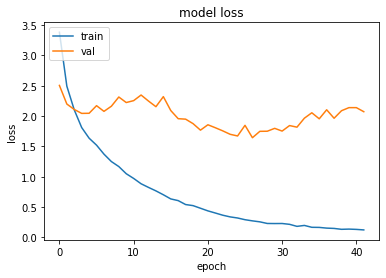

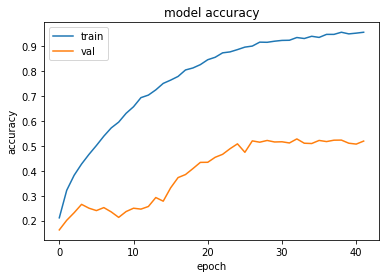

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  26 when  Val Loss was:  1.6435271501541138 , and Val Acc happened to be 0.5202000141143799
Additionally, the best val acc epoch happened to be  32 when val acc was:  0.5281000137329102 and Val Loss happened to be  1.8174715042114258
TestLoss:  1.618311882019043  TestAcc: 0.5184000134468079
frog 0.77
ship 0.683
truck 0.583
airplane 0.551
horse 0.546
deer 0.541
automobile 0.506
dog 0.494
cat 0.319
bird 0.191


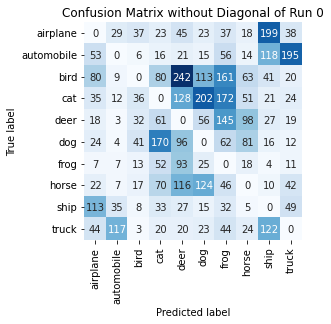

Summing down the rows, for Predictions of each Class that were wrong:  [396. 223. 193. 525. 788. 596. 755. 372. 558. 410.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  242.0 times
Summing across the columns, for total number of that True Class misidentified:  [449. 494. 809. 681. 459. 506. 230. 454. 317. 417.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  145.0 times

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

   Begin Run:  1

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:    ( 24 , 24 )
blur:     ( 7 , 7 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright:   ( 0.0 , 0

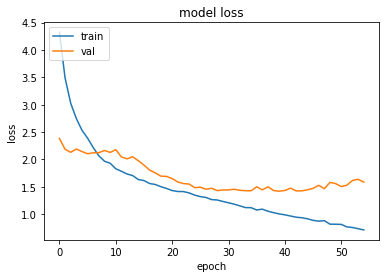

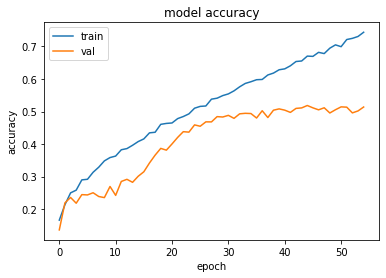

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  39 when  Val Loss was:  1.4179928302764893 , and Val Acc happened to be 0.5080999732017517
Additionally, the best val acc epoch happened to be  44 when val acc was:  0.5184999704360962 and Val Loss happened to be  1.4432311058044434
TestLoss:  1.4054394960403442  TestAcc: 0.5030999779701233
frog 0.78
automobile 0.64
airplane 0.602
truck 0.585
ship 0.55
horse 0.477
dog 0.456
deer 0.404
bird 0.306
cat 0.231


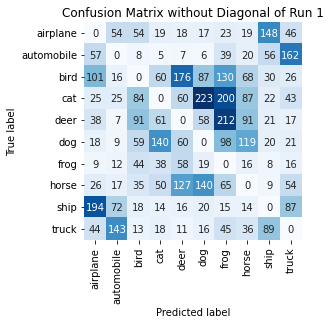

Summing down the rows, for Predictions of each Class that were wrong:  [512. 355. 406. 405. 533. 586. 827. 470. 403. 472.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  176.0 times
Summing across the columns, for total number of that True Class misidentified:  [398. 360. 694. 769. 596. 544. 220. 523. 450. 415.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  212.0 times

 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

   Begin Run:  2

 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:    ( 0 , 0 )
blur:     ( 3 , 3 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright:   ( 0

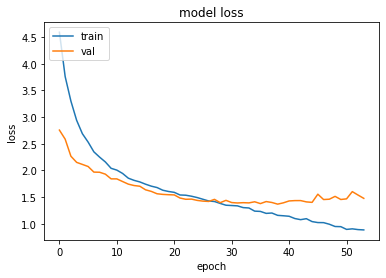

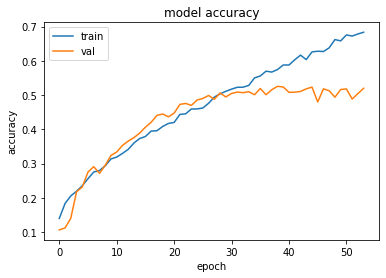

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  38 when  Val Loss was:  1.3676677942276 , and Val Acc happened to be 0.525600016117096
Additionally, the best val acc epoch happened to be  38 when val acc was:  0.525600016117096 and Val Loss happened to be  1.3676677942276
TestLoss:  1.3365837335586548  TestAcc: 0.5200999975204468
frog 0.759
truck 0.633
ship 0.625
airplane 0.559
automobile 0.557
horse 0.526
dog 0.516
deer 0.446
bird 0.313
cat 0.267


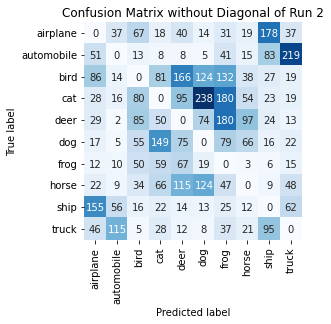

Summing down the rows, for Predictions of each Class that were wrong:  [446. 264. 405. 481. 592. 619. 752. 325. 461. 454.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  166.0 times
Summing across the columns, for total number of that True Class misidentified:  [441. 443. 687. 733. 554. 484. 241. 474. 375. 367.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  180.0 times

 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

   Begin Run:  3

 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 0 , 0 )
blur:     ( 0 , 1 )
sharp:    ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0.2 )
Brigh

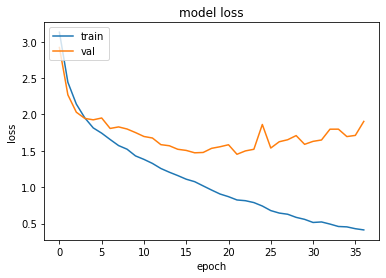

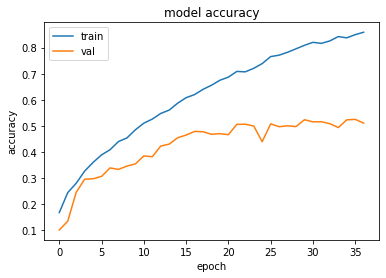

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  21 when  Val Loss was:  1.4525691270828247 , and Val Acc happened to be 0.5059999823570251
Additionally, the best val acc epoch happened to be  35 when val acc was:  0.5250999927520752 and Val Loss happened to be  1.7121752500534058
TestLoss:  1.417755126953125  TestAcc: 0.5023999810218811
ship 0.734
truck 0.65
frog 0.634
deer 0.631
horse 0.566
automobile 0.494
dog 0.394
airplane 0.393
cat 0.276
bird 0.252


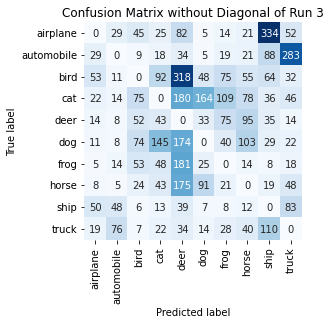

Summing down the rows, for Predictions of each Class that were wrong:  [ 211.  213.  345.  449. 1217.  392.  389.  439.  723.  598.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  318.0 times
Summing across the columns, for total number of that True Class misidentified:  [607. 506. 748. 724. 369. 606. 366. 434. 266. 350.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  95.0 times

 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

   Begin Run:  4

 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma:    ( 110 , 110 )
ZoomOut:  ( -0.08 , -0.08 )
ZoomIn:   ( 0.08 , 0.08 )
Noise:    ( 12 , 12 )
blur:     ( 3 , 3 )
sharp:    ( 0.05 , 0.05 )
Contr

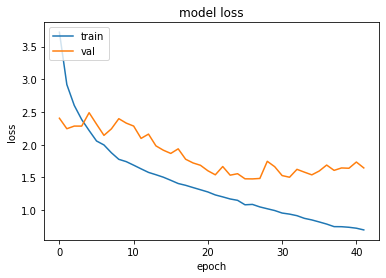

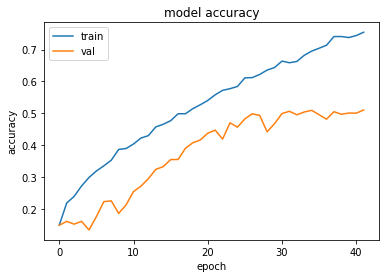

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  26 when  Val Loss was:  1.4762606620788574 , and Val Acc happened to be 0.4984999895095825
Additionally, the best val acc epoch happened to be  41 when val acc was:  0.510200023651123 and Val Loss happened to be  1.644136667251587
TestLoss:  1.4397257566452026  TestAcc: 0.5023000240325928
frog 0.759
ship 0.734
truck 0.672
deer 0.536
airplane 0.526
automobile 0.496
horse 0.49
dog 0.377
bird 0.277
cat 0.156


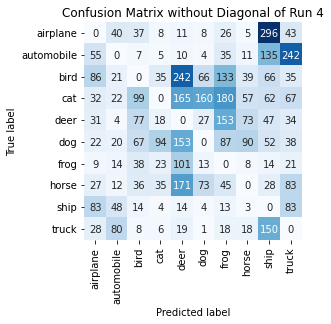

Summing down the rows, for Predictions of each Class that were wrong:  [373. 261. 383. 228. 886. 356. 690. 304. 850. 646.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  242.0 times
Summing across the columns, for total number of that True Class misidentified:  [474. 504. 723. 844. 464. 623. 241. 510. 266. 328.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  153.0 times

 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 

   Begin Run:  5

 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.08 , 0.08 )
Noise:    ( 0 , 0 )
blur:     ( 7 , 7 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright:   (

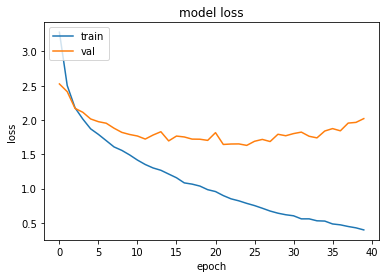

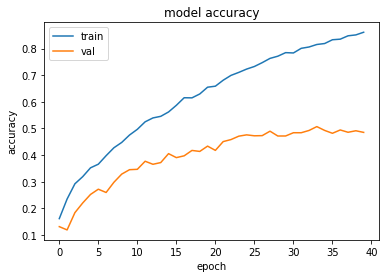

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  24 when  Val Loss was:  1.63036048412323 , and Val Acc happened to be 0.4758000075817108
Additionally, the best val acc epoch happened to be  33 when val acc was:  0.5067999958992004 and Val Loss happened to be  1.7398760318756104
TestLoss:  1.5831717252731323  TestAcc: 0.48539999127388
truck 0.738
frog 0.712
ship 0.643
deer 0.487
dog 0.477
horse 0.467
cat 0.43
automobile 0.421
airplane 0.349
bird 0.13


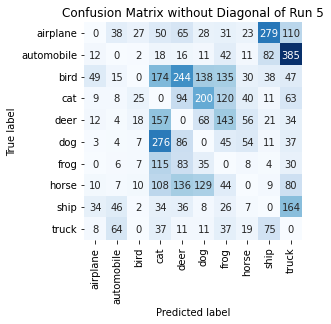

Summing down the rows, for Predictions of each Class that were wrong:  [137. 192.  98. 969. 771. 628. 623. 248. 530. 950.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  244.0 times
Summing across the columns, for total number of that True Class misidentified:  [651. 579. 870. 570. 513. 523. 288. 533. 357. 262.]
For example, the model misclassified true 4's (deer) as label   3 cat  a total of  157.0 times

 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

   Begin Run:  6

 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 24 , 24 )
blur:     ( 7 , 7 )
sharp:    ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0.0 )
Bright

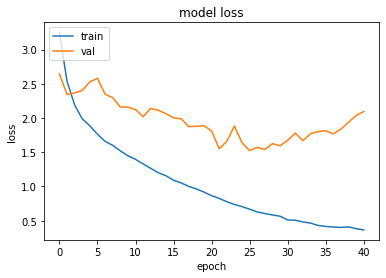

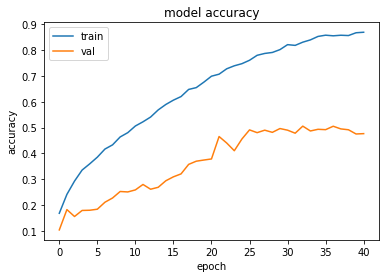

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  25 when  Val Loss was:  1.5244451761245728 , and Val Acc happened to be 0.491100013256073
Additionally, the best val acc epoch happened to be  32 when val acc was:  0.5055999755859375 and Val Loss happened to be  1.668123483657837
TestLoss:  1.4839911460876465  TestAcc: 0.5105000138282776
ship 0.705
frog 0.67
automobile 0.559
horse 0.557
dog 0.523
airplane 0.518
deer 0.45
truck 0.433
bird 0.404
cat 0.286


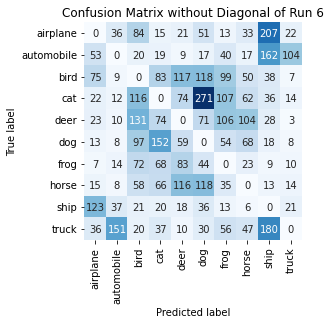

Summing down the rows, for Predictions of each Class that were wrong:  [367. 285. 619. 534. 507. 756. 523. 410. 691. 203.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  117.0 times
Summing across the columns, for total number of that True Class misidentified:  [482. 441. 596. 714. 550. 477. 330. 443. 295. 567.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  131.0 times

 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 

   Begin Run:  7

 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:    ( 24 , 24 )
blur:     ( 0 , 1 )
sharp:    ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0.0 )
Bri

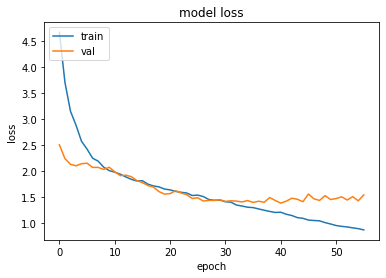

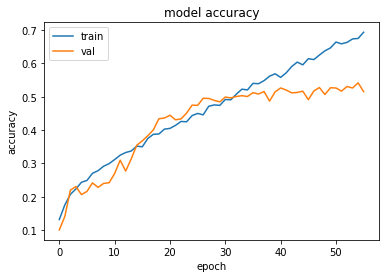

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  40 when  Val Loss was:  1.3811503648757935 , and Val Acc happened to be 0.5263000130653381
Additionally, the best val acc epoch happened to be  54 when val acc was:  0.5415999889373779 and Val Loss happened to be  1.425919771194458
TestLoss:  1.3446718454360962  TestAcc: 0.5199999809265137
frog 0.695
ship 0.686
automobile 0.631
horse 0.618
truck 0.538
deer 0.532
dog 0.517
airplane 0.4
bird 0.313
cat 0.27


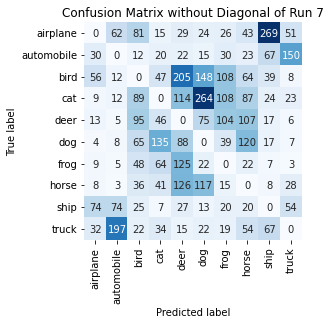

Summing down the rows, for Predictions of each Class that were wrong:  [235. 378. 473. 409. 751. 700. 469. 540. 515. 330.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  205.0 times
Summing across the columns, for total number of that True Class misidentified:  [600. 369. 687. 730. 468. 483. 305. 382. 314. 462.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  107.0 times

 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

   Begin Run:  8

 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 24 , 24 )
blur:     ( 7 , 7 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright:   ( 

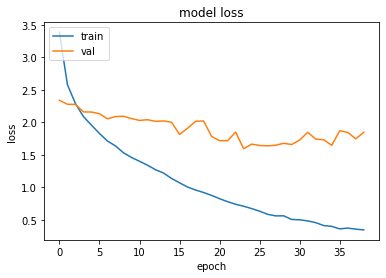

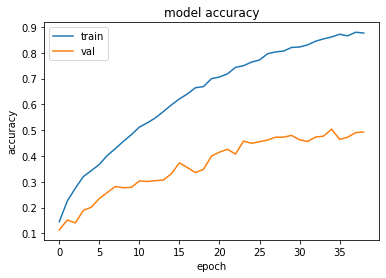

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  23 when  Val Loss was:  1.5933499336242676 , and Val Acc happened to be 0.4577000141143799
Additionally, the best val acc epoch happened to be  34 when val acc was:  0.5040000081062317 and Val Loss happened to be  1.645692229270935
TestLoss:  1.5542755126953125  TestAcc: 0.4738999903202057
frog 0.847
truck 0.576
airplane 0.546
ship 0.539
deer 0.518
horse 0.505
automobile 0.362
dog 0.311
bird 0.271
cat 0.264


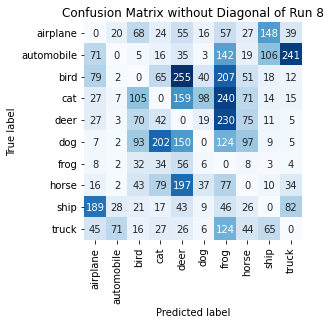

Summing down the rows, for Predictions of each Class that were wrong:  [ 469.  137.  453.  506.  976.  234. 1247.  418.  384.  437.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  255.0 times
Summing across the columns, for total number of that True Class misidentified:  [454. 638. 729. 736. 482. 689. 153. 495. 461. 424.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  230.0 times

 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 

   Begin Run:  9

 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma:    ( 110 , 110 )
ZoomOut:  ( -0.08 , -0.08 )
ZoomIn:   ( 0.08 , 0.08 )
Noise:    ( 12 , 12 )
blur:     ( 3 , 3 )
sharp:    ( 0.05 , 0.05 )
Contr

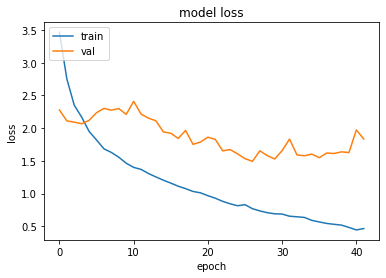

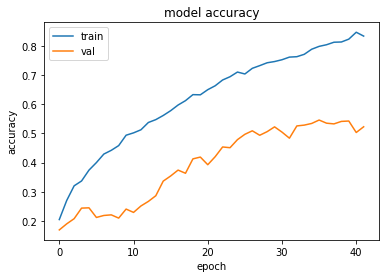

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  26 when  Val Loss was:  1.4929412603378296 , and Val Acc happened to be 0.5087000131607056
Additionally, the best val acc epoch happened to be  35 when val acc was:  0.5455999970436096 and Val Loss happened to be  1.5484713315963745
TestLoss:  1.4545522928237915  TestAcc: 0.5214999914169312
frog 0.872
ship 0.787
automobile 0.626
truck 0.593
horse 0.498
airplane 0.466
deer 0.449
dog 0.338
cat 0.333
bird 0.253


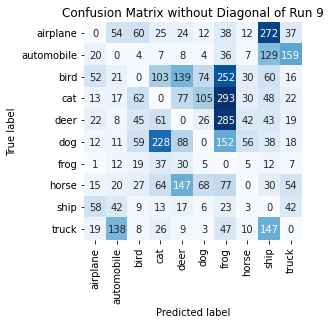

Summing down the rows, for Predictions of each Class that were wrong:  [ 212.  323.  293.  564.  539.  303. 1203.  195.  779.  374.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  147.0 times
Summing across the columns, for total number of that True Class misidentified:  [534. 374. 747. 667. 551. 662. 128. 502. 213. 407.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  285.0 times

 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 

   Begin Run:  10

 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 

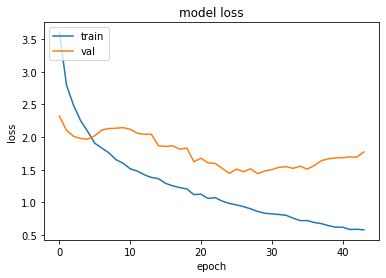

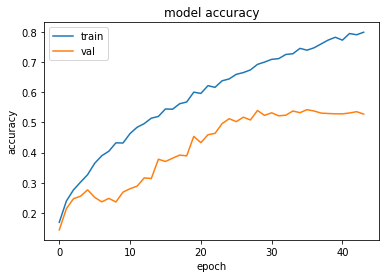

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  28 when  Val Loss was:  1.4373259544372559 , and Val Acc happened to be 0.5393000245094299
Additionally, the best val acc epoch happened to be  35 when val acc was:  0.5419999957084656 and Val Loss happened to be  1.5077850818634033
TestLoss:  1.4048912525177002  TestAcc: 0.5367000102996826
frog 0.777
ship 0.661
truck 0.65
automobile 0.646
horse 0.549
dog 0.522
airplane 0.494
deer 0.437
cat 0.342
bird 0.289


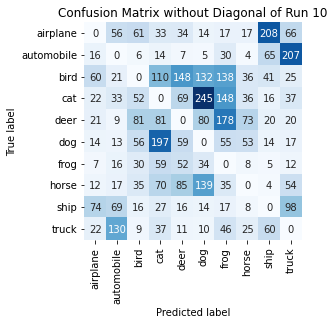

Summing down the rows, for Predictions of each Class that were wrong:  [248. 364. 346. 628. 481. 673. 664. 260. 433. 536.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  148.0 times
Summing across the columns, for total number of that True Class misidentified:  [506. 354. 711. 658. 563. 478. 223. 451. 339. 350.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  178.0 times

 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 

   Begin Run:  11

 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:  

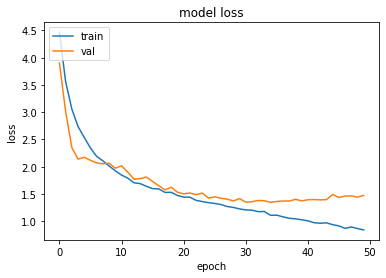

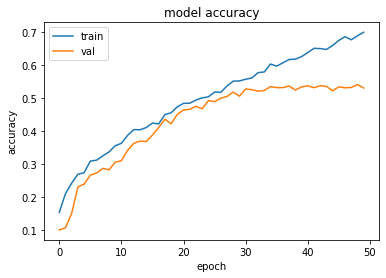

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  34 when  Val Loss was:  1.3463729619979858 , and Val Acc happened to be 0.5347999930381775
Additionally, the best val acc epoch happened to be  48 when val acc was:  0.5410000085830688 and Val Loss happened to be  1.4408619403839111
TestLoss:  1.3136976957321167  TestAcc: 0.5400000214576721
frog 0.702
automobile 0.676
horse 0.656
ship 0.646
truck 0.619
airplane 0.558
dog 0.528
deer 0.46
cat 0.285
bird 0.27


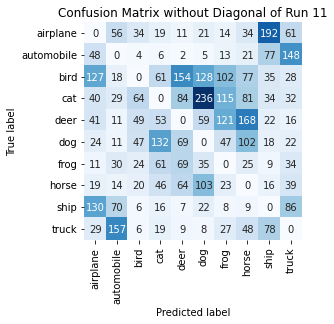

Summing down the rows, for Predictions of each Class that were wrong:  [469. 396. 254. 413. 469. 617. 470. 565. 481. 466.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  154.0 times
Summing across the columns, for total number of that True Class misidentified:  [442. 324. 730. 715. 540. 472. 298. 344. 354. 381.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  168.0 times

 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 

   Begin Run:  12

 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.08 , -0.08 )
ZoomIn:   ( 0.16 , 0.16

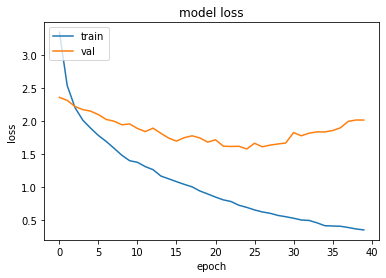

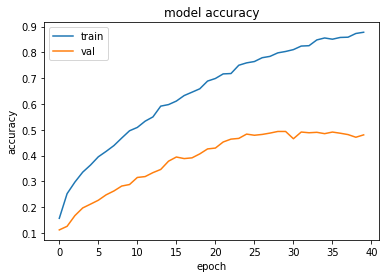

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  24 when  Val Loss was:  1.5758225917816162 , and Val Acc happened to be 0.4830999970436096
Additionally, the best val acc epoch happened to be  28 when val acc was:  0.4932999908924103 and Val Loss happened to be  1.651413917541504
TestLoss:  1.5587480068206787  TestAcc: 0.49050000309944153
automobile 0.675
frog 0.657
ship 0.609
truck 0.558
deer 0.537
horse 0.519
airplane 0.438
dog 0.406
cat 0.295
bird 0.211


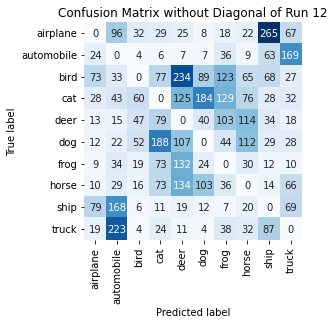

Summing down the rows, for Predictions of each Class that were wrong:  [267. 663. 240. 560. 794. 471. 534. 480. 600. 486.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  234.0 times
Summing across the columns, for total number of that True Class misidentified:  [562. 325. 789. 705. 463. 594. 343. 481. 391. 442.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  114.0 times

 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 

   Begin Run:  13

 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.08 , -0.08 )
ZoomIn:   ( 0.0 , 0.0 )

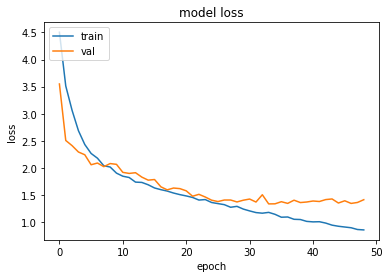

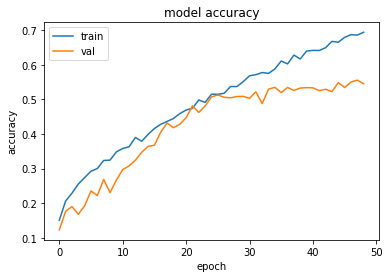

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  33 when  Val Loss was:  1.3329389095306396 , and Val Acc happened to be 0.5296000242233276
Additionally, the best val acc epoch happened to be  47 when val acc was:  0.5555999875068665 and Val Loss happened to be  1.3594019412994385
TestLoss:  1.2923624515533447  TestAcc: 0.5314000248908997
ship 0.737
automobile 0.693
frog 0.684
dog 0.626
horse 0.591
truck 0.541
airplane 0.459
deer 0.358
cat 0.331
bird 0.294


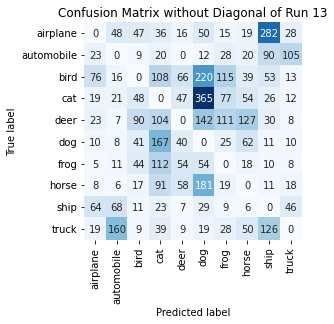

Summing down the rows, for Predictions of each Class that were wrong:  [ 247.  345.  316.  700.  297. 1072.  427.  395.  639.  248.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  66.0 times
Summing across the columns, for total number of that True Class misidentified:  [541. 307. 706. 669. 642. 374. 316. 409. 263. 459.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  142.0 times

 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 

   Begin Run:  14

 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.

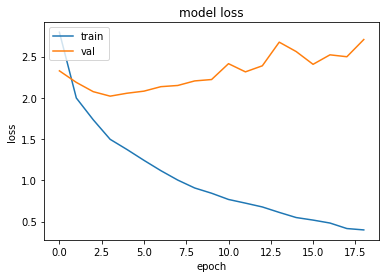

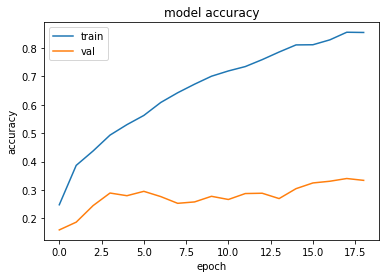

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  3 when  Val Loss was:  2.0204997062683105 , and Val Acc happened to be 0.28929999470710754
Additionally, the best val acc epoch happened to be  17 when val acc was:  0.34040001034736633 and Val Loss happened to be  2.498487710952759
TestLoss:  2.011979579925537  TestAcc: 0.29190000891685486
ship 0.652
dog 0.509
airplane 0.369
cat 0.331
horse 0.318
deer 0.286
frog 0.232
bird 0.185
automobile 0.026
truck 0.011


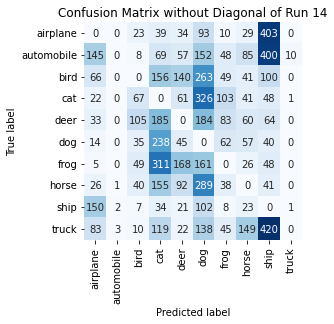

Summing down the rows, for Predictions of each Class that were wrong:  [ 544.    6.  344. 1306.  640. 1708.  446.  511. 1564.   12.]
For example, the model predicted a  label 4 (deer) on a true   6  a total of  168.0 times
Summing across the columns, for total number of that True Class misidentified:  [631. 974. 815. 669. 714. 491. 768. 682. 348. 989.]
For example, the model misclassified true 4's (deer) as label   3 cat  a total of  185.0 times

 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 

   Begin Run:  15

 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
Zoo

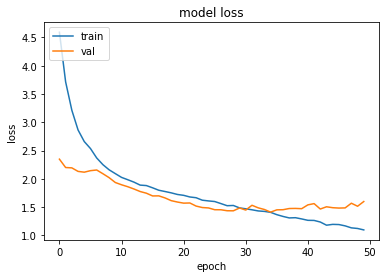

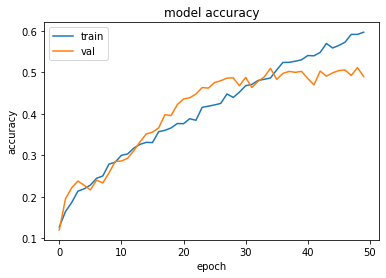

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  34 when  Val Loss was:  1.4112917184829712 , and Val Acc happened to be 0.5099999904632568
Additionally, the best val acc epoch happened to be  48 when val acc was:  0.5117999911308289 and Val Loss happened to be  1.515171766281128
TestLoss:  1.3717669248580933  TestAcc: 0.5138999819755554
frog 0.683
ship 0.648
automobile 0.594
truck 0.574
horse 0.534
airplane 0.518
dog 0.499
deer 0.462
cat 0.317
bird 0.31


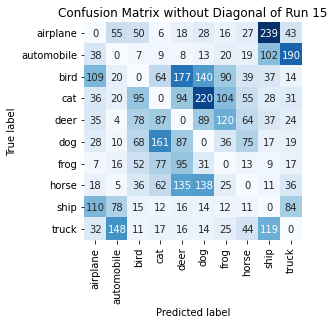

Summing down the rows, for Predictions of each Class that were wrong:  [413. 356. 412. 495. 646. 687. 448. 347. 599. 458.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  177.0 times
Summing across the columns, for total number of that True Class misidentified:  [482. 406. 690. 683. 538. 501. 317. 466. 352. 426.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  120.0 times

 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 

   Begin Run:  16

 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 , 0.0 )


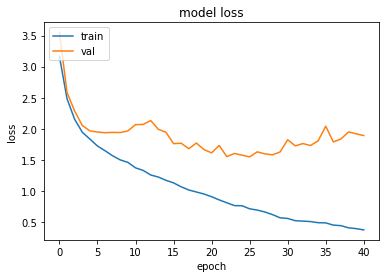

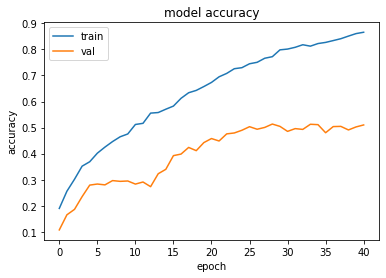

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  25 when  Val Loss was:  1.5499005317687988 , and Val Acc happened to be 0.5034999847412109
Additionally, the best val acc epoch happened to be  28 when val acc was:  0.5135999917984009 and Val Loss happened to be  1.5825480222702026
TestLoss:  1.5149894952774048  TestAcc: 0.4991999864578247
frog 0.795
ship 0.684
truck 0.644
automobile 0.56
deer 0.55
horse 0.429
dog 0.404
airplane 0.383
cat 0.294
bird 0.249


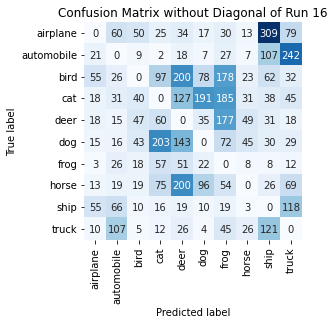

Summing down the rows, for Predictions of each Class that were wrong:  [208. 366. 241. 547. 818. 460. 787. 205. 732. 644.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  200.0 times
Summing across the columns, for total number of that True Class misidentified:  [617. 440. 751. 706. 450. 596. 205. 571. 316. 356.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  177.0 times

 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 

   Begin Run:  17

 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 

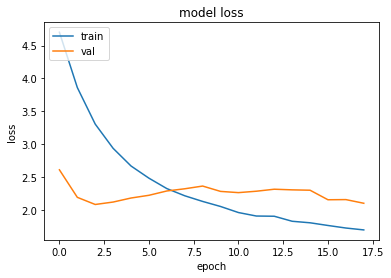

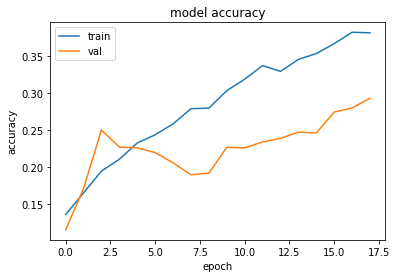

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  2 when  Val Loss was:  2.080923318862915 , and Val Acc happened to be 0.2498999983072281
Additionally, the best val acc epoch happened to be  17 when val acc was:  0.29269999265670776 and Val Loss happened to be  2.099444627761841
TestLoss:  2.0754857063293457  TestAcc: 0.24650000035762787
dog 0.576
ship 0.548
deer 0.401
airplane 0.339
cat 0.319
horse 0.157
frog 0.093
truck 0.019
automobile 0.009
bird 0.004


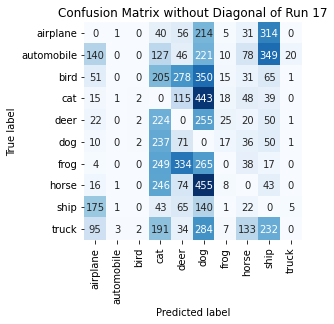

Summing down the rows, for Predictions of each Class that were wrong:  [ 528.    7.    8. 1562. 1073. 2627.  106.  437. 1159.   28.]
For example, the model predicted a  label 4 (deer) on a true   6  a total of  334.0 times
Summing across the columns, for total number of that True Class misidentified:  [661. 991. 996. 681. 599. 424. 907. 843. 452. 981.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  255.0 times

 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 

   Begin Run:  18

 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 , 0.0 )

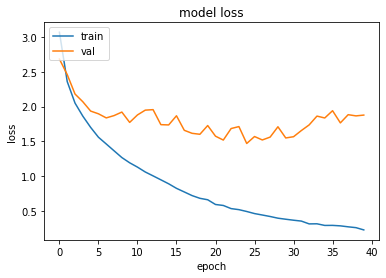

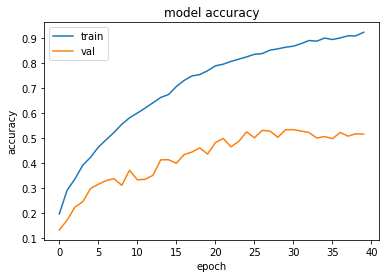

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  24 when  Val Loss was:  1.4692720174789429 , and Val Acc happened to be 0.525600016117096
Additionally, the best val acc epoch happened to be  29 when val acc was:  0.5342000126838684 and Val Loss happened to be  1.5487312078475952
TestLoss:  1.4605302810668945  TestAcc: 0.522599995136261
frog 0.709
airplane 0.626
deer 0.606
automobile 0.591
ship 0.583
horse 0.556
truck 0.554
dog 0.45
bird 0.278
cat 0.273


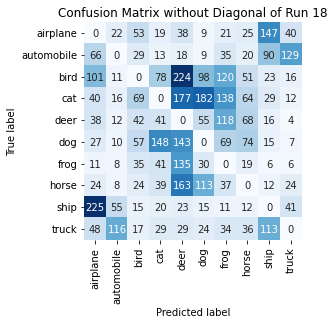

Summing down the rows, for Predictions of each Class that were wrong:  [580. 258. 341. 428. 950. 535. 583. 369. 451. 279.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  224.0 times
Summing across the columns, for total number of that True Class misidentified:  [374. 409. 722. 727. 394. 550. 291. 444. 417. 446.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  118.0 times

 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 

   Begin Run:  19

 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.16 , 0.16 

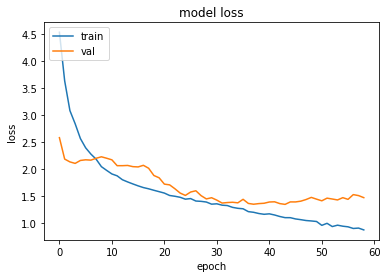

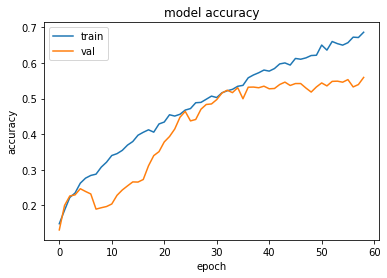

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  43 when  Val Loss was:  1.3475723266601562 , and Val Acc happened to be 0.5462999939918518
Additionally, the best val acc epoch happened to be  58 when val acc was:  0.559499979019165 and Val Loss happened to be  1.4719430208206177
TestLoss:  1.313090205192566  TestAcc: 0.550000011920929
frog 0.778
ship 0.738
automobile 0.675
truck 0.637
airplane 0.524
horse 0.511
deer 0.487
dog 0.458
bird 0.387
cat 0.305


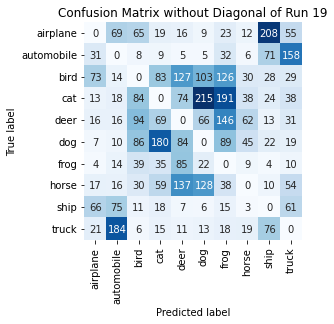

Summing down the rows, for Predictions of each Class that were wrong:  [248. 416. 423. 487. 546. 567. 678. 224. 456. 455.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  137.0 times
Summing across the columns, for total number of that True Class misidentified:  [476. 325. 613. 695. 513. 542. 222. 489. 262. 363.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  146.0 times

 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 

   Begin Run:  20

 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:

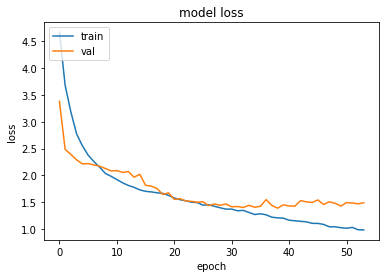

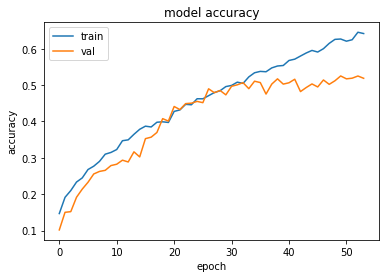

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  38 when  Val Loss was:  1.3884211778640747 , and Val Acc happened to be 0.5170999765396118
Additionally, the best val acc epoch happened to be  49 when val acc was:  0.5249999761581421 and Val Loss happened to be  1.4275470972061157
TestLoss:  1.3529424667358398  TestAcc: 0.5199999809265137
frog 0.745
automobile 0.697
ship 0.619
truck 0.594
horse 0.547
dog 0.505
airplane 0.47
deer 0.461
bird 0.297
cat 0.265


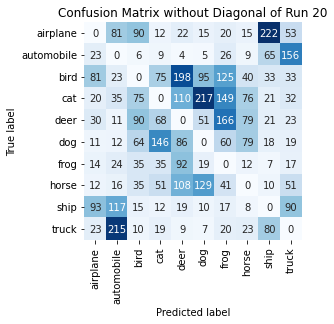

Summing down the rows, for Predictions of each Class that were wrong:  [307. 534. 420. 427. 648. 548. 624. 341. 477. 474.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  198.0 times
Summing across the columns, for total number of that True Class misidentified:  [530. 303. 703. 735. 539. 495. 255. 453. 381. 406.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  166.0 times

 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 

   Begin Run:  21

 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 ,

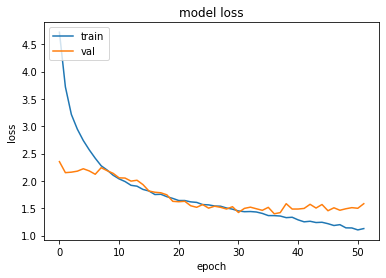

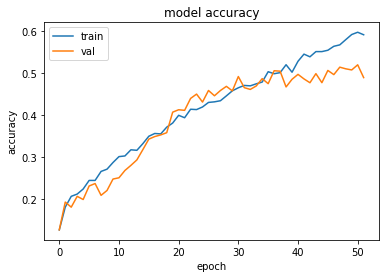

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  36 when  Val Loss was:  1.3975839614868164 , and Val Acc happened to be 0.505299985408783
Additionally, the best val acc epoch happened to be  50 when val acc was:  0.5194000005722046 and Val Loss happened to be  1.4986753463745117
TestLoss:  1.361574649810791  TestAcc: 0.5120000243186951
frog 0.738
automobile 0.696
ship 0.647
horse 0.533
dog 0.531
truck 0.51
deer 0.463
airplane 0.456
bird 0.277
cat 0.269


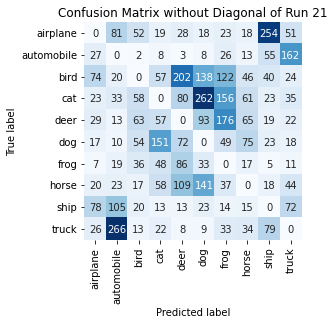

Summing down the rows, for Predictions of each Class that were wrong:  [301. 570. 315. 433. 601. 725. 636. 344. 516. 439.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  202.0 times
Summing across the columns, for total number of that True Class misidentified:  [544. 304. 723. 731. 537. 469. 262. 467. 353. 490.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  176.0 times

 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 

   Begin Run:  22

 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:  

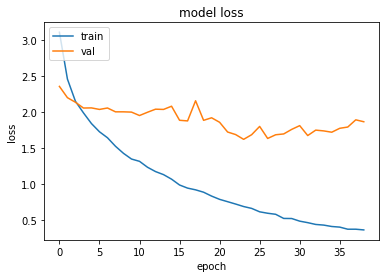

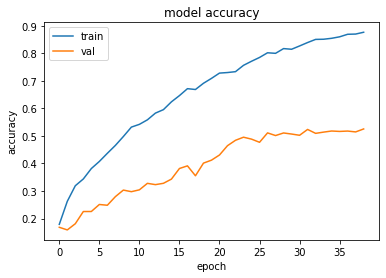

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  23 when  Val Loss was:  1.6206579208374023 , and Val Acc happened to be 0.49549999833106995
Additionally, the best val acc epoch happened to be  38 when val acc was:  0.5254999995231628 and Val Loss happened to be  1.8661497831344604
TestLoss:  1.5723463296890259  TestAcc: 0.49799999594688416
frog 0.913
ship 0.692
truck 0.622
airplane 0.568
automobile 0.486
horse 0.45
deer 0.442
dog 0.386
bird 0.26
cat 0.161


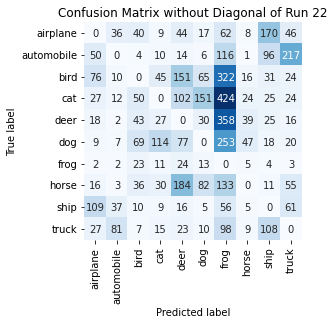

Summing down the rows, for Predictions of each Class that were wrong:  [ 334.  190.  282.  270.  635.  379. 1822.  154.  488.  466.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  184.0 times
Summing across the columns, for total number of that True Class misidentified:  [432. 514. 740. 839. 558. 614.  87. 550. 308. 378.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  358.0 times

 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 

   Begin Run:  23

 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.08

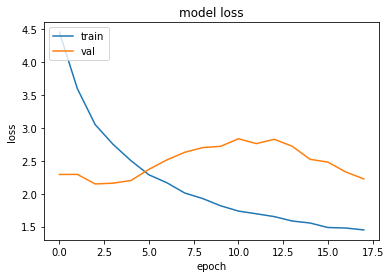

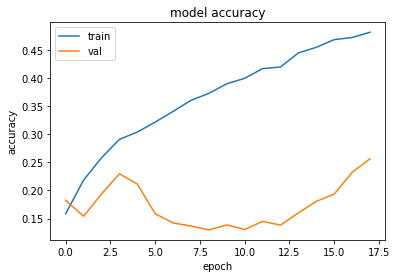

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  2 when  Val Loss was:  2.1477479934692383 , and Val Acc happened to be 0.19370000064373016
Additionally, the best val acc epoch happened to be  17 when val acc was:  0.2565000057220459 and Val Loss happened to be  2.224597930908203
TestLoss:  2.1381614208221436  TestAcc: 0.19480000436306
dog 0.765
airplane 0.37
deer 0.263
cat 0.228
frog 0.122
ship 0.106
horse 0.067
bird 0.012
automobile 0.009
truck 0.006


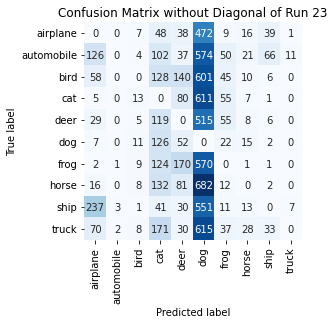

Summing down the rows, for Predictions of each Class that were wrong:  [ 550.    6.   66.  991.  658. 5191.  296.  119.  156.   19.]
For example, the model predicted a  label 4 (deer) on a true   6  a total of  170.0 times
Summing across the columns, for total number of that True Class misidentified:  [630. 991. 988. 772. 737. 235. 878. 933. 894. 994.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  515.0 times

 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 

   Begin Run:  24

 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 , 0.0 )

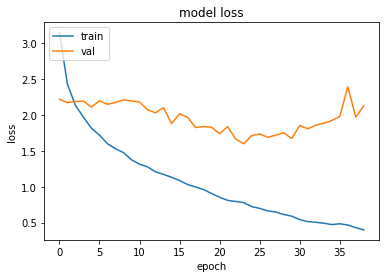

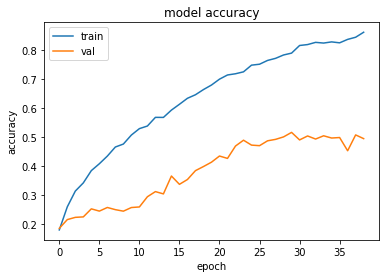

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  23 when  Val Loss was:  1.5989716053009033 , and Val Acc happened to be 0.4896000027656555
Additionally, the best val acc epoch happened to be  29 when val acc was:  0.5164999961853027 and Val Loss happened to be  1.6726535558700562
TestLoss:  1.5484163761138916  TestAcc: 0.498199999332428
frog 0.718
ship 0.668
deer 0.583
truck 0.581
automobile 0.503
dog 0.471
horse 0.437
airplane 0.416
cat 0.404
bird 0.201


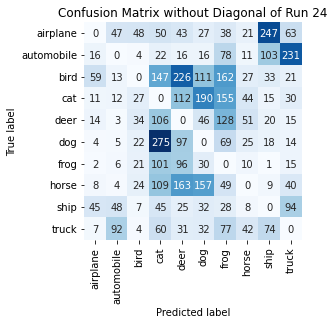

Summing down the rows, for Predictions of each Class that were wrong:  [166. 230. 191. 915. 809. 641. 784. 239. 520. 523.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  226.0 times
Summing across the columns, for total number of that True Class misidentified:  [584. 497. 799. 596. 417. 529. 282. 563. 332. 419.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  128.0 times

 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 

   Begin Run:  25

 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 

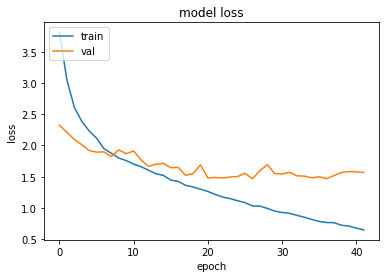

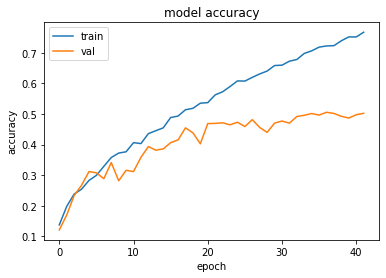

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  26 when  Val Loss was:  1.4661675691604614 , and Val Acc happened to be 0.4814000129699707
Additionally, the best val acc epoch happened to be  36 when val acc was:  0.5055000185966492 and Val Loss happened to be  1.4695771932601929
TestLoss:  1.4320800304412842  TestAcc: 0.492900013923645
frog 0.807
ship 0.644
automobile 0.615
truck 0.495
dog 0.494
horse 0.463
airplane 0.455
deer 0.455
cat 0.265
bird 0.236


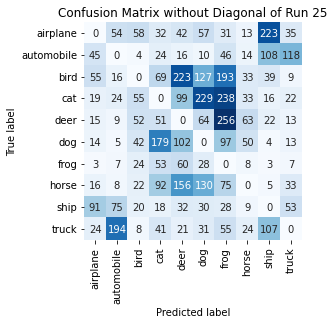

Summing down the rows, for Predictions of each Class that were wrong:  [ 282.  392.  285.  559.  751.  706. 1019.  247.  527.  303.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  223.0 times
Summing across the columns, for total number of that True Class misidentified:  [545. 385. 764. 735. 545. 506. 193. 537. 356. 505.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  256.0 times

 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 

   Begin Run:  26

 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn: 

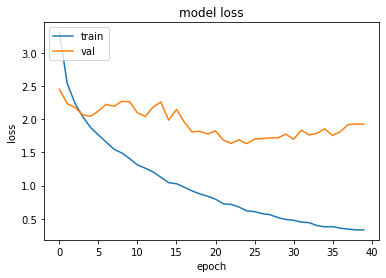

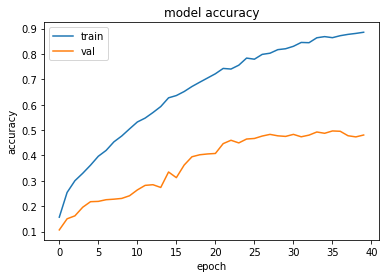

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  24 when  Val Loss was:  1.6335397958755493 , and Val Acc happened to be 0.46470001339912415
Additionally, the best val acc epoch happened to be  35 when val acc was:  0.4964999854564667 and Val Loss happened to be  1.756805419921875
TestLoss:  1.5915966033935547  TestAcc: 0.47380000352859497
frog 0.797
ship 0.644
deer 0.599
airplane 0.563
horse 0.482
automobile 0.471
truck 0.466
dog 0.294
bird 0.224
cat 0.198


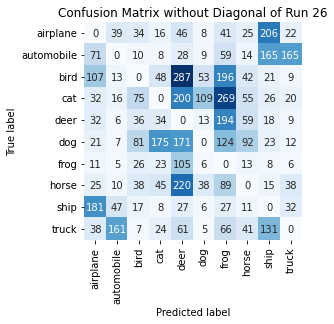

Summing down the rows, for Predictions of each Class that were wrong:  [ 518.  304.  324.  381. 1145.  247. 1065.  352.  613.  313.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  287.0 times
Summing across the columns, for total number of that True Class misidentified:  [437. 529. 776. 802. 401. 706. 203. 518. 356. 534.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  194.0 times

 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 

   Begin Run:  27

 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.

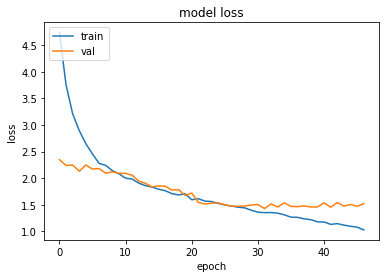

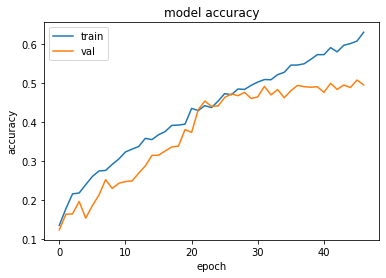

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  31 when  Val Loss was:  1.4273873567581177 , and Val Acc happened to be 0.4909999966621399
Additionally, the best val acc epoch happened to be  45 when val acc was:  0.5072000026702881 and Val Loss happened to be  1.4694712162017822
TestLoss:  1.403059720993042  TestAcc: 0.4943999946117401
ship 0.657
frog 0.651
truck 0.63
horse 0.562
automobile 0.559
dog 0.529
deer 0.506
airplane 0.374
bird 0.285
cat 0.191


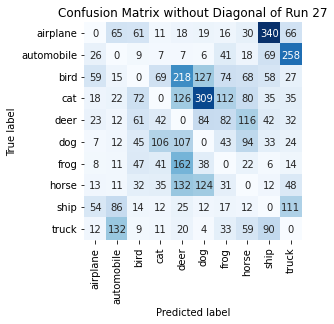

Summing down the rows, for Predictions of each Class that were wrong:  [220. 366. 350. 334. 815. 723. 449. 499. 685. 615.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  218.0 times
Summing across the columns, for total number of that True Class misidentified:  [626. 441. 715. 809. 494. 471. 349. 438. 343. 370.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  116.0 times

 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 

   Begin Run:  28

 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28 28  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.16 , 0.16

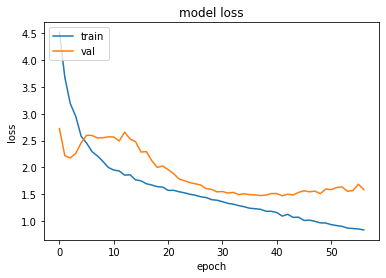

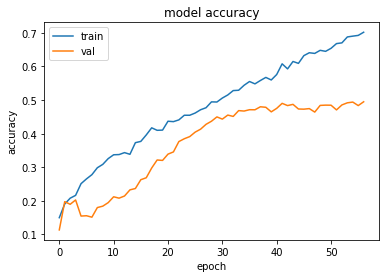

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  41 when  Val Loss was:  1.4711977243423462 , and Val Acc happened to be 0.490200012922287
Additionally, the best val acc epoch happened to be  56 when val acc was:  0.4948999881744385 and Val Loss happened to be  1.584574818611145
TestLoss:  1.4334022998809814  TestAcc: 0.49079999327659607
frog 0.673
automobile 0.597
truck 0.584
horse 0.535
dog 0.529
airplane 0.516
ship 0.514
deer 0.492
bird 0.254
cat 0.214


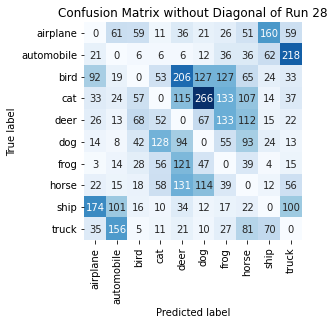

Summing down the rows, for Predictions of each Class that were wrong:  [420. 411. 299. 385. 764. 676. 593. 606. 385. 553.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  206.0 times
Summing across the columns, for total number of that True Class misidentified:  [484. 403. 746. 786. 508. 471. 327. 465. 486. 416.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  133.0 times

 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 

   Begin Run:  29

 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29 29  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )


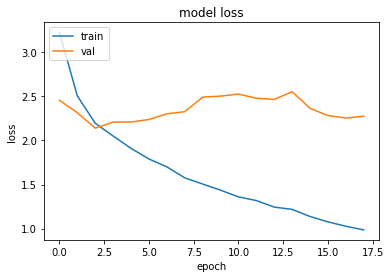

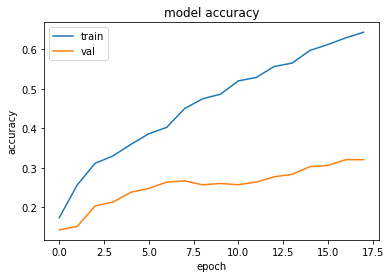

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  2 when  Val Loss was:  2.1390957832336426 , and Val Acc happened to be 0.20329999923706055
Additionally, the best val acc epoch happened to be  16 when val acc was:  0.320499986410141 and Val Loss happened to be  2.2541563510894775
TestLoss:  2.129251480102539  TestAcc: 0.2054000049829483
dog 0.803
airplane 0.331
horse 0.24
ship 0.225
frog 0.178
bird 0.137
deer 0.111
cat 0.019
automobile 0.008
truck 0.002


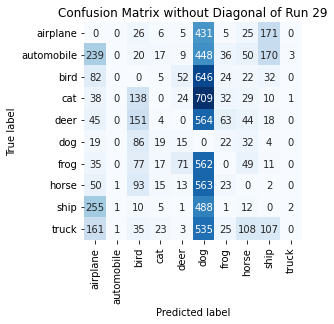

Summing down the rows, for Predictions of each Class that were wrong:  [9.240e+02 3.000e+00 6.360e+02 1.110e+02 1.930e+02 4.946e+03 2.310e+02
 3.710e+02 5.250e+02 6.000e+00]
For example, the model predicted a  label 4 (deer) on a true   6  a total of  71.0 times
Summing across the columns, for total number of that True Class misidentified:  [669. 992. 863. 981. 889. 197. 822. 760. 775. 998.]
For example, the model misclassified true 4's (deer) as label   5 dog  a total of  564.0 times

 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 

   Begin Run:  30

 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  (

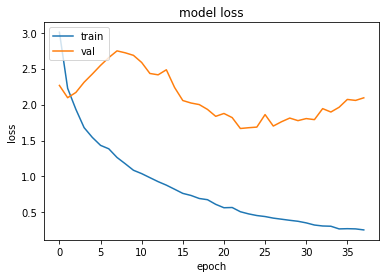

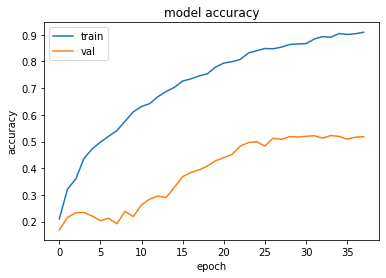

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  22 when  Val Loss was:  1.667054295539856 , and Val Acc happened to be 0.4828000068664551
Additionally, the best val acc epoch happened to be  33 when val acc was:  0.5223000049591064 and Val Loss happened to be  1.8964020013809204
TestLoss:  1.6114139556884766  TestAcc: 0.4948999881744385
frog 0.756
airplane 0.657
deer 0.601
ship 0.548
truck 0.468
horse 0.466
automobile 0.452
dog 0.417
bird 0.316
cat 0.268


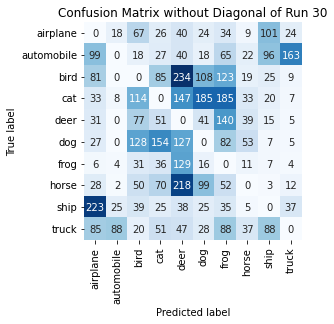

Summing down the rows, for Predictions of each Class that were wrong:  [ 613.  145.  544.  525. 1020.  544.  804.  228.  362.  266.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  234.0 times
Summing across the columns, for total number of that True Class misidentified:  [343. 548. 684. 732. 399. 583. 244. 534. 452. 532.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  140.0 times

 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 

   Begin Run:  31

 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn

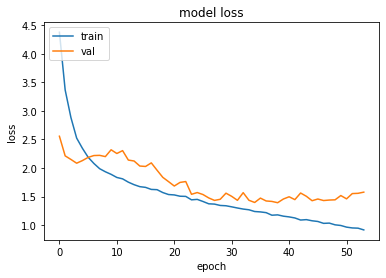

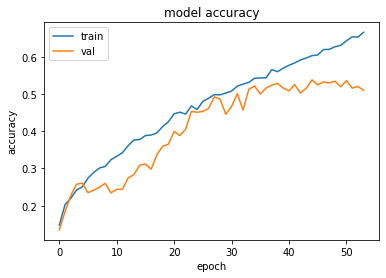

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  38 when  Val Loss was:  1.3916264772415161 , and Val Acc happened to be 0.5286999940872192
Additionally, the best val acc epoch happened to be  44 when val acc was:  0.5378000140190125 and Val Loss happened to be  1.4264963865280151
TestLoss:  1.3523043394088745  TestAcc: 0.5227000117301941
truck 0.729
ship 0.691
frog 0.668
horse 0.582
automobile 0.545
deer 0.452
dog 0.439
bird 0.392
airplane 0.379
cat 0.35


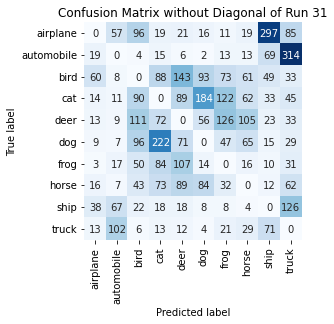

Summing down the rows, for Predictions of each Class that were wrong:  [185. 285. 518. 604. 556. 461. 453. 374. 579. 758.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  143.0 times
Summing across the columns, for total number of that True Class misidentified:  [621. 455. 608. 650. 548. 561. 332. 418. 309. 271.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  126.0 times

 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 

   Begin Run:  32

 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32 32  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.16 , 0.16 

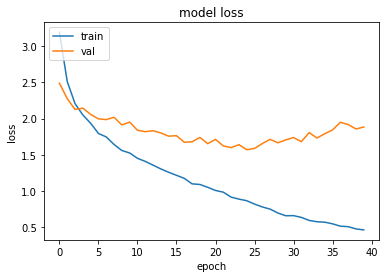

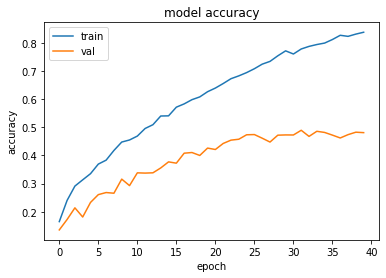

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  24 when  Val Loss was:  1.5693950653076172 , and Val Acc happened to be 0.4731999933719635
Additionally, the best val acc epoch happened to be  31 when val acc was:  0.48919999599456787 and Val Loss happened to be  1.680586576461792
TestLoss:  1.5416816473007202  TestAcc: 0.47940000891685486
ship 0.7
frog 0.629
deer 0.543
truck 0.525
horse 0.502
automobile 0.473
airplane 0.437
bird 0.374
dog 0.374
cat 0.237


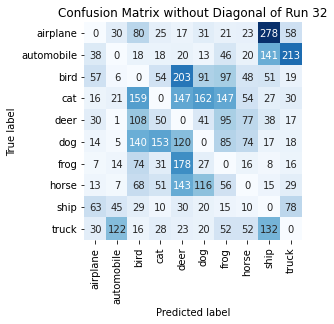

Summing down the rows, for Predictions of each Class that were wrong:  [268. 251. 692. 420. 881. 521. 614. 374. 707. 478.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  203.0 times
Summing across the columns, for total number of that True Class misidentified:  [563. 527. 626. 763. 457. 626. 371. 498. 300. 475.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  108.0 times

 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 

   Begin Run:  33

 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    

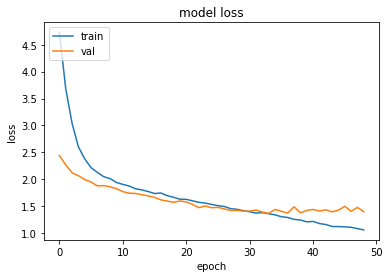

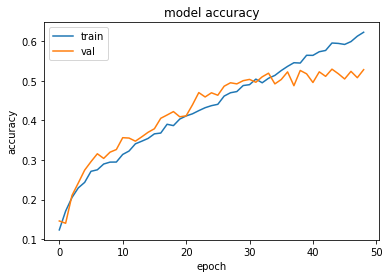

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  33 when  Val Loss was:  1.3662256002426147 , and Val Acc happened to be 0.5192000269889832
Additionally, the best val acc epoch happened to be  43 when val acc was:  0.5293999910354614 and Val Loss happened to be  1.395185112953186
TestLoss:  1.3341478109359741  TestAcc: 0.5246000289916992
ship 0.665
frog 0.659
automobile 0.647
truck 0.581
airplane 0.566
dog 0.557
horse 0.489
deer 0.398
bird 0.356
cat 0.328


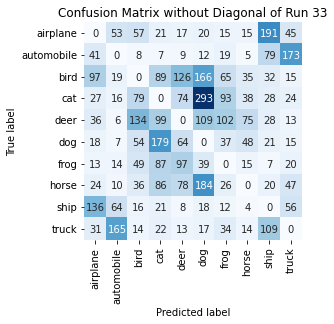

Summing down the rows, for Predictions of each Class that were wrong:  [423. 354. 447. 611. 486. 858. 403. 249. 515. 408.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  126.0 times
Summing across the columns, for total number of that True Class misidentified:  [434. 353. 644. 672. 602. 443. 341. 511. 335. 419.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  134.0 times

 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 

   Begin Run:  34

 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:  

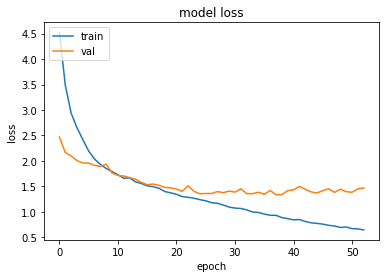

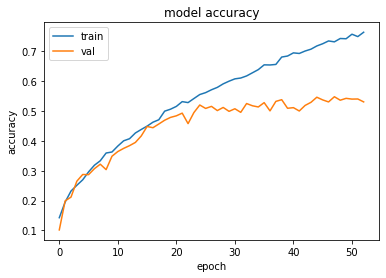

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  37 when  Val Loss was:  1.3366419076919556 , and Val Acc happened to be 0.5325999855995178
Additionally, the best val acc epoch happened to be  47 when val acc was:  0.5482000112533569 and Val Loss happened to be  1.3830084800720215
TestLoss:  1.3174760341644287  TestAcc: 0.5339999794960022
automobile 0.767
horse 0.685
frog 0.682
ship 0.63
deer 0.603
truck 0.588
airplane 0.511
dog 0.455
cat 0.287
bird 0.132


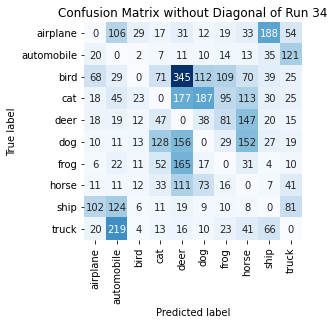

Summing down the rows, for Predictions of each Class that were wrong:  [ 273.  586.  112.  379. 1031.  468.  396.  608.  416.  391.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  345.0 times
Summing across the columns, for total number of that True Class misidentified:  [489. 233. 868. 713. 397. 545. 318. 315. 370. 412.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  147.0 times

 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 

   Begin Run:  35

 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35 35  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0

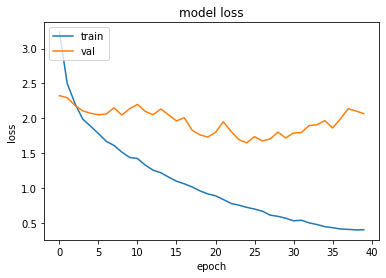

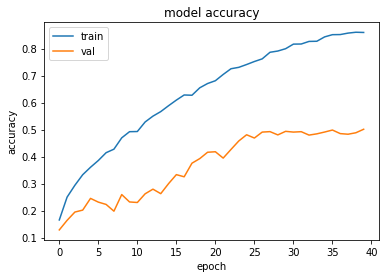

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  24 when  Val Loss was:  1.6468615531921387 , and Val Acc happened to be 0.48100000619888306
Additionally, the best val acc epoch happened to be  39 when val acc was:  0.5013999938964844 and Val Loss happened to be  2.0664188861846924
TestLoss:  1.609929084777832  TestAcc: 0.4860999882221222
frog 0.793
ship 0.705
deer 0.608
truck 0.567
automobile 0.513
horse 0.484
dog 0.421
airplane 0.374
cat 0.25
bird 0.146


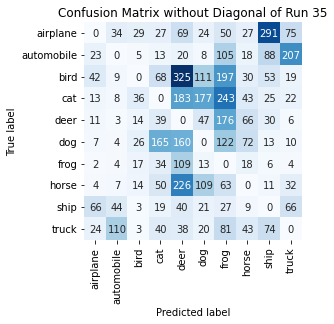

Summing down the rows, for Predictions of each Class that were wrong:  [ 192.  223.  147.  455. 1170.  530. 1064.  326.  591.  441.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  325.0 times
Summing across the columns, for total number of that True Class misidentified:  [626. 487. 854. 750. 392. 579. 207. 516. 295. 433.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  176.0 times

 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 

   Begin Run:  36

 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36 36  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 

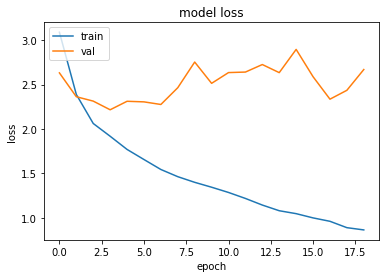

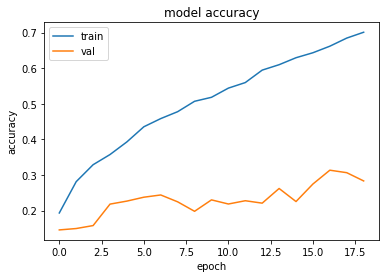

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  3 when  Val Loss was:  2.216834545135498 , and Val Acc happened to be 0.21809999644756317
Additionally, the best val acc epoch happened to be  16 when val acc was:  0.313400000333786 and Val Loss happened to be  2.3360352516174316
TestLoss:  2.2034549713134766  TestAcc: 0.21860000491142273
dog 0.465
deer 0.359
frog 0.335
bird 0.294
cat 0.269
airplane 0.177
horse 0.159
ship 0.117
automobile 0.01
truck 0.001


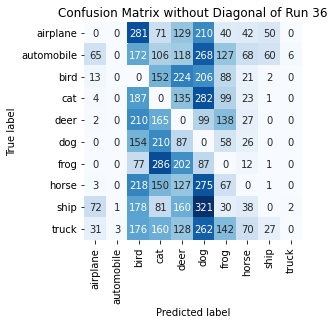

Summing down the rows, for Predictions of each Class that were wrong:  [ 190.    4. 1653. 1381. 1310. 2010.  789.  327.  142.    8.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  224.0 times
Summing across the columns, for total number of that True Class misidentified:  [823. 990. 706. 731. 641. 535. 665. 841. 883. 999.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  210.0 times

 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 

   Begin Run:  37

 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn: 

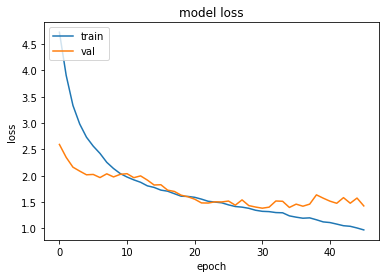

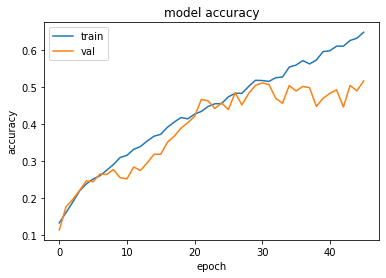

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  30 when  Val Loss was:  1.3828907012939453 , and Val Acc happened to be 0.5116999745368958
Additionally, the best val acc epoch happened to be  45 when val acc was:  0.5170999765396118 and Val Loss happened to be  1.4261723756790161
TestLoss:  1.3595669269561768  TestAcc: 0.5166000127792358
frog 0.701
automobile 0.645
truck 0.628
ship 0.593
horse 0.556
airplane 0.531
deer 0.531
dog 0.497
bird 0.331
cat 0.153


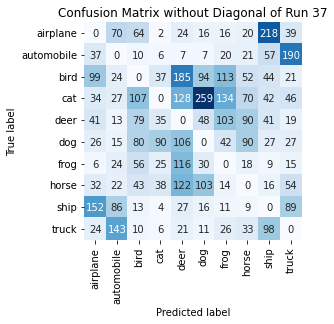

Summing down the rows, for Predictions of each Class that were wrong:  [451. 424. 462. 243. 736. 584. 479. 403. 552. 500.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  185.0 times
Summing across the columns, for total number of that True Class misidentified:  [469. 355. 669. 847. 469. 503. 299. 444. 407. 372.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  103.0 times

 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 

   Begin Run:  38

 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
No

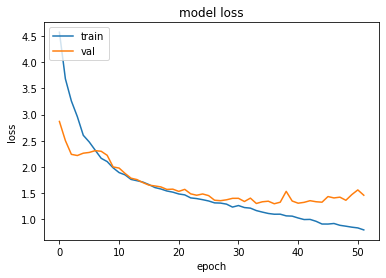

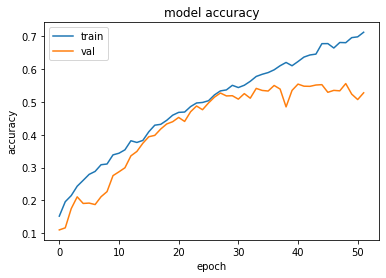

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  36 when  Val Loss was:  1.2969272136688232 , and Val Acc happened to be 0.5498999953269958
Additionally, the best val acc epoch happened to be  48 when val acc was:  0.5557000041007996 and Val Loss happened to be  1.3633143901824951
TestLoss:  1.2610609531402588  TestAcc: 0.5515999794006348
frog 0.711
automobile 0.698
airplane 0.62
ship 0.605
truck 0.593
horse 0.543
dog 0.535
deer 0.524
bird 0.357
cat 0.33


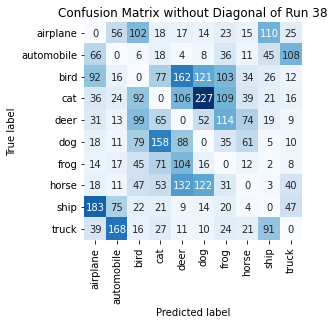

Summing down the rows, for Predictions of each Class that were wrong:  [497. 391. 508. 508. 633. 584. 495. 271. 322. 275.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  162.0 times
Summing across the columns, for total number of that True Class misidentified:  [380. 302. 643. 670. 476. 465. 289. 457. 395. 407.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  114.0 times

 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 

   Begin Run:  39

 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
No

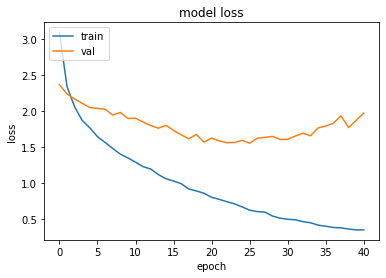

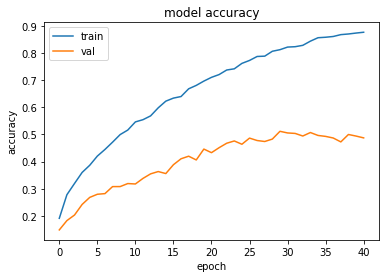

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  25 when  Val Loss was:  1.5557606220245361 , and Val Acc happened to be 0.4864000082015991
Additionally, the best val acc epoch happened to be  29 when val acc was:  0.5113999843597412 and Val Loss happened to be  1.607222080230713
TestLoss:  1.5186976194381714  TestAcc: 0.4900999963283539
deer 0.66
ship 0.577
frog 0.576
automobile 0.526
airplane 0.515
dog 0.486
horse 0.468
truck 0.458
cat 0.319
bird 0.316


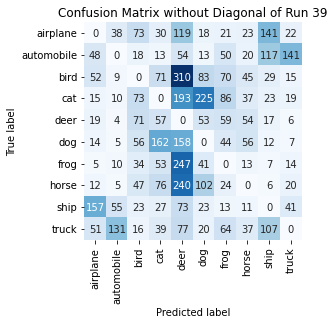

Summing down the rows, for Predictions of each Class that were wrong:  [ 373.  267.  411.  528. 1471.  578.  431.  296.  459.  285.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  310.0 times
Summing across the columns, for total number of that True Class misidentified:  [485. 474. 684. 681. 340. 514. 424. 532. 423. 542.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  71.0 times

 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 

   Begin Run:  40

 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 ,

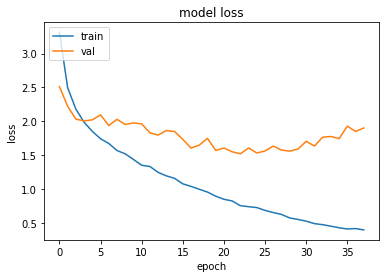

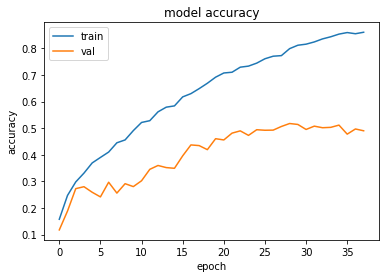

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  22 when  Val Loss was:  1.5213395357131958 , and Val Acc happened to be 0.48980000615119934
Additionally, the best val acc epoch happened to be  28 when val acc was:  0.5174000263214111 and Val Loss happened to be  1.5600030422210693
TestLoss:  1.4773523807525635  TestAcc: 0.498199999332428
ship 0.687
frog 0.682
horse 0.621
deer 0.61
truck 0.52
automobile 0.518
airplane 0.44
bird 0.425
dog 0.265
cat 0.214


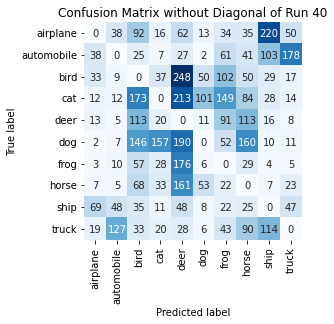

Summing down the rows, for Predictions of each Class that were wrong:  [ 196.  261.  742.  329. 1153.  250.  576.  627.  531.  353.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  248.0 times
Summing across the columns, for total number of that True Class misidentified:  [560. 482. 575. 786. 390. 735. 318. 379. 313. 480.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  113.0 times

 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 

   Begin Run:  41

 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.

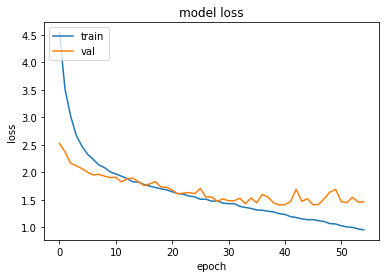

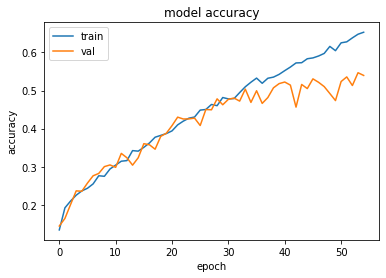

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  39 when  Val Loss was:  1.4042187929153442 , and Val Acc happened to be 0.5181000232696533
Additionally, the best val acc epoch happened to be  53 when val acc was:  0.5467000007629395 and Val Loss happened to be  1.457824945449829
TestLoss:  1.3532471656799316  TestAcc: 0.5223000049591064
frog 0.838
truck 0.675
ship 0.655
horse 0.591
airplane 0.535
automobile 0.526
deer 0.487
dog 0.458
cat 0.265
bird 0.193


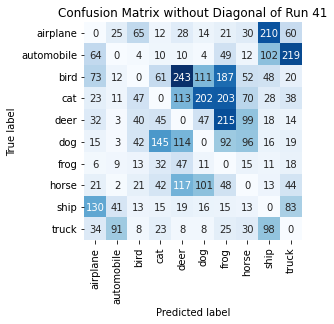

Summing down the rows, for Predictions of each Class that were wrong:  [398. 197. 253. 385. 699. 514. 855. 417. 544. 515.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  243.0 times
Summing across the columns, for total number of that True Class misidentified:  [465. 474. 807. 735. 513. 542. 162. 409. 345. 325.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  215.0 times

 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 

   Begin Run:  42

 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.16

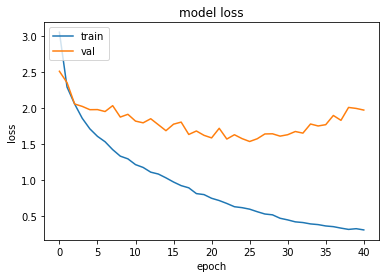

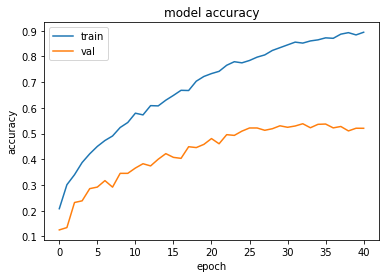

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  25 when  Val Loss was:  1.5328431129455566 , and Val Acc happened to be 0.5217000246047974
Additionally, the best val acc epoch happened to be  32 when val acc was:  0.5382000207901001 and Val Loss happened to be  1.649216651916504
TestLoss:  1.4986695051193237  TestAcc: 0.5313000082969666
ship 0.799
frog 0.705
truck 0.616
horse 0.565
automobile 0.55
deer 0.534
airplane 0.474
cat 0.388
dog 0.347
bird 0.335


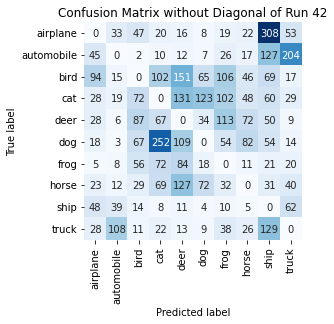

Summing down the rows, for Predictions of each Class that were wrong:  [317. 243. 385. 622. 654. 340. 500. 329. 849. 448.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  151.0 times
Summing across the columns, for total number of that True Class misidentified:  [526. 450. 665. 612. 466. 653. 295. 435. 201. 384.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  113.0 times

 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 

   Begin Run:  43

 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43 43  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 ,

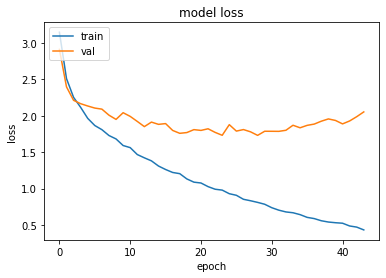

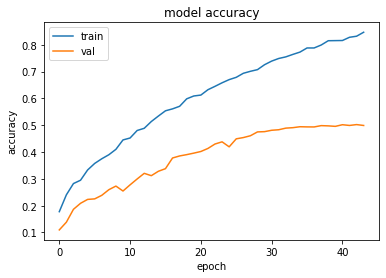

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  28 when  Val Loss was:  1.7295998334884644 , and Val Acc happened to be 0.4749000072479248
Additionally, the best val acc epoch happened to be  42 when val acc was:  0.5022000074386597 and Val Loss happened to be  1.9859998226165771
TestLoss:  1.6890970468521118  TestAcc: 0.48030000925064087
frog 0.771
ship 0.689
deer 0.589
automobile 0.561
truck 0.475
airplane 0.465
horse 0.459
dog 0.29
bird 0.272
cat 0.232


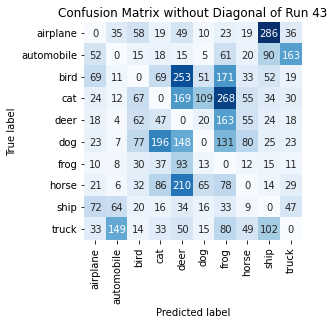

Summing down the rows, for Predictions of each Class that were wrong:  [ 322.  296.  375.  521. 1021.  304. 1008.  332.  642.  376.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  253.0 times
Summing across the columns, for total number of that True Class misidentified:  [535. 439. 728. 768. 411. 710. 229. 541. 311. 525.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  163.0 times

 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 

   Begin Run:  44

 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 110 , 110 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.

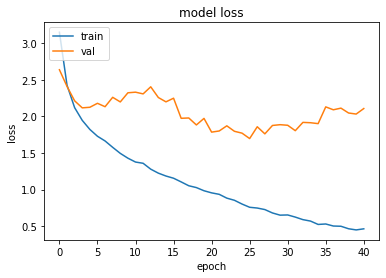

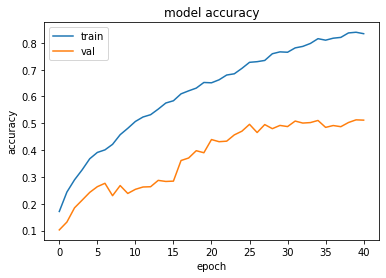

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  25 when  Val Loss was:  1.697986364364624 , and Val Acc happened to be 0.4961000084877014
Additionally, the best val acc epoch happened to be  39 when val acc was:  0.5127999782562256 and Val Loss happened to be  2.032778024673462
TestLoss:  1.6380822658538818  TestAcc: 0.5069000124931335
frog 0.854
automobile 0.628
truck 0.593
ship 0.587
airplane 0.477
deer 0.442
horse 0.418
dog 0.405
bird 0.339
cat 0.326


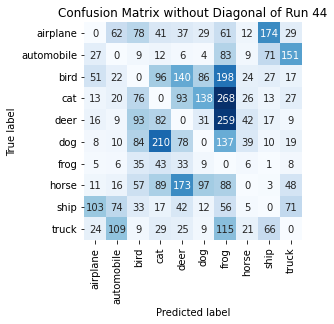

Summing down the rows, for Predictions of each Class that were wrong:  [ 258.  328.  474.  619.  627.  415. 1265.  184.  382.  379.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  173.0 times
Summing across the columns, for total number of that True Class misidentified:  [523. 372. 661. 674. 558. 595. 146. 582. 413. 407.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  259.0 times

 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 

   Begin Run:  45

 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45 45  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 

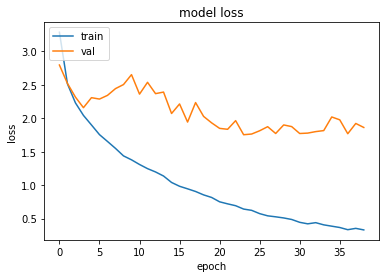

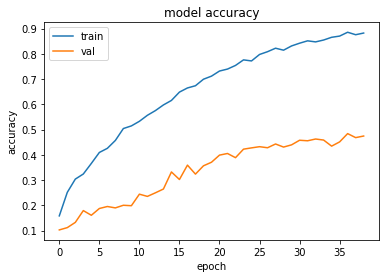

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  23 when  Val Loss was:  1.7539585828781128 , and Val Acc happened to be 0.42250001430511475
Additionally, the best val acc epoch happened to be  36 when val acc was:  0.48410001397132874 and Val Loss happened to be  1.768918514251709
TestLoss:  1.7124760150909424  TestAcc: 0.43290001153945923
ship 0.795
frog 0.789
bird 0.498
airplane 0.447
truck 0.416
automobile 0.359
deer 0.323
horse 0.294
dog 0.225
cat 0.183


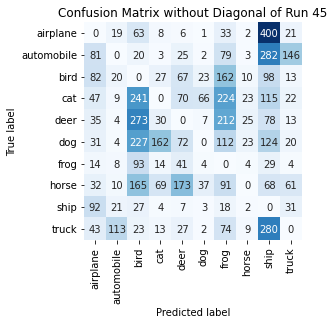

Summing down the rows, for Predictions of each Class that were wrong:  [ 457.  208. 1132.  330.  488.  145. 1005.  101. 1474.  331.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  173.0 times
Summing across the columns, for total number of that True Class misidentified:  [553. 641. 502. 817. 677. 775. 211. 706. 205. 584.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  273.0 times

 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 

   Begin Run:  46

 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.

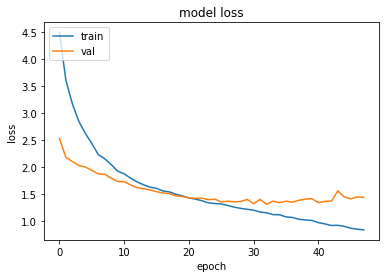

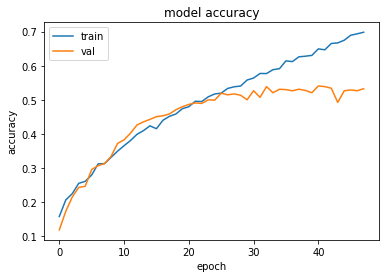

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  32 when  Val Loss was:  1.3130210638046265 , and Val Acc happened to be 0.5388000011444092
Additionally, the best val acc epoch happened to be  40 when val acc was:  0.5407999753952026 and Val Loss happened to be  1.3452513217926025
TestLoss:  1.2872689962387085  TestAcc: 0.5346999764442444
frog 0.714
ship 0.656
truck 0.633
horse 0.624
automobile 0.586
airplane 0.552
dog 0.52
deer 0.505
cat 0.295
bird 0.262


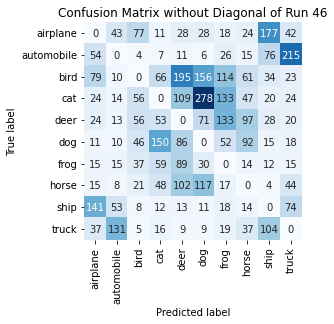

Summing down the rows, for Predictions of each Class that were wrong:  [400. 297. 310. 422. 642. 706. 530. 401. 470. 475.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  195.0 times
Summing across the columns, for total number of that True Class misidentified:  [448. 414. 738. 705. 495. 480. 286. 376. 344. 367.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  133.0 times

 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 

   Begin Run:  47

 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47 47  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 

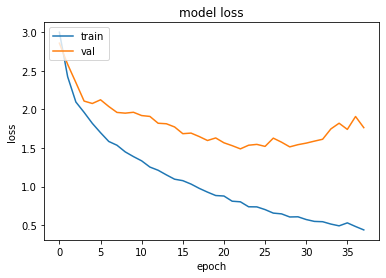

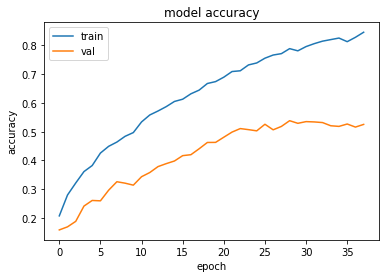

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  22 when  Val Loss was:  1.4891636371612549 , and Val Acc happened to be 0.5109000205993652
Additionally, the best val acc epoch happened to be  28 when val acc was:  0.5382999777793884 and Val Loss happened to be  1.5151050090789795
TestLoss:  1.440656304359436  TestAcc: 0.517300009727478
frog 0.739
truck 0.704
ship 0.639
airplane 0.559
horse 0.53
dog 0.522
deer 0.516
automobile 0.411
bird 0.279
cat 0.274


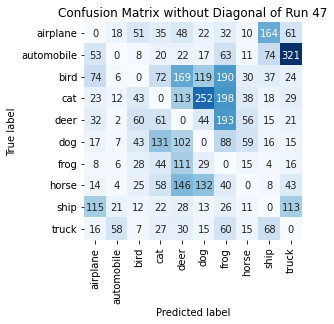

Summing down the rows, for Predictions of each Class that were wrong:  [352. 134. 277. 470. 769. 643. 890. 245. 404. 643.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  169.0 times
Summing across the columns, for total number of that True Class misidentified:  [441. 589. 721. 726. 484. 478. 261. 470. 361. 296.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  193.0 times

 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 

   Begin Run:  48

 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 110 , 110 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )


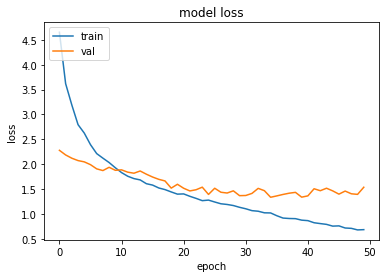

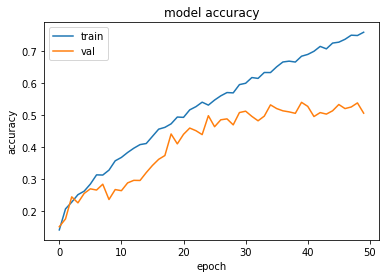

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  34 when  Val Loss was:  1.3345392942428589 , and Val Acc happened to be 0.5320000052452087
Additionally, the best val acc epoch happened to be  39 when val acc was:  0.539900004863739 and Val Loss happened to be  1.336768388748169
TestLoss:  1.3064860105514526  TestAcc: 0.5350000262260437
frog 0.779
ship 0.727
automobile 0.601
truck 0.566
horse 0.536
airplane 0.523
dog 0.455
deer 0.442
cat 0.364
bird 0.357


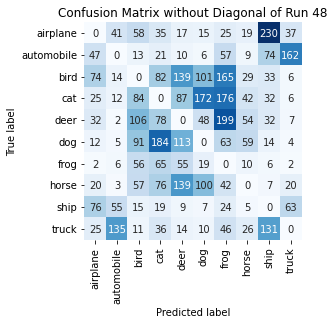

Summing down the rows, for Predictions of each Class that were wrong:  [313. 273. 491. 596. 583. 478. 797. 253. 559. 307.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  139.0 times
Summing across the columns, for total number of that True Class misidentified:  [477. 399. 643. 636. 558. 545. 221. 464. 273. 434.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  199.0 times

 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 

   Begin Run:  49

 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
No

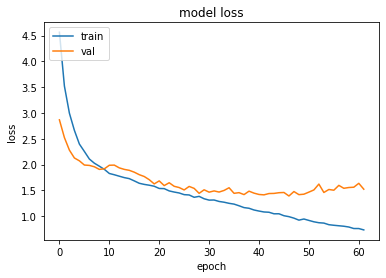

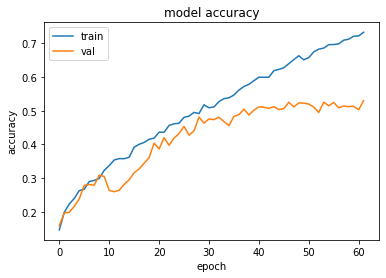

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  46 when  Val Loss was:  1.3921325206756592 , and Val Acc happened to be 0.5252000093460083
Additionally, the best val acc epoch happened to be  61 when val acc was:  0.5300999879837036 and Val Loss happened to be  1.5234431028366089
TestLoss:  1.3591820001602173  TestAcc: 0.5302000045776367
truck 0.698
frog 0.689
ship 0.673
horse 0.626
dog 0.613
automobile 0.506
airplane 0.494
deer 0.461
cat 0.276
bird 0.266


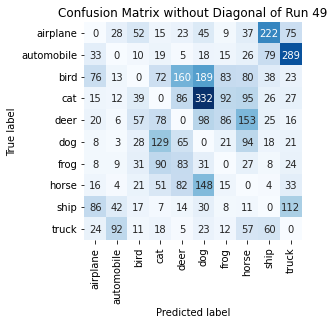

Summing down the rows, for Predictions of each Class that were wrong:  [286. 209. 266. 479. 523. 914. 341. 580. 480. 620.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  160.0 times
Summing across the columns, for total number of that True Class misidentified:  [506. 494. 734. 724. 539. 387. 311. 374. 327. 302.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  153.0 times

 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 

   Begin Run:  50

 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0

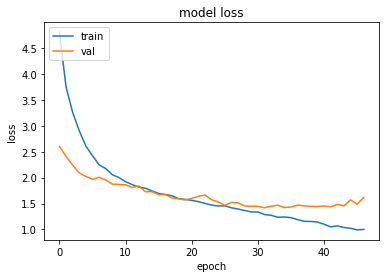

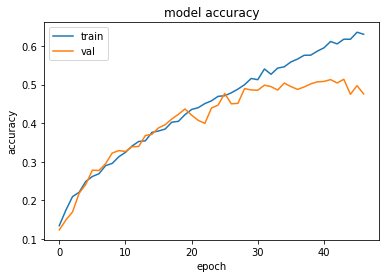

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  31 when  Val Loss was:  1.417641282081604 , and Val Acc happened to be 0.4986000061035156
Additionally, the best val acc epoch happened to be  43 when val acc was:  0.5138999819755554 and Val Loss happened to be  1.4543602466583252
TestLoss:  1.3837897777557373  TestAcc: 0.4982999861240387
ship 0.689
frog 0.661
truck 0.645
horse 0.575
automobile 0.528
deer 0.495
dog 0.463
airplane 0.387
cat 0.304
bird 0.236


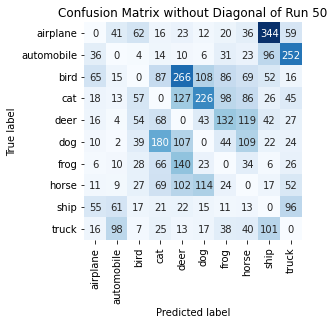

Summing down the rows, for Predictions of each Class that were wrong:  [233. 253. 295. 546. 810. 564. 484. 529. 706. 597.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  266.0 times
Summing across the columns, for total number of that True Class misidentified:  [613. 472. 764. 696. 505. 537. 339. 425. 311. 355.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  132.0 times


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Final Download attempted :  Thu, 11 November 2021 19:10:22  (subtract ~5-hours for local Hour), and file is called  runs_GroupB_final.pkl


In [60]:
run_through_runs(ds=make_unbatched(train_B), ds_noalb=train_B_noalb, dstitle="B" , showpictures= False)


filename will be:  runs_GroupC .pkl

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

   Begin Run:  0

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 0 , 0 )
blur:     ( 0 , 1 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright:   ( 0.0 , 0.0 )
Darken:   ( -0.0 , -0.0 )
Rotate:   ( 0 , 0 ) or ( 0 , 0 )
pHorizontalFlip:    0
pVerticalFlip:      0
pEqualize:          0
pFancyPCA:          0
pChannelShuffle:    0
pElasticTransform:  0
pToGray:            0
 ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 


Training Model... 


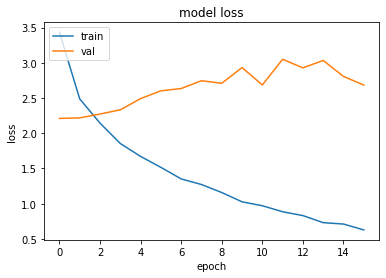

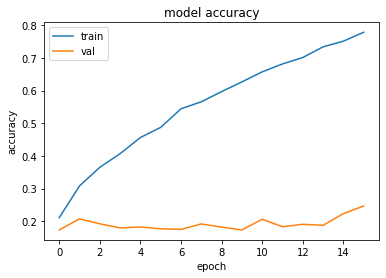

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  0 when  Val Loss was:  2.210174798965454 , and Val Acc happened to be 0.1738000065088272
Additionally, the best val acc epoch happened to be  15 when val acc was:  0.2468000054359436 and Val Loss happened to be  2.683683395385742
TestLoss:  2.2091026306152344  TestAcc: 0.17090000212192535
ship 0.522
airplane 0.5
horse 0.377
cat 0.141
dog 0.069
deer 0.046
bird 0.028
automobile 0.02
truck 0.005
frog 0.001


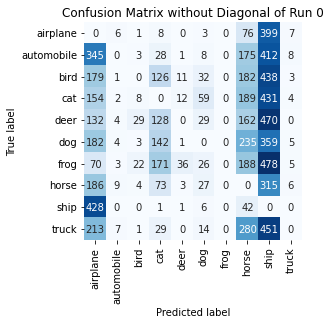

Summing down the rows, for Predictions of each Class that were wrong:  [1889.   36.   71.  706.   65.  204.    0. 1529. 3753.   38.]
For example, the model predicted a  label 4 (deer) on a true   6  a total of  36.0 times
Summing across the columns, for total number of that True Class misidentified:  [500. 980. 972. 859. 954. 931. 999. 623. 478. 995.]
For example, the model misclassified true 4's (deer) as label   8 ship  a total of  470.0 times

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

   Begin Run:  1

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:    ( 24 , 24 )
blur:     ( 7 , 7 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright:   

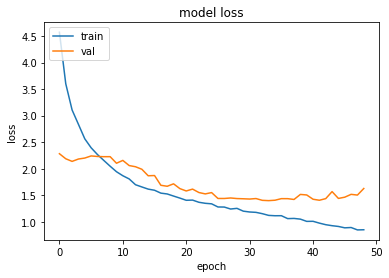

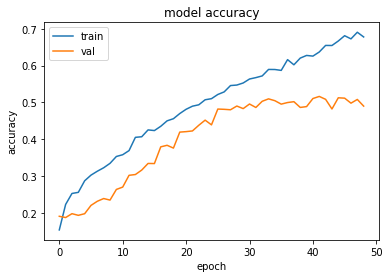

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  33 when  Val Loss was:  1.3987698554992676 , and Val Acc happened to be 0.5097000002861023
Additionally, the best val acc epoch happened to be  41 when val acc was:  0.5163000226020813 and Val Loss happened to be  1.4060444831848145
TestLoss:  1.3850833177566528  TestAcc: 0.5072000026702881
frog 0.803
automobile 0.673
ship 0.614
truck 0.601
airplane 0.513
dog 0.495
horse 0.493
deer 0.361
bird 0.324
cat 0.195


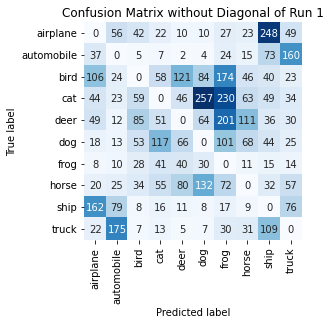

Summing down the rows, for Predictions of each Class that were wrong:  [466. 417. 321. 380. 381. 596. 876. 377. 646. 468.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  121.0 times
Summing across the columns, for total number of that True Class misidentified:  [487. 327. 676. 805. 639. 505. 197. 507. 386. 399.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  201.0 times

 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

   Begin Run:  2

 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:    ( 0 , 0 )
blur:     ( 3 , 3 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.2 , 0.2 )
Bright:   ( 0

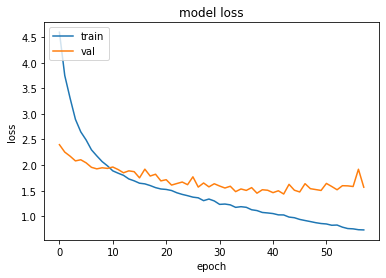

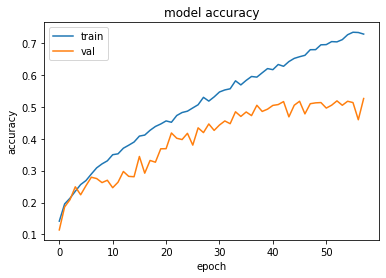

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  42 when  Val Loss was:  1.4345732927322388 , and Val Acc happened to be 0.516700029373169
Additionally, the best val acc epoch happened to be  57 when val acc was:  0.5263000130653381 and Val Loss happened to be  1.567223072052002
TestLoss:  1.4055063724517822  TestAcc: 0.5175999999046326
frog 0.737
ship 0.674
dog 0.625
truck 0.609
automobile 0.569
airplane 0.484
horse 0.47
deer 0.43
bird 0.306
cat 0.272


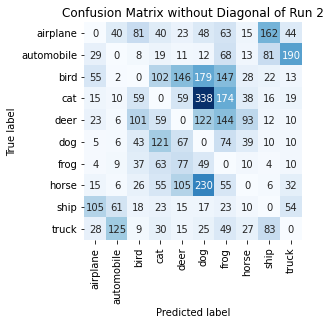

Summing down the rows, for Predictions of each Class that were wrong:  [ 279.  265.  382.  512.  518. 1020.  797.  273.  396.  382.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  146.0 times
Summing across the columns, for total number of that True Class misidentified:  [516. 431. 694. 728. 570. 375. 263. 530. 326. 391.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  144.0 times

 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

   Begin Run:  3

 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 0 , 0 )
blur:     ( 0 , 1 )
sharp:    ( 0.1 , 0.1 )
Contrast: ( 0.2 , 0

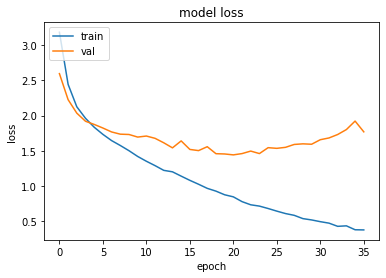

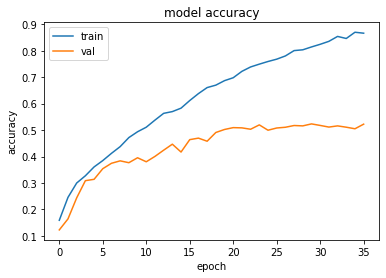

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  20 when  Val Loss was:  1.4420565366744995 , and Val Acc happened to be 0.5091999769210815
Additionally, the best val acc epoch happened to be  29 when val acc was:  0.5232999920845032 and Val Loss happened to be  1.5929890871047974
TestLoss:  1.4181634187698364  TestAcc: 0.5109999775886536
frog 0.741
ship 0.669
truck 0.577
automobile 0.561
dog 0.527
horse 0.506
airplane 0.485
deer 0.464
cat 0.367
bird 0.213


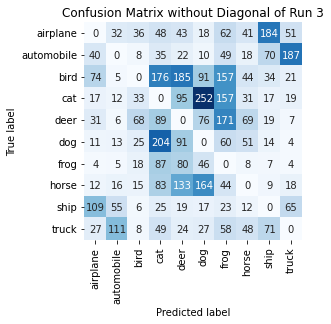

Summing down the rows, for Predictions of each Class that were wrong:  [325. 255. 217. 796. 692. 701. 781. 322. 425. 376.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  185.0 times
Summing across the columns, for total number of that True Class misidentified:  [515. 439. 787. 633. 536. 473. 259. 494. 331. 423.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  171.0 times

 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

   Begin Run:  4

 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma:    ( 110 , 110 )
ZoomOut:  ( -0.08 , -0.08 )
ZoomIn:   ( 0.08 , 0.08 )
Noise:    ( 12 , 12 )
blur:     ( 3 , 3 )
sharp:    ( 0.05 , 0.05 )
Contrast: ( 0.1

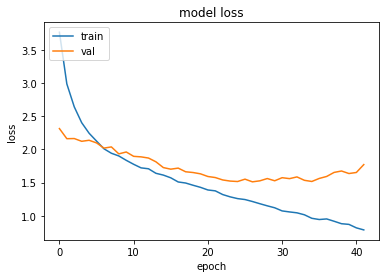

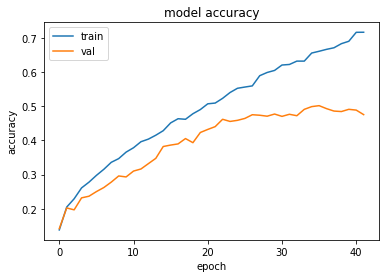

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  26 when  Val Loss was:  1.510553002357483 , and Val Acc happened to be 0.4749000072479248
Additionally, the best val acc epoch happened to be  35 when val acc was:  0.5013999938964844 and Val Loss happened to be  1.5616357326507568
TestLoss:  1.4927884340286255  TestAcc: 0.47380000352859497
frog 0.676
ship 0.634
truck 0.607
horse 0.573
dog 0.562
airplane 0.447
deer 0.4
automobile 0.393
cat 0.298
bird 0.148


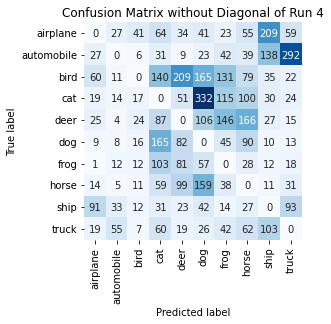

Summing down the rows, for Predictions of each Class that were wrong:  [265. 169. 146. 740. 607. 951. 596. 646. 575. 567.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  209.0 times
Summing across the columns, for total number of that True Class misidentified:  [553. 607. 852. 702. 600. 438. 324. 427. 366. 393.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  166.0 times

 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 

   Begin Run:  5

 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.08 , 0.08 )
Noise:    ( 0 , 0 )
blur:     ( 7 , 7 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright:   

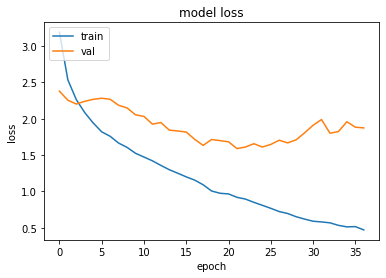

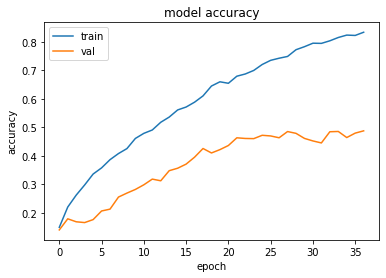

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  21 when  Val Loss was:  1.58881413936615 , and Val Acc happened to be 0.46320000290870667
Additionally, the best val acc epoch happened to be  36 when val acc was:  0.4875999987125397 and Val Loss happened to be  1.8730781078338623
TestLoss:  1.5803624391555786  TestAcc: 0.45899999141693115
frog 0.59
ship 0.553
airplane 0.551
dog 0.528
horse 0.468
automobile 0.463
truck 0.456
cat 0.398
deer 0.366
bird 0.217


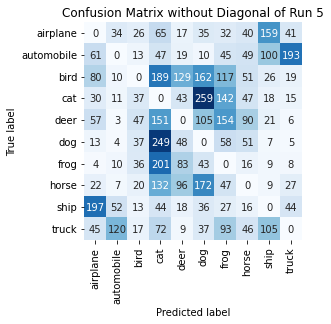

Summing down the rows, for Predictions of each Class that were wrong:  [ 509.  251.  246. 1150.  462.  859.  715.  406.  454.  358.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  129.0 times
Summing across the columns, for total number of that True Class misidentified:  [449. 537. 783. 602. 634. 472. 410. 532. 447. 544.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  154.0 times

 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 

   Begin Run:  6

 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 24 , 24 )
blur:     ( 7 , 7 )
sharp:    ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0

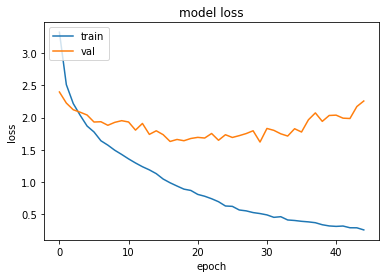

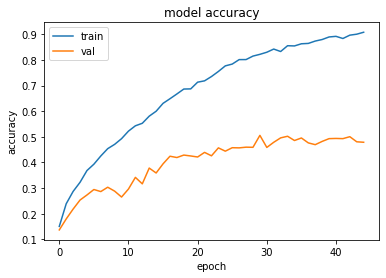

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  29 when  Val Loss was:  1.6205776929855347 , and Val Acc happened to be 0.5055000185966492
Additionally, the best val acc epoch happened to be  29 when val acc was:  0.5055000185966492 and Val Loss happened to be  1.6205776929855347
TestLoss:  1.5996918678283691  TestAcc: 0.4999000132083893
ship 0.732
frog 0.729
airplane 0.555
automobile 0.544
horse 0.532
truck 0.498
deer 0.433
dog 0.415
bird 0.285
cat 0.276


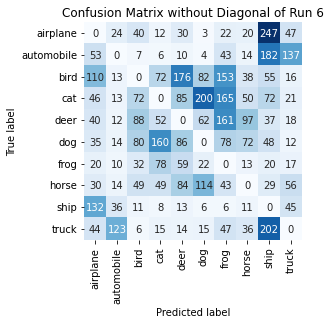

Summing down the rows, for Predictions of each Class that were wrong:  [510. 259. 385. 452. 557. 508. 718. 351. 892. 369.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  176.0 times
Summing across the columns, for total number of that True Class misidentified:  [445. 456. 715. 724. 567. 585. 271. 468. 268. 502.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  161.0 times

 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 

   Begin Run:  7

 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:    ( 24 , 24 )
blur:     ( 0 , 1 )
sharp:    ( 0.1 , 0.1 )
Contrast: ( 0.0 , 0.0 )
Bri

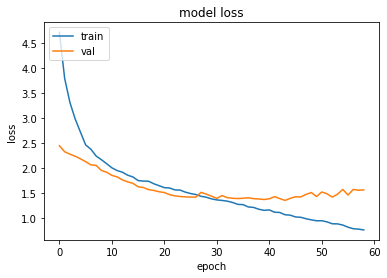

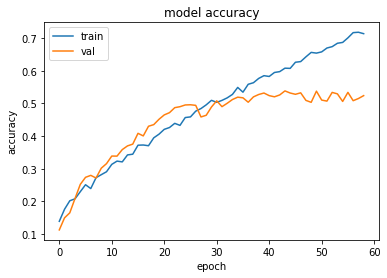

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  43 when  Val Loss was:  1.3547226190567017 , and Val Acc happened to be 0.5385000109672546
Additionally, the best val acc epoch happened to be  43 when val acc was:  0.5385000109672546 and Val Loss happened to be  1.3547226190567017
TestLoss:  1.3358453512191772  TestAcc: 0.534500002861023
frog 0.694
truck 0.653
ship 0.651
automobile 0.615
horse 0.558
airplane 0.523
dog 0.501
deer 0.478
bird 0.437
cat 0.235


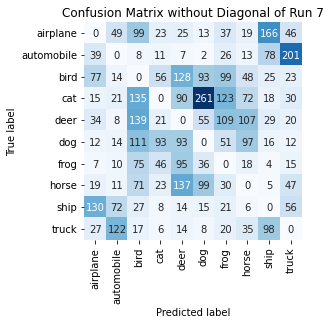

Summing down the rows, for Predictions of each Class that were wrong:  [360. 321. 682. 287. 603. 582. 516. 415. 439. 450.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  137.0 times
Summing across the columns, for total number of that True Class misidentified:  [477. 385. 563. 765. 522. 499. 306. 442. 349. 347.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  139.0 times

 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 

   Begin Run:  8

 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:    ( 24 , 24 )
blur:     ( 7 , 7 )
sharp:    ( 0.0 , 0.0 )
Contrast: ( 0.0 , 0.0 )
Bright:   ( 0

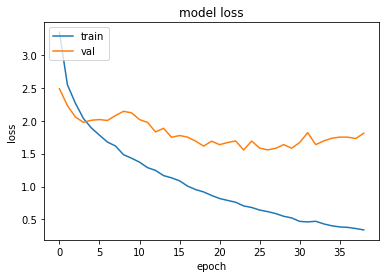

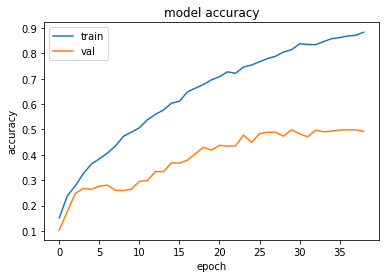

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  23 when  Val Loss was:  1.5547802448272705 , and Val Acc happened to be 0.47780001163482666
Additionally, the best val acc epoch happened to be  29 when val acc was:  0.49880000948905945 and Val Loss happened to be  1.5821648836135864
TestLoss:  1.532621145248413  TestAcc: 0.47780001163482666
frog 0.735
airplane 0.592
ship 0.582
deer 0.513
dog 0.505
automobile 0.477
truck 0.41
horse 0.407
bird 0.332
cat 0.225


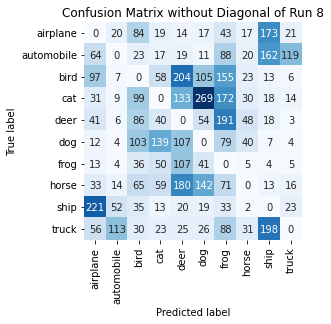

Summing down the rows, for Predictions of each Class that were wrong:  [568. 229. 561. 418. 809. 684. 920. 216. 606. 211.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  204.0 times
Summing across the columns, for total number of that True Class misidentified:  [408. 523. 668. 775. 487. 495. 265. 593. 418. 590.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  191.0 times

 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 

   Begin Run:  9

 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.0625 , 0.0625 )or ( -0.0625 , -0.0625 )
Gamma:    ( 110 , 110 )
ZoomOut:  ( -0.08 , -0.08 )
ZoomIn:   ( 0.08 , 0.08 )
Noise:    ( 12 , 12 )
blur:     ( 3 , 3 )
sharp:    ( 0.05 , 0.05 )
Contrast: ( 0.1

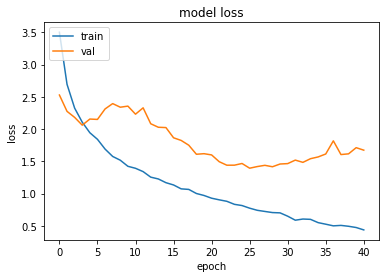

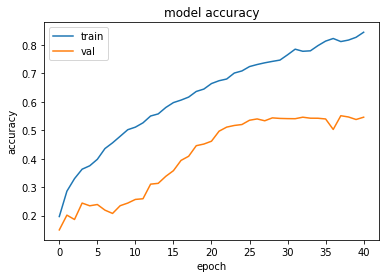

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  25 when  Val Loss was:  1.393627643585205 , and Val Acc happened to be 0.5353000164031982
Additionally, the best val acc epoch happened to be  37 when val acc was:  0.5511999726295471 and Val Loss happened to be  1.6051076650619507
TestLoss:  1.3748996257781982  TestAcc: 0.5351999998092651
ship 0.735
truck 0.724
frog 0.7
horse 0.566
deer 0.552
airplane 0.533
automobile 0.499
dog 0.411
cat 0.371
bird 0.261


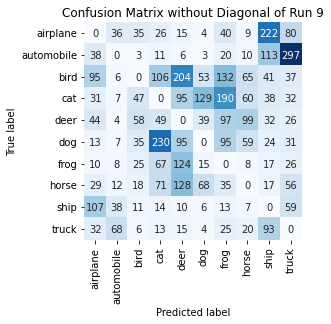

Summing down the rows, for Predictions of each Class that were wrong:  [399. 186. 238. 587. 692. 321. 647. 337. 597. 644.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  204.0 times
Summing across the columns, for total number of that True Class misidentified:  [467. 501. 739. 629. 448. 589. 300. 434. 265. 276.]
For example, the model misclassified true 4's (deer) as label   7 horse  a total of  99.0 times

 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 

   Begin Run:  10

 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.5
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.16 , 0.16 )
Noise:  

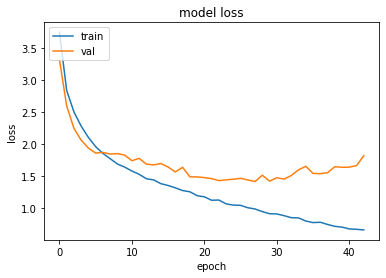

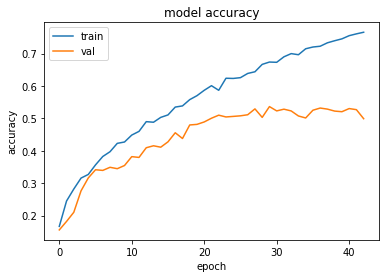

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  27 when  Val Loss was:  1.413034200668335 , and Val Acc happened to be 0.52920001745224
Additionally, the best val acc epoch happened to be  29 when val acc was:  0.536300003528595 and Val Loss happened to be  1.4197297096252441
TestLoss:  1.3784089088439941  TestAcc: 0.5297999978065491
frog 0.754
truck 0.662
horse 0.612
ship 0.611
automobile 0.554
dog 0.548
airplane 0.535
deer 0.507
bird 0.271
cat 0.244


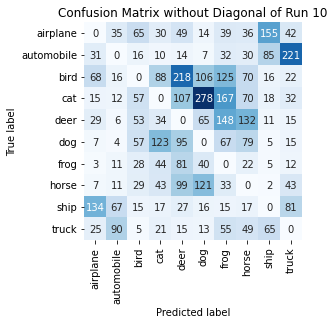

Summing down the rows, for Predictions of each Class that were wrong:  [319. 252. 325. 410. 705. 660. 681. 505. 362. 483.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  218.0 times
Summing across the columns, for total number of that True Class misidentified:  [465. 446. 729. 756. 493. 452. 246. 388. 389. 338.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  148.0 times

 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 

   Begin Run:  11

 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.16 , -0.16 )
ZoomIn:   ( 0.0 , 0.0 )
Noise:  

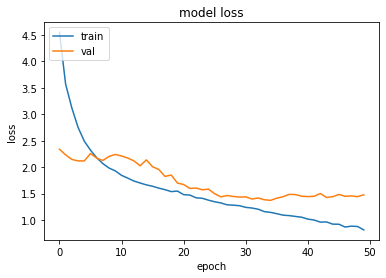

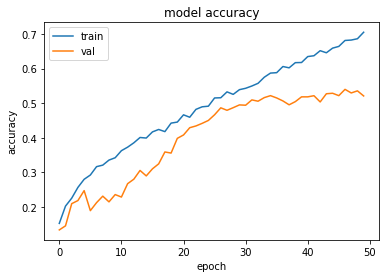

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  34 when  Val Loss was:  1.3730055093765259 , and Val Acc happened to be 0.5217000246047974
Additionally, the best val acc epoch happened to be  46 when val acc was:  0.539900004863739 and Val Loss happened to be  1.4493248462677002
TestLoss:  1.32624351978302  TestAcc: 0.527999997138977
frog 0.775
automobile 0.732
dog 0.621
horse 0.607
ship 0.574
truck 0.573
airplane 0.497
deer 0.406
bird 0.359
cat 0.136


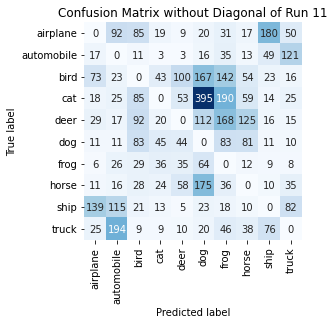

Summing down the rows, for Predictions of each Class that were wrong:  [329. 519. 443. 212. 317. 992. 749. 409. 388. 362.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  100.0 times
Summing across the columns, for total number of that True Class misidentified:  [503. 268. 641. 864. 594. 379. 225. 393. 426. 427.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  168.0 times

 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 

   Begin Run:  12

 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.125 , 0.125 ) or ( -0.125 , -0.125 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.08 , -0.08 )
ZoomIn:   ( 0.16 , 0.16 

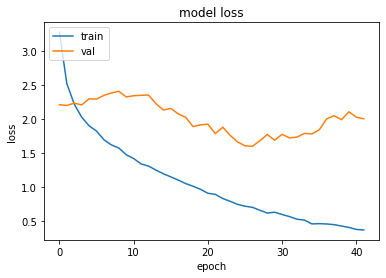

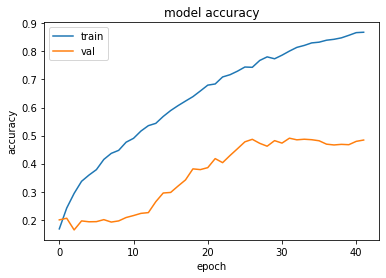

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  26 when  Val Loss was:  1.602063536643982 , and Val Acc happened to be 0.48669999837875366
Additionally, the best val acc epoch happened to be  31 when val acc was:  0.49070000648498535 and Val Loss happened to be  1.7256689071655273
TestLoss:  1.5953675508499146  TestAcc: 0.48410001397132874
frog 0.746
ship 0.656
truck 0.522
airplane 0.521
automobile 0.49
dog 0.464
bird 0.45
horse 0.418
deer 0.346
cat 0.228


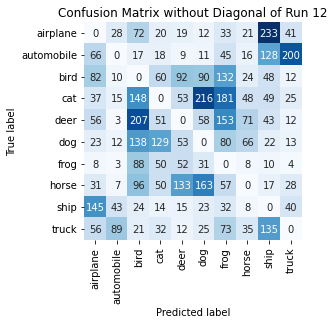

Summing down the rows, for Predictions of each Class that were wrong:  [504. 210. 811. 424. 438. 629. 786. 297. 685. 375.]
For example, the model predicted a  label 4 (deer) on a true   7  a total of  133.0 times
Summing across the columns, for total number of that True Class misidentified:  [479. 510. 550. 772. 654. 536. 254. 582. 344. 478.]
For example, the model misclassified true 4's (deer) as label   2 bird  a total of  207.0 times

 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 

   Begin Run:  13

 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0 , 0.0 ) or ( -0.0 , -0.0 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 120 , 120 )
ZoomOut:  ( -0.08 , -0.08 )
ZoomIn:   ( 0.0 , 0.0 )


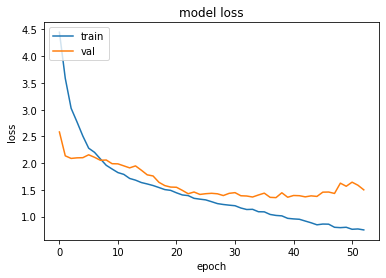

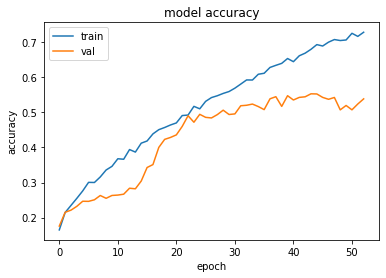

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  37 when  Val Loss was:  1.3557013273239136 , and Val Acc happened to be 0.5443000197410583
Additionally, the best val acc epoch happened to be  43 when val acc was:  0.5525000095367432 and Val Loss happened to be  1.388716459274292
TestLoss:  1.3239827156066895  TestAcc: 0.5408999919891357
frog 0.799
ship 0.684
truck 0.672
automobile 0.661
airplane 0.571
horse 0.545
dog 0.504
deer 0.439
cat 0.301
bird 0.233


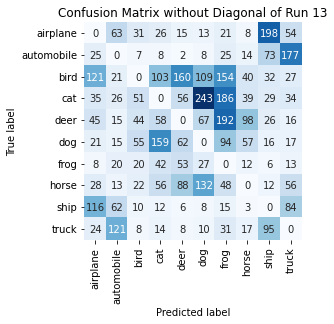

Summing down the rows, for Predictions of each Class that were wrong:  [423. 356. 248. 478. 450. 617. 766. 288. 487. 478.]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  160.0 times
Summing across the columns, for total number of that True Class misidentified:  [429. 339. 767. 699. 561. 496. 201. 455. 316. 328.]
For example, the model misclassified true 4's (deer) as label   6 frog  a total of  192.0 times

 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 

   Begin Run:  14

 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.4
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.0 , 0.0 )or ( -0.0 , -0.0 )
Gamma:    ( 100 , 100 )
ZoomOut:  ( -0.0 , -0.0 )
ZoomIn:   ( 0.0 , 0.0 

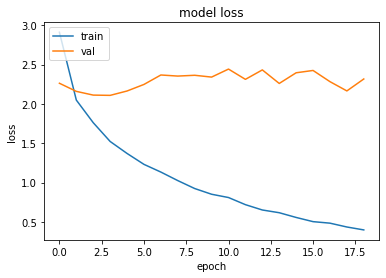

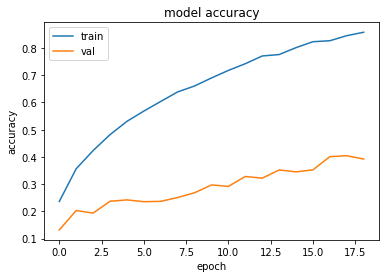

Early-Stop is on Val-Loss with patience = 15
Early Stop Epoch was:  3 when  Val Loss was:  2.108429431915283 , and Val Acc happened to be 0.2370000034570694
Additionally, the best val acc epoch happened to be  17 when val acc was:  0.4043999910354614 and Val Loss happened to be  2.1650078296661377
TestLoss:  2.100830554962158  TestAcc: 0.24240000545978546
cat 0.649
ship 0.56
dog 0.392
deer 0.329
frog 0.258
airplane 0.152
horse 0.074
truck 0.006
automobile 0.003
bird 0.001


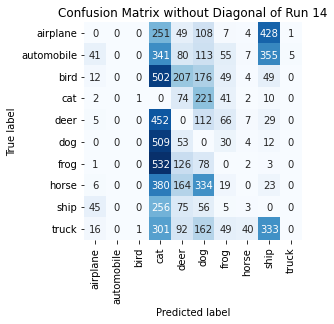

Summing down the rows, for Predictions of each Class that were wrong:  [1.280e+02 0.000e+00 2.000e+00 3.524e+03 9.200e+02 1.360e+03 3.210e+02
 7.300e+01 1.242e+03 6.000e+00]
For example, the model predicted a  label 4 (deer) on a true   2  a total of  207.0 times
Summing across the columns, for total number of that True Class misidentified:  [848. 997. 999. 351. 671. 608. 742. 926. 440. 994.]
For example, the model misclassified true 4's (deer) as label   3 cat  a total of  452.0 times

 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 

   Begin Run:  15

 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15  

 ~ ~ ~  List of Run-Specific Parameters  ~ ~ ~ 
Dropout:   0.6
Shift X:  ( 0.0625 , 0.0625 ) or ( -0.0625 , -0.0625 )
Shift Y:  ( 0.125 , 0.125 )or ( -0.125 , -0.125 )
Gamma:    ( 12

In [ ]:
run_through_runs(ds=make_unbatched(train_C),  ds_noalb= train_C_noalb, dstitle="C" , showpictures= False)


In [ ]:
run_through_runs(ds=make_unbatched(train_D),   ds_noalb=train_D_noalb,   dstitle="D" , showpictures= False)


In [ ]:
run_through_runs(ds=make_unbatched(train_E),     ds_noalb=train_E_noalb,   dstitle="E" , showpictures= False)

In [ ]:
run_through_runs(ds=make_unbatched(train_F),  ds_noalb=train_F_noalb, dstitle="F" , showpictures= False)

In [ ]:
run_through_runs(ds=make_unbatched(train_G),    ds_noalb=train_G_noalb, dstitle="G" , showpictures= False)

In [ ]:
run_through_runs(ds=make_unbatched(train_H),   ds_noalb= train_H_noalb, dstitle="H" , showpictures= False)

In [ ]:
run_through_runs(ds=make_unbatched(train_I),   ds_noalb=train_I_noalb,   dstitle="I" , showpictures= False)

In [ ]:
run_through_runs(ds=make_unbatched(train_J),  ds_noalb= train_J_noalb, dstitle="J" , showpictures= False)

# Time Required



In [ ]:
stop_testing = time.time()
print((stop_testing - tic) , "secs to  run everything start to end, or... ")
print((stop_testing - tic)/60, "minutes ... or ")
print((stop_testing - tic)/3600, "hours ")

# Post-Test: View Results

After the 50 runs above have run, its time to load the results into JMP to Fit the Definitive Screening Design and find which Main Effects have the most compeling effect.  This is my second time running the results of Training_Group_A.  The first time I created two for loops to go through the first 25 runs and save, and then the second 25 runs and save.  When I went through my results, the second 25 runs on average were slightly less test accuracy (diff of 0.03 according to block effect), and you could clearly see that each run of view_images(data) resulted in the exact same images.  So my belief is that for some reason, maybe due to a coding issue, or maybe just an artifact of calling up the dataset-augmentations "twice", the second 25 runs in the original "[Test1](https://github.com/RachelRamirez/CIFAR-10/blob/main/CollectionofTests/Test1GroupA.ipynb)" resulted in a visible block effect.  It was funny because I had made a block variable and then accidentally caused a significant blocking effect.. ANYWHO...  


In [ ]:
import pickle
import numpy as np
with open('runs_groupA (8).pkl', 'rb') as fid:
     lastruns_groupA_loaded = pickle.load(fid)  #this file originally saved 11-5-2021 from 1 each testset

lastruns_groupA_loaded

string_of_cm = " "
y = {}

# test
# string_of_cm = string_of_cm + np.array2string(lastruns_groupA_loaded[0]["CM"][0][0]) + " "
print("Run ,", "Test Accuracy ,", "Test Loss,", "Confusion Matrix Diagonals," )
 
CM_digit = []

for i in range(0,ENDRUNS):
  for x in range(0,10):
    #string_of_cm = string_of_cm + np.array2string(lastruns_groupA_loaded[i]["CM"][x][x]) + ", "
    CM_digit = lastruns_groupA_loaded[i]["CM"][x][x] + CM_digit
  y[i] = lastruns_groupA_loaded[i]['TestAccuracy'], lastruns_groupA_loaded[i]["TestLoss"], CM_digit 
  print(y[i])
  CM_digit = [] #clear?

lastruns_groupA_loaded[1]["TestAccuracy"]
lastruns_groupA_loaded[1]["CM"][:,0].sum()  #666 Predicted Class 0?
lastruns_groupA_loaded[1]["CM"][0,:].sum()  #1000 True Class 0?
lastruns_groupA_loaded[1]["CM"][1,:].sum()  #1000 True Class 1?

sum_of_cm_diagonals = 0
for i in range(10):
  sum_of_cm_diagonals = sum_of_cm_diagonals + lastruns_groupA_loaded[1]["CM"][i,i]    

print("Sum of Diagonals on Confusion Matrix of Run 1: ", sum_of_cm_diagonals) #checks with TestAccuracy


#I want to find the area of greatest confusion

#create a new matrix to not ruin previious CM
confusion_matrix_wo_diagonal = lastruns_groupA_loaded[1]["CM"].copy()
 
for i in range(10):
  confusion_matrix_wo_diagonal[i,i] = 0 # set the diagonal equal to zero
print(confusion_matrix_wo_diagonal)
# for i in range(10):
#   print(i, "is most often miscategorized as ", np.argmax(confusion_matrix_wo_diagonal[:,i]), " ", max(confusion_matrix_wo_diagonal[:,i]), " times")

for i in range(10):
  print("The algorithm predicted a ", np.argmax(confusion_matrix_wo_diagonal[i,:]),"instead of a ",  i, " ", max(confusion_matrix_wo_diagonal[i,:]), "times")



print("Summing down the rows, for COLUMN total: ", confusion_matrix_wo_diagonal.sum(axis=0))
print("Summing across the columns, for ROW total: ", confusion_matrix_wo_diagonal.sum(axis=1))

something weird about the above code.  My confusion matrix looks like its lost the diagonals. I think copying to confusion_matrix_wo_diagonal didn't do a separate copy, it is just linked, so when I cleared the diagonal of confusion_matrix_wo_diagonal, it also cleared it from lastruns_groupsA_loaded[1]["CM"]


In [ ]:
lastruns_groupA_loaded[0]["CM"]

In [ ]:
confusion_matrix_wo_diagonal.sum() + sum_of_cm_diagonals

In [ ]:
string_of_cm = ""

for i in range(1,2):  # goes through first n runs with CMs
  for x in range(10): # goes through the n items in diagonal of each run.CM
    string_of_cm = string_of_cm + np.array2string(lastruns_groupA_loaded[i]["CM"][x][x]) + ","
    y[i] = lastruns_groupA_loaded[i]['TestAccuracy'], lastruns_groupA_loaded[i]["TestLoss"], string_of_cm 
  print(y[i])
  

lastruns_groupA_loaded[1]["TestAccuracy"]
lastruns_groupA_loaded[1]["CM"][:,0].sum()  #666 Predicted Class 0
lastruns_groupA_loaded[1]["CM"][0,:].sum()  #1000 True Class 0
lastruns_groupA_loaded[1]["CM"][1,:].sum()  #1000 True Class 1

sum_of_cm_diagonals = 0
for i in range(10):
  sum_of_cm_diagonals = sum_of_cm_diagonals + lastruns_groupA_loaded[1]["CM"][i,i]    

print("Sum of Diagonals on Confusion Matrix of Run 1: ", sum_of_cm_diagonals) #checks with TestAccuracy


#I want to find the area of greatest confusion

#create a new matrix to not ruin previious CM
confusion_matrix_wo_diagonal = lastruns_groupA_loaded[1]["CM"].copy()
 
for i in range(10):
  confusion_matrix_wo_diagonal[i,i] = 0 # set the diagonal equal to zero
print(confusion_matrix_wo_diagonal)
# for i in range(10):
#   print(i, "is most often miscategorized as ", np.argmax(confusion_matrix_wo_diagonal[:,i]), " ", max(confusion_matrix_wo_diagonal[:,i]), " times")

for i in range(10):
  print("The algorithm predicted a ", np.argmax(confusion_matrix_wo_diagonal[i,:]),"instead of a ",  i, " ", max(confusion_matrix_wo_diagonal[i,:]), "times")



print("Summing down the rows, for COLUMN total: ", confusion_matrix_wo_diagonal.sum(axis=0))
print("Summing across the columns, for ROW total: ", confusion_matrix_wo_diagonal.sum(axis=1))